In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
import pandas as pd
from utils.preprocess import treat_dataset_pandas_init, build_preprocessing_pipeline,INIT_NUMERICAL_COLS, numerical_features

from utils.metrics import rmsle_metric

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import root_mean_squared_log_error
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
import numpy as np
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor
from utils.categoricals import CategoricalToStringTransformer, CategoricalEncoder

import joblib

In [3]:
train_data = pd.read_csv("playground-series-s4e12/train.csv")#.sample(frac=0.1)
test_data = pd.read_csv("playground-series-s4e12/test.csv")

treated_dataset = treat_dataset_pandas_init(train_data, process_as_category=True)
non_loged_train_local, non_loged_test_local = joblib.load("cat_non_loged_local.pkl")
non_loged_train, non_loged_test = joblib.load("cat_non_loged.pkl")

treated_dataset['non_log_oof_prediction_local'] = non_loged_train_local
treated_dataset['non_log_oof_prediction'] = non_loged_train

X_train = treated_dataset.drop(columns=["Premium Amount"])
y_train = treated_dataset["Premium Amount"]


# LGBM

In [4]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np

def rmsle_metric(y_pred, dataset):
    y_true = dataset.get_label()
    
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred) 

    rmsle = root_mean_squared_log_error(y_true, y_pred)
    
    return 'rmsle', rmsle, False  # False because lower is better

# Define objective function
def objective(trial):
    param_grid = {
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'objective': 'regression',  # Use 'binary' for classification
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.5),  # Fine-tuned range
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 180),  # Wider range for more exploration
        'max_depth': trial.suggest_int('max_depth', -1, 180),  # Allow deeper trees or unlimited depth (-1)
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),  # Sampling fraction of features
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),  # Sampling fraction of data
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  # Frequency of bagging
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),  # Minimum samples per leaf
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-3, 0.1),  # Minimum gain for a split
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10),  # Minimum weight for children
        'lambda_l1': trial.suggest_float ('lambda_l1', 1e-3, 10),  # L1 regularization
        'lambda_l2': trial.suggest_float ('lambda_l2', 1e-3, 10),  # L2 regularization
        'cat_smooth': trial.suggest_float ('cat_smooth', 5, 30),  # Smoothing for categorical features
        'max_bin': trial.suggest_int('max_bin', 1, 255),  # Granularity of feature splits
        'verbose': -1,  # Suppress output
        'random_state': 41,  # Reproducibility
    }
    print(param_grid)
    
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    train_data_lgbm = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data_lgbm = lgb.Dataset(X_val_fold, label=y_val_fold)
    
    # Train model
    model = lgb.train(
        param_grid,
        train_data_lgbm,
        valid_sets=[train_data_lgbm, val_data_lgbm],
        valid_names=["train", "validation"],
        feval=rmsle_metric,    # Custom RMSLE metric
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=5),  # Optional: Logs evaluation every 10 rounds
        ]
    )
    return model.best_score['validation']['rmsle']
        
    
import optuna

# Get current date and time in the format YYYYMMDD_HHMMSS
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a study with a date and time identifier
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///optuna_db.sqlite3",
    study_name=f"insurance-{current_datetime}",  # Append date and time to study name,
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

[I 2024-12-29 02:11:52,965] A new study created in RDB with name: insurance-20241229_021152


In [7]:
study.optimize(objective, n_trials=50)

{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.05850583436029813, 'num_boost_round': 894, 'num_leaves': 156, 'max_depth': 10, 'feature_fraction': 0.7631795017822178, 'bagging_fraction': 0.6300421208418566, 'bagging_freq': 2, 'min_child_samples': 29, 'min_split_gain': 0.04634359216420881, 'min_child_weight': 3.5128048702401764, 'lambda_l1': 9.313064358486637, 'lambda_l2': 5.618925811069139, 'cat_smooth': 22.40324690307596, 'max_bin': 149, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.14478	train's rmsle: 1.06994	validation's l2: 1.14391	validation's rmsle: 1.06954
[10]	train's l2: 1.11114	train's rmsle: 1.05411	validation's l2: 1.11183	validation's rmsle: 1.05443
[15]	train's l2: 1.09199	train's rmsle: 1.04498	validation's l2: 1.09398	validation's rmsle: 1.04594
[20]	train's l2: 1.07894	train's rmsle: 1.03872	validation's l2: 1.08223	validation's rmsle: 1.0403
[25]	train's l2: 1.06891	train's rmsle: 1.03388	validation's l2: 1.07391	validation's rmsle: 1.0363
[30]	train's l2: 1.06269	train's rmsle: 1.03087	validation's l2: 1.06913	validation's rmsle: 1.03399
[35]	train's l2: 1.05866	train's rmsle: 1.02891	validation's l2: 1.06663	validation's rmsle: 1.03278
[40]	train's l2: 1.05543	train's rmsle: 1.02734	validation's l2: 1.06437	validation's rmsle: 1.03168
[45]	train's l2: 1.05314	train's rmsle: 1.02622	validation's l2: 1.06346	validation's rmsle: 1.03124
[50]	train's l2: 1.0512	train's r

[I 2024-12-28 04:13:04,439] Trial 0 finished with value: 1.0302638795502155 and parameters: {'learning_rate': 0.05850583436029813, 'num_boost_round': 894, 'num_leaves': 156, 'max_depth': 10, 'feature_fraction': 0.7631795017822178, 'bagging_fraction': 0.6300421208418566, 'bagging_freq': 2, 'min_child_samples': 29, 'min_split_gain': 0.04634359216420881, 'min_child_weight': 3.5128048702401764, 'lambda_l1': 9.313064358486637, 'lambda_l2': 5.618925811069139, 'cat_smooth': 22.40324690307596, 'max_bin': 149}. Best is trial 0 with value: 1.0302638795502155.


[105]	train's l2: 1.03835	train's rmsle: 1.01899	validation's l2: 1.06159	validation's rmsle: 1.03034
Early stopping, best iteration is:
[95]	train's l2: 1.04033	train's rmsle: 1.01997	validation's l2: 1.06144	validation's rmsle: 1.03026
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.48153637522012616, 'num_boost_round': 130, 'num_leaves': 143, 'max_depth': 124, 'feature_fraction': 0.6704681150644392, 'bagging_fraction': 0.5905672546440797, 'bagging_freq': 6, 'min_child_samples': 47, 'min_split_gain': 0.02608130840237262, 'min_child_weight': 5.307769466149973, 'lambda_l1': 4.253111803828059, 'lambda_l2': 3.979390392738965, 'cat_smooth': 26.73767177714868, 'max_bin': 18, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.06174	train's rmsle: 1.03041	validation's l2: 1.07648	validation's rmsle: 1.03754
[10]	train's l2: 1.05241	train's rmsle: 1.02587	validation's l2: 1.07792	validation's rmsle: 1.03823


[I 2024-12-28 04:13:08,229] Trial 1 finished with value: 1.0371697888043148 and parameters: {'learning_rate': 0.48153637522012616, 'num_boost_round': 130, 'num_leaves': 143, 'max_depth': 124, 'feature_fraction': 0.6704681150644392, 'bagging_fraction': 0.5905672546440797, 'bagging_freq': 6, 'min_child_samples': 47, 'min_split_gain': 0.02608130840237262, 'min_child_weight': 5.307769466149973, 'lambda_l1': 4.253111803828059, 'lambda_l2': 3.979390392738965, 'cat_smooth': 26.73767177714868, 'max_bin': 18}. Best is trial 0 with value: 1.0302638795502155.


[15]	train's l2: 1.046	train's rmsle: 1.02274	validation's l2: 1.08093	validation's rmsle: 1.03968
Early stopping, best iteration is:
[6]	train's l2: 1.05838	train's rmsle: 1.02878	validation's l2: 1.07572	validation's rmsle: 1.03717
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.11968879778568113, 'num_boost_round': 942, 'num_leaves': 54, 'max_depth': 64, 'feature_fraction': 0.937211919180702, 'bagging_fraction': 0.7904985129141457, 'bagging_freq': 1, 'min_child_samples': 20, 'min_split_gain': 0.06284597318731124, 'min_child_weight': 1.1135596834959944, 'lambda_l1': 8.606442558196681, 'lambda_l2': 7.056440566739388, 'cat_smooth': 13.653719246012647, 'max_bin': 232, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.10667	train's rmsle: 1.05199	validation's l2: 1.10569	validation's rmsle: 1.05152
[10]	train's l2: 1.07604	train's rmsle: 1.03732	validation's l2: 1.07756	validation's rmsle: 1.03806
[15]	train's l2: 1.06424	train's rmsle: 1.03162	validation's l2: 1.06918	validation's rmsle: 1.03401
[20]	train's l2: 1.05819	train's rmsle: 1.02868	validation's l2: 1.0655	validation's rmsle: 1.03223
[25]	train's l2: 1.05468	train's rmsle: 1.02697	validation's l2: 1.06466	validation's rmsle: 1.03182
[30]	train's l2: 1.0522	train's rmsle: 1.02577	validation's l2: 1.06398	validation's rmsle: 1.0315
[35]	train's l2: 1.05019	train's rmsle: 1.02479	validation's l2: 1.06408	validation's rmsle: 1.03154


[I 2024-12-28 04:13:14,839] Trial 2 finished with value: 1.0314813151167297 and parameters: {'learning_rate': 0.11968879778568113, 'num_boost_round': 942, 'num_leaves': 54, 'max_depth': 64, 'feature_fraction': 0.937211919180702, 'bagging_fraction': 0.7904985129141457, 'bagging_freq': 1, 'min_child_samples': 20, 'min_split_gain': 0.06284597318731124, 'min_child_weight': 1.1135596834959944, 'lambda_l1': 8.606442558196681, 'lambda_l2': 7.056440566739388, 'cat_smooth': 13.653719246012647, 'max_bin': 232}. Best is trial 0 with value: 1.0302638795502155.


[40]	train's l2: 1.04819	train's rmsle: 1.02381	validation's l2: 1.06411	validation's rmsle: 1.03156
Early stopping, best iteration is:
[31]	train's l2: 1.05179	train's rmsle: 1.02557	validation's l2: 1.06395	validation's rmsle: 1.03148
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.3481045404364163, 'num_boost_round': 334, 'num_leaves': 101, 'max_depth': 111, 'feature_fraction': 0.6679240602872477, 'bagging_fraction': 0.6472376722003466, 'bagging_freq': 4, 'min_child_samples': 34, 'min_split_gain': 0.003648872833799879, 'min_child_weight': 6.724935024804905, 'lambda_l1': 3.3377246612425386, 'lambda_l2': 7.927406970593436, 'cat_smooth': 25.140634843756224, 'max_bin': 205, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.06364	train's rmsle: 1.03133	validation's l2: 1.07228	validation's rmsle: 1.03551
[10]	train's l2: 1.05188	train's rmsle: 1.02561	validation's l2: 1.0683	validation's rmsle: 1.03359
[15]	train's l2: 1.04652	train's rmsle: 1.02299	validation's l2: 1.06836	validation's rmsle: 1.03361
[20]	train's l2: 1.04236	train's rmsle: 1.02096	validation's l2: 1.06844	validation's rmsle: 1.03365


[I 2024-12-28 04:13:19,476] Trial 3 finished with value: 1.0333760564805434 and parameters: {'learning_rate': 0.3481045404364163, 'num_boost_round': 334, 'num_leaves': 101, 'max_depth': 111, 'feature_fraction': 0.6679240602872477, 'bagging_fraction': 0.6472376722003466, 'bagging_freq': 4, 'min_child_samples': 34, 'min_split_gain': 0.003648872833799879, 'min_child_weight': 6.724935024804905, 'lambda_l1': 3.3377246612425386, 'lambda_l2': 7.927406970593436, 'cat_smooth': 25.140634843756224, 'max_bin': 205}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[13]	train's l2: 1.04829	train's rmsle: 1.02386	validation's l2: 1.06787	validation's rmsle: 1.03338
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.242220074265329, 'num_boost_round': 435, 'num_leaves': 105, 'max_depth': 39, 'feature_fraction': 0.9460255435269094, 'bagging_fraction': 0.6818117405950925, 'bagging_freq': 4, 'min_child_samples': 35, 'min_split_gain': 0.07026990785369944, 'min_child_weight': 8.968995570496544, 'lambda_l1': 6.393931124830715, 'lambda_l2': 2.153082956882257, 'cat_smooth': 19.911170586414556, 'max_bin': 206, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.06985	train's rmsle: 1.03434	validation's l2: 1.07646	validation's rmsle: 1.03753
[10]	train's l2: 1.05408	train's rmsle: 1.02669	validation's l2: 1.06765	validation's rmsle: 1.03327
[15]	train's l2: 1.04763	train's rmsle: 1.02354	validation's l2: 1.06766	validation's rmsle: 1.03328
[20]	train's l2: 1.04264	train's rmsle: 1.0211	validation's l2: 1.06751	validation's rmsle: 1.03321
[25]	train's l2: 1.03835	train's rmsle: 1.019	validation's l2: 1.06798	validation's rmsle: 1.03343


[I 2024-12-28 04:13:24,640] Trial 4 finished with value: 1.0330164210360113 and parameters: {'learning_rate': 0.242220074265329, 'num_boost_round': 435, 'num_leaves': 105, 'max_depth': 39, 'feature_fraction': 0.9460255435269094, 'bagging_fraction': 0.6818117405950925, 'bagging_freq': 4, 'min_child_samples': 35, 'min_split_gain': 0.07026990785369944, 'min_child_weight': 8.968995570496544, 'lambda_l1': 6.393931124830715, 'lambda_l2': 2.153082956882257, 'cat_smooth': 19.911170586414556, 'max_bin': 206}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[17]	train's l2: 1.04518	train's rmsle: 1.02234	validation's l2: 1.06712	validation's rmsle: 1.03302
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.42951744777105083, 'num_boost_round': 245, 'num_leaves': 91, 'max_depth': 173, 'feature_fraction': 0.5799841240437211, 'bagging_fraction': 0.5742655760923849, 'bagging_freq': 6, 'min_child_samples': 34, 'min_split_gain': 0.07221357020902505, 'min_child_weight': 2.2321354844469323, 'lambda_l1': 5.318630626171263, 'lambda_l2': 0.8317400895673587, 'cat_smooth': 20.952041699503297, 'max_bin': 220, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.06216	train's rmsle: 1.03061	validation's l2: 1.0718	validation's rmsle: 1.03528
[10]	train's l2: 1.05247	train's rmsle: 1.0259	validation's l2: 1.07167	validation's rmsle: 1.03521
[15]	train's l2: 1.04663	train's rmsle: 1.02305	validation's l2: 1.07196	validation's rmsle: 1.03535


[I 2024-12-28 04:13:28,832] Trial 5 finished with value: 1.0345013329369677 and parameters: {'learning_rate': 0.42951744777105083, 'num_boost_round': 245, 'num_leaves': 91, 'max_depth': 173, 'feature_fraction': 0.5799841240437211, 'bagging_fraction': 0.5742655760923849, 'bagging_freq': 6, 'min_child_samples': 34, 'min_split_gain': 0.07221357020902505, 'min_child_weight': 2.2321354844469323, 'lambda_l1': 5.318630626171263, 'lambda_l2': 0.8317400895673587, 'cat_smooth': 20.952041699503297, 'max_bin': 220}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[8]	train's l2: 1.05482	train's rmsle: 1.02704	validation's l2: 1.07019	validation's rmsle: 1.0345
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.2777353501584632, 'num_boost_round': 345, 'num_leaves': 177, 'max_depth': 105, 'feature_fraction': 0.6923060309719093, 'bagging_fraction': 0.6732294916588364, 'bagging_freq': 2, 'min_child_samples': 42, 'min_split_gain': 0.008102717415807436, 'min_child_weight': 1.5069228495289695, 'lambda_l1': 0.18145132949625933, 'lambda_l2': 0.9486287126447965, 'cat_smooth': 10.99995673986702, 'max_bin': 129, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.06157	train's rmsle: 1.03033	validation's l2: 1.07654	validation's rmsle: 1.03756
[10]	train's l2: 1.0434	train's rmsle: 1.02147	validation's l2: 1.07012	validation's rmsle: 1.03446
[15]	train's l2: 1.03394	train's rmsle: 1.01683	validation's l2: 1.06994	validation's rmsle: 1.03438
[20]	train's l2: 1.02724	train's rmsle: 1.01353	validation's l2: 1.07081	validation's rmsle: 1.0348


[I 2024-12-28 04:13:33,434] Trial 6 finished with value: 1.0339363057447502 and parameters: {'learning_rate': 0.2777353501584632, 'num_boost_round': 345, 'num_leaves': 177, 'max_depth': 105, 'feature_fraction': 0.6923060309719093, 'bagging_fraction': 0.6732294916588364, 'bagging_freq': 2, 'min_child_samples': 42, 'min_split_gain': 0.008102717415807436, 'min_child_weight': 1.5069228495289695, 'lambda_l1': 0.18145132949625933, 'lambda_l2': 0.9486287126447965, 'cat_smooth': 10.99995673986702, 'max_bin': 129}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[12]	train's l2: 1.03851	train's rmsle: 1.01907	validation's l2: 1.06902	validation's rmsle: 1.03394
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.33745891854355614, 'num_boost_round': 691, 'num_leaves': 25, 'max_depth': 48, 'feature_fraction': 0.8046245959389997, 'bagging_fraction': 0.8988805355170112, 'bagging_freq': 2, 'min_child_samples': 49, 'min_split_gain': 0.024626722270221543, 'min_child_weight': 9.142945428513343, 'lambda_l1': 6.990410672921513, 'lambda_l2': 0.5532944786857752, 'cat_smooth': 20.73772663220819, 'max_bin': 74, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.0734	train's rmsle: 1.03605	validation's l2: 1.07254	validation's rmsle: 1.03563
[10]	train's l2: 1.06342	train's rmsle: 1.03122	validation's l2: 1.06604	validation's rmsle: 1.03249
[15]	train's l2: 1.05979	train's rmsle: 1.02946	validation's l2: 1.06496	validation's rmsle: 1.03197
[20]	train's l2: 1.05693	train's rmsle: 1.02807	validation's l2: 1.06446	validation's rmsle: 1.03173
[25]	train's l2: 1.05511	train's rmsle: 1.02719	validation's l2: 1.06445	validation's rmsle: 1.03172


[I 2024-12-28 04:13:38,564] Trial 7 finished with value: 1.0316569438891179 and parameters: {'learning_rate': 0.33745891854355614, 'num_boost_round': 691, 'num_leaves': 25, 'max_depth': 48, 'feature_fraction': 0.8046245959389997, 'bagging_fraction': 0.8988805355170112, 'bagging_freq': 2, 'min_child_samples': 49, 'min_split_gain': 0.024626722270221543, 'min_child_weight': 9.142945428513343, 'lambda_l1': 6.990410672921513, 'lambda_l2': 0.5532944786857752, 'cat_smooth': 20.73772663220819, 'max_bin': 74}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[17]	train's l2: 1.05858	train's rmsle: 1.02887	validation's l2: 1.06432	validation's rmsle: 1.03166
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1558660548009821, 'num_boost_round': 357, 'num_leaves': 42, 'max_depth': 20, 'feature_fraction': 0.8928819897266955, 'bagging_fraction': 0.5425450016032065, 'bagging_freq': 4, 'min_child_samples': 39, 'min_split_gain': 0.0046095841415256696, 'min_child_weight': 1.7506715875456254, 'lambda_l1': 4.093351224374021, 'lambda_l2': 2.7703818328954255, 'cat_smooth': 14.945080657273758, 'max_bin': 176, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.09702	train's rmsle: 1.04739	validation's l2: 1.0968	validation's rmsle: 1.04728
[10]	train's l2: 1.07152	train's rmsle: 1.03514	validation's l2: 1.07346	validation's rmsle: 1.03608
[15]	train's l2: 1.06389	train's rmsle: 1.03145	validation's l2: 1.06826	validation's rmsle: 1.03356
[20]	train's l2: 1.06004	train's rmsle: 1.02958	validation's l2: 1.06615	validation's rmsle: 1.03255
[25]	train's l2: 1.0578	train's rmsle: 1.02849	validation's l2: 1.06574	validation's rmsle: 1.03235
[30]	train's l2: 1.05598	train's rmsle: 1.02761	validation's l2: 1.06536	validation's rmsle: 1.03216
[35]	train's l2: 1.05458	train's rmsle: 1.02693	validation's l2: 1.06541	validation's rmsle: 1.03219


[I 2024-12-28 04:13:44,641] Trial 8 finished with value: 1.0321525696739429 and parameters: {'learning_rate': 0.1558660548009821, 'num_boost_round': 357, 'num_leaves': 42, 'max_depth': 20, 'feature_fraction': 0.8928819897266955, 'bagging_fraction': 0.5425450016032065, 'bagging_freq': 4, 'min_child_samples': 39, 'min_split_gain': 0.0046095841415256696, 'min_child_weight': 1.7506715875456254, 'lambda_l1': 4.093351224374021, 'lambda_l2': 2.7703818328954255, 'cat_smooth': 14.945080657273758, 'max_bin': 176}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[29]	train's l2: 1.05634	train's rmsle: 1.02778	validation's l2: 1.06534	validation's rmsle: 1.03215
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.18715625387800236, 'num_boost_round': 123, 'num_leaves': 93, 'max_depth': 73, 'feature_fraction': 0.7758809319404418, 'bagging_fraction': 0.5923537881670056, 'bagging_freq': 3, 'min_child_samples': 21, 'min_split_gain': 0.09579510143678538, 'min_child_weight': 9.249499634195594, 'lambda_l1': 3.697532428606471, 'lambda_l2': 7.419218668198475, 'cat_smooth': 25.176372812616737, 'max_bin': 147, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.0857	train's rmsle: 1.04197	validation's l2: 1.08839	validation's rmsle: 1.04326
[10]	train's l2: 1.06242	train's rmsle: 1.03074	validation's l2: 1.06929	validation's rmsle: 1.03407
[15]	train's l2: 1.05515	train's rmsle: 1.0272	validation's l2: 1.06616	validation's rmsle: 1.03255
[20]	train's l2: 1.05104	train's rmsle: 1.0252	validation's l2: 1.06495	validation's rmsle: 1.03196
[25]	train's l2: 1.04764	train's rmsle: 1.02354	validation's l2: 1.06499	validation's rmsle: 1.03198


[I 2024-12-28 04:13:50,170] Trial 9 finished with value: 1.031947353266079 and parameters: {'learning_rate': 0.18715625387800236, 'num_boost_round': 123, 'num_leaves': 93, 'max_depth': 73, 'feature_fraction': 0.7758809319404418, 'bagging_fraction': 0.5923537881670056, 'bagging_freq': 3, 'min_child_samples': 21, 'min_split_gain': 0.09579510143678538, 'min_child_weight': 9.249499634195594, 'lambda_l1': 3.697532428606471, 'lambda_l2': 7.419218668198475, 'cat_smooth': 25.176372812616737, 'max_bin': 147}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[19]	train's l2: 1.05154	train's rmsle: 1.02545	validation's l2: 1.06492	validation's rmsle: 1.03195
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.0278770305978056, 'num_boost_round': 961, 'num_leaves': 179, 'max_depth': 3, 'feature_fraction': 0.5298483328579974, 'bagging_fraction': 0.7882422906082132, 'bagging_freq': 7, 'min_child_samples': 7, 'min_split_gain': 0.039973573053145334, 'min_child_weight': 3.8190829353091065, 'lambda_l1': 9.865728599164314, 'lambda_l2': 4.976384002473145, 'cat_smooth': 29.72005547590127, 'max_bin': 84, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.17933	train's rmsle: 1.08597	validation's l2: 1.17628	validation's rmsle: 1.08456
[10]	train's l2: 1.16076	train's rmsle: 1.07739	validation's l2: 1.15741	validation's rmsle: 1.07583
[15]	train's l2: 1.14733	train's rmsle: 1.07114	validation's l2: 1.14377	validation's rmsle: 1.06947
[20]	train's l2: 1.13458	train's rmsle: 1.06516	validation's l2: 1.13082	validation's rmsle: 1.0634
[25]	train's l2: 1.12627	train's rmsle: 1.06126	validation's l2: 1.12232	validation's rmsle: 1.0594
[30]	train's l2: 1.11711	train's rmsle: 1.05693	validation's l2: 1.11292	validation's rmsle: 1.05495
[35]	train's l2: 1.11176	train's rmsle: 1.0544	validation's l2: 1.10748	validation's rmsle: 1.05237
[40]	train's l2: 1.10601	train's rmsle: 1.05167	validation's l2: 1.10157	validation's rmsle: 1.04956
[45]	train's l2: 1.10148	train's rmsle: 1.04951	validation's l2: 1.09688	validation's rmsle: 1.04732
[50]	train's l2: 1.0979	train's rm

[I 2024-12-28 04:15:06,601] Trial 10 finished with value: 1.031830988785536 and parameters: {'learning_rate': 0.0278770305978056, 'num_boost_round': 961, 'num_leaves': 179, 'max_depth': 3, 'feature_fraction': 0.5298483328579974, 'bagging_fraction': 0.7882422906082132, 'bagging_freq': 7, 'min_child_samples': 7, 'min_split_gain': 0.039973573053145334, 'min_child_weight': 3.8190829353091065, 'lambda_l1': 9.865728599164314, 'lambda_l2': 4.976384002473145, 'cat_smooth': 29.72005547590127, 'max_bin': 84}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[698]	train's l2: 1.06812	train's rmsle: 1.0335	validation's l2: 1.06468	validation's rmsle: 1.03183
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.03879550208451785, 'num_boost_round': 977, 'num_leaves': 58, 'max_depth': 56, 'feature_fraction': 0.8724523588754349, 'bagging_fraction': 0.8168358107492995, 'bagging_freq': 1, 'min_child_samples': 21, 'min_split_gain': 0.05570433999409529, 'min_child_weight': 0.05376069016974849, 'lambda_l1': 9.705964374954291, 'lambda_l2': 9.912207632525163, 'cat_smooth': 6.295082763625615, 'max_bin': 246, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.16017	train's rmsle: 1.07711	validation's l2: 1.1584	validation's rmsle: 1.07629
[10]	train's l2: 1.13134	train's rmsle: 1.06365	validation's l2: 1.13033	validation's rmsle: 1.06317
[15]	train's l2: 1.11169	train's rmsle: 1.05437	validation's l2: 1.11158	validation's rmsle: 1.05431
[20]	train's l2: 1.09736	train's rmsle: 1.04755	validation's l2: 1.09832	validation's rmsle: 1.04801
[25]	train's l2: 1.08612	train's rmsle: 1.04217	validation's l2: 1.088	validation's rmsle: 1.04307
[30]	train's l2: 1.0779	train's rmsle: 1.03822	validation's l2: 1.0807	validation's rmsle: 1.03957
[35]	train's l2: 1.07192	train's rmsle: 1.03533	validation's l2: 1.07601	validation's rmsle: 1.03731
[40]	train's l2: 1.0674	train's rmsle: 1.03315	validation's l2: 1.07221	validation's rmsle: 1.03548
[45]	train's l2: 1.06387	train's rmsle: 1.03144	validation's l2: 1.06979	validation's rmsle: 1.03431
[50]	train's l2: 1.06101	train's rmsl

[I 2024-12-28 04:15:24,439] Trial 11 finished with value: 1.031030947148838 and parameters: {'learning_rate': 0.03879550208451785, 'num_boost_round': 977, 'num_leaves': 58, 'max_depth': 56, 'feature_fraction': 0.8724523588754349, 'bagging_fraction': 0.8168358107492995, 'bagging_freq': 1, 'min_child_samples': 21, 'min_split_gain': 0.05570433999409529, 'min_child_weight': 0.05376069016974849, 'lambda_l1': 9.705964374954291, 'lambda_l2': 9.912207632525163, 'cat_smooth': 6.295082763625615, 'max_bin': 246}. Best is trial 0 with value: 1.0302638795502155.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.007192989633217073, 'num_boost_round': 787, 'num_leaves': 3, 'max_depth': 2, 'feature_fraction': 0.8466475106885784, 'bagging_fraction': 0.9872580989729796, 'bagging_freq': 1, 'min_child_samples': 22, 'min_split_gain': 0.04824518220804237, 'min_child_weight': 0.18352377872119252, 'lambda_l1': 9.988790042694696, 'lambda_l2': 9.778720384876877, 'cat_smooth': 5.967548709040377, 'max_bin': 76, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.19494	train's rmsle: 1.09313	validation's l2: 1.19207	validation's rmsle: 1.09182
[10]	train's l2: 1.18838	train's rmsle: 1.09013	validation's l2: 1.18547	validation's rmsle: 1.08879
[15]	train's l2: 1.18247	train's rmsle: 1.08741	validation's l2: 1.17952	validation's rmsle: 1.08606
[20]	train's l2: 1.17693	train's rmsle: 1.08487	validation's l2: 1.17396	validation's rmsle: 1.08349
[25]	train's l2: 1.1714	train's rmsle: 1.08231	validation's l2: 1.16837	validation's rmsle: 1.08091
[30]	train's l2: 1.16658	train's rmsle: 1.08008	validation's l2: 1.16351	validation's rmsle: 1.07866
[35]	train's l2: 1.16225	train's rmsle: 1.07808	validation's l2: 1.15914	validation's rmsle: 1.07663
[40]	train's l2: 1.1577	train's rmsle: 1.07596	validation's l2: 1.15454	validation's rmsle: 1.0745
[45]	train's l2: 1.15359	train's rmsle: 1.07405	validation's l2: 1.15039	validation's rmsle: 1.07256
[50]	train's l2: 1.14989	train's r

[I 2024-12-28 04:16:39,067] Trial 12 finished with value: 1.0369558453880365 and parameters: {'learning_rate': 0.007192989633217073, 'num_boost_round': 787, 'num_leaves': 3, 'max_depth': 2, 'feature_fraction': 0.8466475106885784, 'bagging_fraction': 0.9872580989729796, 'bagging_freq': 1, 'min_child_samples': 22, 'min_split_gain': 0.04824518220804237, 'min_child_weight': 0.18352377872119252, 'lambda_l1': 9.988790042694696, 'lambda_l2': 9.778720384876877, 'cat_smooth': 5.967548709040377, 'max_bin': 76}. Best is trial 0 with value: 1.0302638795502155.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.08107254360154259, 'num_boost_round': 806, 'num_leaves': 142, 'max_depth': 31, 'feature_fraction': 0.8598668855339939, 'bagging_fraction': 0.8498658253208745, 'bagging_freq': 2, 'min_child_samples': 11, 'min_split_gain': 0.05632402951870087, 'min_child_weight': 4.276657725224171, 'lambda_l1': 8.10645852914067, 'lambda_l2': 9.916971164792805, 'cat_smooth': 5.092959632420921, 'max_bin': 254, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.12293	train's rmsle: 1.05968	validation's l2: 1.12613	validation's rmsle: 1.06119
[10]	train's l2: 1.08518	train's rmsle: 1.04172	validation's l2: 1.09289	validation's rmsle: 1.04542
[15]	train's l2: 1.06611	train's rmsle: 1.03252	validation's l2: 1.07825	validation's rmsle: 1.03839
[20]	train's l2: 1.05509	train's rmsle: 1.02717	validation's l2: 1.07117	validation's rmsle: 1.03497
[25]	train's l2: 1.04738	train's rmsle: 1.02341	validation's l2: 1.06717	validation's rmsle: 1.03304
[30]	train's l2: 1.0419	train's rmsle: 1.02073	validation's l2: 1.06543	validation's rmsle: 1.0322
[35]	train's l2: 1.0377	train's rmsle: 1.01868	validation's l2: 1.06479	validation's rmsle: 1.03189
[40]	train's l2: 1.03453	train's rmsle: 1.01712	validation's l2: 1.06409	validation's rmsle: 1.03155
[45]	train's l2: 1.03163	train's rmsle: 1.01569	validation's l2: 1.06417	validation's rmsle: 1.03158
[50]	train's l2: 1.02893	train's r

[I 2024-12-28 04:16:47,714] Trial 13 finished with value: 1.0315461635072647 and parameters: {'learning_rate': 0.08107254360154259, 'num_boost_round': 806, 'num_leaves': 142, 'max_depth': 31, 'feature_fraction': 0.8598668855339939, 'bagging_fraction': 0.8498658253208745, 'bagging_freq': 2, 'min_child_samples': 11, 'min_split_gain': 0.05632402951870087, 'min_child_weight': 4.276657725224171, 'lambda_l1': 8.10645852914067, 'lambda_l2': 9.916971164792805, 'cat_smooth': 5.092959632420921, 'max_bin': 254}. Best is trial 0 with value: 1.0302638795502155.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.08031678509926518, 'num_boost_round': 606, 'num_leaves': 127, 'max_depth': 78, 'feature_fraction': 0.7283661314972529, 'bagging_fraction': 0.7350977631331108, 'bagging_freq': 1, 'min_child_samples': 26, 'min_split_gain': 0.08499031263440943, 'min_child_weight': 2.94674614774444, 'lambda_l1': 8.063690777533498, 'lambda_l2': 6.105024741160367, 'cat_smooth': 10.3955496179655, 'max_bin': 169, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.12827	train's rmsle: 1.0622	validation's l2: 1.12974	validation's rmsle: 1.06289
[10]	train's l2: 1.09175	train's rmsle: 1.04487	validation's l2: 1.09641	validation's rmsle: 1.0471
[15]	train's l2: 1.07368	train's rmsle: 1.03619	validation's l2: 1.0811	validation's rmsle: 1.03976
[20]	train's l2: 1.06271	train's rmsle: 1.03088	validation's l2: 1.07215	validation's rmsle: 1.03545
[25]	train's l2: 1.05438	train's rmsle: 1.02683	validation's l2: 1.06701	validation's rmsle: 1.03296
[30]	train's l2: 1.04931	train's rmsle: 1.02436	validation's l2: 1.06461	validation's rmsle: 1.0318
[35]	train's l2: 1.04595	train's rmsle: 1.02272	validation's l2: 1.0638	validation's rmsle: 1.03141
[40]	train's l2: 1.04334	train's rmsle: 1.02144	validation's l2: 1.0628	validation's rmsle: 1.03092
[45]	train's l2: 1.04112	train's rmsle: 1.02035	validation's l2: 1.06266	validation's rmsle: 1.03085
[50]	train's l2: 1.03904	train's rmsl

[I 2024-12-28 04:16:57,286] Trial 14 finished with value: 1.0307254737886917 and parameters: {'learning_rate': 0.08031678509926518, 'num_boost_round': 606, 'num_leaves': 127, 'max_depth': 78, 'feature_fraction': 0.7283661314972529, 'bagging_fraction': 0.7350977631331108, 'bagging_freq': 1, 'min_child_samples': 26, 'min_split_gain': 0.08499031263440943, 'min_child_weight': 2.94674614774444, 'lambda_l1': 8.063690777533498, 'lambda_l2': 6.105024741160367, 'cat_smooth': 10.3955496179655, 'max_bin': 169}. Best is trial 0 with value: 1.0302638795502155.


[65]	train's l2: 1.03369	train's rmsle: 1.0167	validation's l2: 1.06242	validation's rmsle: 1.03074
Early stopping, best iteration is:
[55]	train's l2: 1.03724	train's rmsle: 1.01845	validation's l2: 1.0624	validation's rmsle: 1.03073
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.11239868682285212, 'num_boost_round': 576, 'num_leaves': 139, 'max_depth': 162, 'feature_fraction': 0.7341889301902245, 'bagging_fraction': 0.7311829401788306, 'bagging_freq': 3, 'min_child_samples': 27, 'min_split_gain': 0.09169836958227037, 'min_child_weight': 3.1086298536390546, 'lambda_l1': 8.12536698358422, 'lambda_l2': 5.973008548019349, 'cat_smooth': 10.51329173719659, 'max_bin': 165, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.10937	train's rmsle: 1.05327	validation's l2: 1.11305	validation's rmsle: 1.05501
[10]	train's l2: 1.07359	train's rmsle: 1.03614	validation's l2: 1.08248	validation's rmsle: 1.04042
[15]	train's l2: 1.05887	train's rmsle: 1.02902	validation's l2: 1.0718	validation's rmsle: 1.03528
[20]	train's l2: 1.05074	train's rmsle: 1.02505	validation's l2: 1.06674	validation's rmsle: 1.03283
[25]	train's l2: 1.04455	train's rmsle: 1.02203	validation's l2: 1.06462	validation's rmsle: 1.03181
[30]	train's l2: 1.04078	train's rmsle: 1.02018	validation's l2: 1.06393	validation's rmsle: 1.03147
[35]	train's l2: 1.03772	train's rmsle: 1.01869	validation's l2: 1.06383	validation's rmsle: 1.03142
[40]	train's l2: 1.03504	train's rmsle: 1.01737	validation's l2: 1.06335	validation's rmsle: 1.03119
[45]	train's l2: 1.03226	train's rmsle: 1.016	validation's l2: 1.06335	validation's rmsle: 1.03119


[I 2024-12-28 04:17:05,532] Trial 15 finished with value: 1.031100560719202 and parameters: {'learning_rate': 0.11239868682285212, 'num_boost_round': 576, 'num_leaves': 139, 'max_depth': 162, 'feature_fraction': 0.7341889301902245, 'bagging_fraction': 0.7311829401788306, 'bagging_freq': 3, 'min_child_samples': 27, 'min_split_gain': 0.09169836958227037, 'min_child_weight': 3.1086298536390546, 'lambda_l1': 8.12536698358422, 'lambda_l2': 5.973008548019349, 'cat_smooth': 10.51329173719659, 'max_bin': 165}. Best is trial 0 with value: 1.0302638795502155.


[50]	train's l2: 1.0297	train's rmsle: 1.01474	validation's l2: 1.06357	validation's rmsle: 1.03129
Early stopping, best iteration is:
[41]	train's l2: 1.03444	train's rmsle: 1.01708	validation's l2: 1.06317	validation's rmsle: 1.0311
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1890634021661916, 'num_boost_round': 619, 'num_leaves': 123, 'max_depth': 146, 'feature_fraction': 0.5999564629119054, 'bagging_fraction': 0.7153078938890933, 'bagging_freq': 3, 'min_child_samples': 28, 'min_split_gain': 0.08218607273699116, 'min_child_weight': 5.9760770914380394, 'lambda_l1': 6.897944846114442, 'lambda_l2': 5.819707124333343, 'cat_smooth': 16.932721736031713, 'max_bin': 105, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.08488	train's rmsle: 1.04157	validation's l2: 1.09044	validation's rmsle: 1.04424
[10]	train's l2: 1.06113	train's rmsle: 1.03011	validation's l2: 1.07302	validation's rmsle: 1.03587
[15]	train's l2: 1.05056	train's rmsle: 1.02497	validation's l2: 1.06731	validation's rmsle: 1.03311
[20]	train's l2: 1.04499	train's rmsle: 1.02225	validation's l2: 1.06496	validation's rmsle: 1.03197
[25]	train's l2: 1.04002	train's rmsle: 1.01981	validation's l2: 1.06491	validation's rmsle: 1.03194


[I 2024-12-28 04:17:11,263] Trial 16 finished with value: 1.0319138254150293 and parameters: {'learning_rate': 0.1890634021661916, 'num_boost_round': 619, 'num_leaves': 123, 'max_depth': 146, 'feature_fraction': 0.5999564629119054, 'bagging_fraction': 0.7153078938890933, 'bagging_freq': 3, 'min_child_samples': 28, 'min_split_gain': 0.08218607273699116, 'min_child_weight': 5.9760770914380394, 'lambda_l1': 6.897944846114442, 'lambda_l2': 5.819707124333343, 'cat_smooth': 16.932721736031713, 'max_bin': 105}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[19]	train's l2: 1.04575	train's rmsle: 1.02262	validation's l2: 1.06485	validation's rmsle: 1.03191
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.08183726213196228, 'num_boost_round': 820, 'num_leaves': 156, 'max_depth': 88, 'feature_fraction': 0.9959625401582604, 'bagging_fraction': 0.5095783598800587, 'bagging_freq': 2, 'min_child_samples': 16, 'min_split_gain': 0.039777637483026346, 'min_child_weight': 7.16686072612204, 'lambda_l1': 2.3300715323978025, 'lambda_l2': 4.137446427684297, 'cat_smooth': 9.452448806682757, 'max_bin': 184, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.12233	train's rmsle: 1.0594	validation's l2: 1.1247	validation's rmsle: 1.06052
[10]	train's l2: 1.0859	train's rmsle: 1.04207	validation's l2: 1.09272	validation's rmsle: 1.04533
[15]	train's l2: 1.06747	train's rmsle: 1.03318	validation's l2: 1.07844	validation's rmsle: 1.03848
[20]	train's l2: 1.05743	train's rmsle: 1.02831	validation's l2: 1.07212	validation's rmsle: 1.03543
[25]	train's l2: 1.05114	train's rmsle: 1.02525	validation's l2: 1.06918	validation's rmsle: 1.03401
[30]	train's l2: 1.04668	train's rmsle: 1.02308	validation's l2: 1.06787	validation's rmsle: 1.03338
[35]	train's l2: 1.04321	train's rmsle: 1.02137	validation's l2: 1.06741	validation's rmsle: 1.03316
[40]	train's l2: 1.04046	train's rmsle: 1.02003	validation's l2: 1.06723	validation's rmsle: 1.03307
[45]	train's l2: 1.03773	train's rmsle: 1.01869	validation's l2: 1.06725	validation's rmsle: 1.03308
[50]	train's l2: 1.03524	train's r

[I 2024-12-28 04:17:19,607] Trial 17 finished with value: 1.0330537863236036 and parameters: {'learning_rate': 0.08183726213196228, 'num_boost_round': 820, 'num_leaves': 156, 'max_depth': 88, 'feature_fraction': 0.9959625401582604, 'bagging_fraction': 0.5095783598800587, 'bagging_freq': 2, 'min_child_samples': 16, 'min_split_gain': 0.039777637483026346, 'min_child_weight': 7.16686072612204, 'lambda_l1': 2.3300715323978025, 'lambda_l2': 4.137446427684297, 'cat_smooth': 9.452448806682757, 'max_bin': 184}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[43]	train's l2: 1.03879	train's rmsle: 1.01921	validation's l2: 1.0672	validation's rmsle: 1.03305
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.21396538704207843, 'num_boost_round': 485, 'num_leaves': 113, 'max_depth': 81, 'feature_fraction': 0.7311097093508497, 'bagging_fraction': 0.6384334990084708, 'bagging_freq': 1, 'min_child_samples': 30, 'min_split_gain': 0.0804328785731119, 'min_child_weight': 3.245713526796747, 'lambda_l1': 5.589619451300475, 'lambda_l2': 8.111747027405862, 'cat_smooth': 17.77449243089436, 'max_bin': 121, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.07753	train's rmsle: 1.03804	validation's l2: 1.08347	validation's rmsle: 1.0409
[10]	train's l2: 1.05606	train's rmsle: 1.02765	validation's l2: 1.06819	validation's rmsle: 1.03353
[15]	train's l2: 1.04904	train's rmsle: 1.02423	validation's l2: 1.06605	validation's rmsle: 1.03249
[20]	train's l2: 1.04444	train's rmsle: 1.02198	validation's l2: 1.06566	validation's rmsle: 1.03231
[25]	train's l2: 1.0403	train's rmsle: 1.01995	validation's l2: 1.06624	validation's rmsle: 1.03259


[I 2024-12-28 04:17:24,596] Trial 18 finished with value: 1.0321968713100271 and parameters: {'learning_rate': 0.21396538704207843, 'num_boost_round': 485, 'num_leaves': 113, 'max_depth': 81, 'feature_fraction': 0.7311097093508497, 'bagging_fraction': 0.6384334990084708, 'bagging_freq': 1, 'min_child_samples': 30, 'min_split_gain': 0.0804328785731119, 'min_child_weight': 3.245713526796747, 'lambda_l1': 5.589619451300475, 'lambda_l2': 8.111747027405862, 'cat_smooth': 17.77449243089436, 'max_bin': 121}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[17]	train's l2: 1.04697	train's rmsle: 1.02322	validation's l2: 1.06543	validation's rmsle: 1.0322
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.07117071446692994, 'num_boost_round': 651, 'num_leaves': 72, 'max_depth': 22, 'feature_fraction': 0.6214654030653228, 'bagging_fraction': 0.8940396464157616, 'bagging_freq': 3, 'min_child_samples': 13, 'min_split_gain': 0.026228191010424434, 'min_child_weight': 4.412415076986583, 'lambda_l1': 8.438340439897795, 'lambda_l2': 6.478282154195801, 'cat_smooth': 22.956783383531697, 'max_bin': 42, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.1395	train's rmsle: 1.06747	validation's l2: 1.13821	validation's rmsle: 1.06687
[10]	train's l2: 1.10772	train's rmsle: 1.05248	validation's l2: 1.10793	validation's rmsle: 1.05258
[15]	train's l2: 1.0885	train's rmsle: 1.04331	validation's l2: 1.08945	validation's rmsle: 1.04377
[20]	train's l2: 1.07642	train's rmsle: 1.03751	validation's l2: 1.07783	validation's rmsle: 1.03819
[25]	train's l2: 1.0677	train's rmsle: 1.0333	validation's l2: 1.07111	validation's rmsle: 1.03495
[30]	train's l2: 1.062	train's rmsle: 1.03053	validation's l2: 1.06711	validation's rmsle: 1.03301
[35]	train's l2: 1.05849	train's rmsle: 1.02883	validation's l2: 1.0651	validation's rmsle: 1.03203
[40]	train's l2: 1.05621	train's rmsle: 1.02772	validation's l2: 1.06359	validation's rmsle: 1.03131
[45]	train's l2: 1.05418	train's rmsle: 1.02673	validation's l2: 1.06313	validation's rmsle: 1.03108
[50]	train's l2: 1.0525	train's rmsle:

[I 2024-12-28 04:17:36,777] Trial 19 finished with value: 1.0305813515403763 and parameters: {'learning_rate': 0.07117071446692994, 'num_boost_round': 651, 'num_leaves': 72, 'max_depth': 22, 'feature_fraction': 0.6214654030653228, 'bagging_fraction': 0.8940396464157616, 'bagging_freq': 3, 'min_child_samples': 13, 'min_split_gain': 0.026228191010424434, 'min_child_weight': 4.412415076986583, 'lambda_l1': 8.438340439897795, 'lambda_l2': 6.478282154195801, 'cat_smooth': 22.956783383531697, 'max_bin': 42}. Best is trial 0 with value: 1.0302638795502155.


Early stopping, best iteration is:
[73]	train's l2: 1.04747	train's rmsle: 1.02346	validation's l2: 1.0621	validation's rmsle: 1.03058
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.2891838129491836, 'num_boost_round': 705, 'num_leaves': 78, 'max_depth': 18, 'feature_fraction': 0.6143709101616602, 'bagging_fraction': 0.9519477747366025, 'bagging_freq': 5, 'min_child_samples': 5, 'min_split_gain': 0.022052999891722973, 'min_child_weight': 4.856975289009995, 'lambda_l1': 9.041221486835749, 'lambda_l2': 8.709038855332746, 'cat_smooth': 23.015149911117106, 'max_bin': 3, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.15876	train's rmsle: 1.07646	validation's l2: 1.1616	validation's rmsle: 1.07777
[10]	train's l2: 1.14573	train's rmsle: 1.07039	validation's l2: 1.15132	validation's rmsle: 1.073
[15]	train's l2: 1.14171	train's rmsle: 1.06851	validation's l2: 1.15083	validation's rmsle: 1.07277
[20]	train's l2: 1.13971	train's rmsle: 1.06757	validation's l2: 1.15068	validation's rmsle: 1.0727


[I 2024-12-28 04:17:41,883] Trial 20 finished with value: 1.07267446194479 and parameters: {'learning_rate': 0.2891838129491836, 'num_boost_round': 705, 'num_leaves': 78, 'max_depth': 18, 'feature_fraction': 0.6143709101616602, 'bagging_fraction': 0.9519477747366025, 'bagging_freq': 5, 'min_child_samples': 5, 'min_split_gain': 0.022052999891722973, 'min_child_weight': 4.856975289009995, 'lambda_l1': 9.041221486835749, 'lambda_l2': 8.709038855332746, 'cat_smooth': 23.015149911117106, 'max_bin': 3}. Best is trial 0 with value: 1.0302638795502155.


[25]	train's l2: 1.13741	train's rmsle: 1.06649	validation's l2: 1.15105	validation's rmsle: 1.07287
Early stopping, best iteration is:
[16]	train's l2: 1.14135	train's rmsle: 1.06834	validation's l2: 1.15063	validation's rmsle: 1.07267
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.06763330380823694, 'num_boost_round': 670, 'num_leaves': 74, 'max_depth': 24, 'feature_fraction': 0.8085472139929589, 'bagging_fraction': 0.8919069185101625, 'bagging_freq': 3, 'min_child_samples': 14, 'min_split_gain': 0.03783323273789244, 'min_child_weight': 2.3526847046289467, 'lambda_l1': 7.4888167056242425, 'lambda_l2': 6.443342463003495, 'cat_smooth': 22.916931245877542, 'max_bin': 38, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.1388	train's rmsle: 1.06715	validation's l2: 1.13795	validation's rmsle: 1.06675
[10]	train's l2: 1.10482	train's rmsle: 1.0511	validation's l2: 1.10553	validation's rmsle: 1.05144
[15]	train's l2: 1.0866	train's rmsle: 1.0424	validation's l2: 1.08898	validation's rmsle: 1.04354
[20]	train's l2: 1.07458	train's rmsle: 1.03662	validation's l2: 1.07887	validation's rmsle: 1.03869
[25]	train's l2: 1.06602	train's rmsle: 1.03248	validation's l2: 1.07194	validation's rmsle: 1.03535
[30]	train's l2: 1.06084	train's rmsle: 1.02997	validation's l2: 1.06829	validation's rmsle: 1.03358
[35]	train's l2: 1.05743	train's rmsle: 1.02832	validation's l2: 1.06639	validation's rmsle: 1.03266
[40]	train's l2: 1.05526	train's rmsle: 1.02726	validation's l2: 1.06488	validation's rmsle: 1.03193
[45]	train's l2: 1.05322	train's rmsle: 1.02626	validation's l2: 1.0645	validation's rmsle: 1.03175
[50]	train's l2: 1.05163	train's rms

[I 2024-12-28 04:17:52,829] Trial 21 finished with value: 1.0313493094806165 and parameters: {'learning_rate': 0.06763330380823694, 'num_boost_round': 670, 'num_leaves': 74, 'max_depth': 24, 'feature_fraction': 0.8085472139929589, 'bagging_fraction': 0.8919069185101625, 'bagging_freq': 3, 'min_child_samples': 14, 'min_split_gain': 0.03783323273789244, 'min_child_weight': 2.3526847046289467, 'lambda_l1': 7.4888167056242425, 'lambda_l2': 6.443342463003495, 'cat_smooth': 22.916931245877542, 'max_bin': 38}. Best is trial 0 with value: 1.0302638795502155.


[75]	train's l2: 1.0453	train's rmsle: 1.0224	validation's l2: 1.0637	validation's rmsle: 1.03136
Early stopping, best iteration is:
[65]	train's l2: 1.04755	train's rmsle: 1.0235	validation's l2: 1.06368	validation's rmsle: 1.03135
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.14770552404704118, 'num_boost_round': 496, 'num_leaves': 161, 'max_depth': 44, 'feature_fraction': 0.5017086707291885, 'bagging_fraction': 0.7704799911152282, 'bagging_freq': 2, 'min_child_samples': 24, 'min_split_gain': 0.0155698357166617, 'min_child_weight': 3.147851989620377, 'lambda_l1': 8.906532883467328, 'lambda_l2': 4.8560620770752045, 'cat_smooth': 28.895469361905434, 'max_bin': 151, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.09917	train's rmsle: 1.04841	validation's l2: 1.10177	validation's rmsle: 1.04965
[10]	train's l2: 1.06999	train's rmsle: 1.0344	validation's l2: 1.07823	validation's rmsle: 1.03838
[15]	train's l2: 1.05764	train's rmsle: 1.02842	validation's l2: 1.06912	validation's rmsle: 1.03398
[20]	train's l2: 1.05008	train's rmsle: 1.02474	validation's l2: 1.06455	validation's rmsle: 1.03177
[25]	train's l2: 1.04467	train's rmsle: 1.02209	validation's l2: 1.06322	validation's rmsle: 1.03112
[30]	train's l2: 1.0409	train's rmsle: 1.02025	validation's l2: 1.06268	validation's rmsle: 1.03086
[35]	train's l2: 1.03739	train's rmsle: 1.01852	validation's l2: 1.06256	validation's rmsle: 1.0308
[40]	train's l2: 1.03445	train's rmsle: 1.01708	validation's l2: 1.06272	validation's rmsle: 1.03088


[I 2024-12-28 04:18:00,702] Trial 22 finished with value: 1.030799520890532 and parameters: {'learning_rate': 0.14770552404704118, 'num_boost_round': 496, 'num_leaves': 161, 'max_depth': 44, 'feature_fraction': 0.5017086707291885, 'bagging_fraction': 0.7704799911152282, 'bagging_freq': 2, 'min_child_samples': 24, 'min_split_gain': 0.0155698357166617, 'min_child_weight': 3.147851989620377, 'lambda_l1': 8.906532883467328, 'lambda_l2': 4.8560620770752045, 'cat_smooth': 28.895469361905434, 'max_bin': 151}. Best is trial 0 with value: 1.0302638795502155.


[45]	train's l2: 1.03132	train's rmsle: 1.01554	validation's l2: 1.06291	validation's rmsle: 1.03097
Early stopping, best iteration is:
[36]	train's l2: 1.03684	train's rmsle: 1.01825	validation's l2: 1.06255	validation's rmsle: 1.0308
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.0028632633360495263, 'num_boost_round': 900, 'num_leaves': 129, 'max_depth': 17, 'feature_fraction': 0.6310743435016153, 'bagging_fraction': 0.8533543489295283, 'bagging_freq': 3, 'min_child_samples': 16, 'min_split_gain': 0.03511106002116824, 'min_child_weight': 4.3676485341191675, 'lambda_l1': 6.049656775610127, 'lambda_l2': 6.274904864080004, 'cat_smooth': 18.088066875643783, 'max_bin': 47, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.1981	train's rmsle: 1.09458	validation's l2: 1.19541	validation's rmsle: 1.09335
[10]	train's l2: 1.19492	train's rmsle: 1.09313	validation's l2: 1.19233	validation's rmsle: 1.09194
[15]	train's l2: 1.19181	train's rmsle: 1.0917	validation's l2: 1.18927	validation's rmsle: 1.09053
[20]	train's l2: 1.18863	train's rmsle: 1.09024	validation's l2: 1.18611	validation's rmsle: 1.08909
[25]	train's l2: 1.18539	train's rmsle: 1.08876	validation's l2: 1.18297	validation's rmsle: 1.08764
[30]	train's l2: 1.18226	train's rmsle: 1.08732	validation's l2: 1.17993	validation's rmsle: 1.08625
[35]	train's l2: 1.17927	train's rmsle: 1.08594	validation's l2: 1.17704	validation's rmsle: 1.08492
[40]	train's l2: 1.17628	train's rmsle: 1.08457	validation's l2: 1.17408	validation's rmsle: 1.08355
[45]	train's l2: 1.17354	train's rmsle: 1.0833	validation's l2: 1.17145	validation's rmsle: 1.08233
[50]	train's l2: 1.17049	train's r

[I 2024-12-28 04:24:05,159] Trial 23 finished with value: 1.0317543748795734 and parameters: {'learning_rate': 0.0028632633360495263, 'num_boost_round': 900, 'num_leaves': 129, 'max_depth': 17, 'feature_fraction': 0.6310743435016153, 'bagging_fraction': 0.8533543489295283, 'bagging_freq': 3, 'min_child_samples': 16, 'min_split_gain': 0.03511106002116824, 'min_child_weight': 4.3676485341191675, 'lambda_l1': 6.049656775610127, 'lambda_l2': 6.274904864080004, 'cat_smooth': 18.088066875643783, 'max_bin': 47}. Best is trial 0 with value: 1.0302638795502155.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.06356477438812244, 'num_boost_round': 756, 'num_leaves': 158, 'max_depth': 2, 'feature_fraction': 0.712188045552158, 'bagging_fraction': 0.728542856169348, 'bagging_freq': 1, 'min_child_samples': 10, 'min_split_gain': 0.048988422136481455, 'min_child_weight': 5.662788144336171, 'lambda_l1': 8.031420377000439, 'lambda_l2': 3.8966818314508513, 'cat_smooth': 13.960007171326202, 'max_bin': 129, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.16109	train's rmsle: 1.07754	validation's l2: 1.15764	validation's rmsle: 1.07594
[10]	train's l2: 1.13271	train's rmsle: 1.06429	validation's l2: 1.12885	validation's rmsle: 1.06247
[15]	train's l2: 1.11642	train's rmsle: 1.05661	validation's l2: 1.11223	validation's rmsle: 1.05462
[20]	train's l2: 1.10436	train's rmsle: 1.05089	validation's l2: 1.09991	validation's rmsle: 1.04877
[25]	train's l2: 1.09628	train's rmsle: 1.04703	validation's l2: 1.09156	validation's rmsle: 1.04478
[30]	train's l2: 1.09136	train's rmsle: 1.04468	validation's l2: 1.0865	validation's rmsle: 1.04235
[35]	train's l2: 1.08821	train's rmsle: 1.04317	validation's l2: 1.0832	validation's rmsle: 1.04077
[40]	train's l2: 1.08601	train's rmsle: 1.04212	validation's l2: 1.08087	validation's rmsle: 1.03965
[45]	train's l2: 1.08442	train's rmsle: 1.04135	validation's l2: 1.07921	validation's rmsle: 1.03885
[50]	train's l2: 1.08298	train's 

[I 2024-12-28 04:24:49,180] Trial 24 finished with value: 1.0333790656144721 and parameters: {'learning_rate': 0.06356477438812244, 'num_boost_round': 756, 'num_leaves': 158, 'max_depth': 2, 'feature_fraction': 0.712188045552158, 'bagging_fraction': 0.728542856169348, 'bagging_freq': 1, 'min_child_samples': 10, 'min_split_gain': 0.048988422136481455, 'min_child_weight': 5.662788144336171, 'lambda_l1': 8.031420377000439, 'lambda_l2': 3.8966818314508513, 'cat_smooth': 13.960007171326202, 'max_bin': 129}. Best is trial 0 with value: 1.0302638795502155.


[440]	train's l2: 1.07211	train's rmsle: 1.03543	validation's l2: 1.06789	validation's rmsle: 1.03339
Early stopping, best iteration is:
[430]	train's l2: 1.07213	train's rmsle: 1.03544	validation's l2: 1.06787	validation's rmsle: 1.03338
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.11615927854972513, 'num_boost_round': 632, 'num_leaves': 78, 'max_depth': 67, 'feature_fraction': 0.7632253882580616, 'bagging_fraction': 0.9219982405175557, 'bagging_freq': 2, 'min_child_samples': 30, 'min_split_gain': 0.0299708946002192, 'min_child_weight': 3.7893308685593334, 'lambda_l1': 9.033002133378513, 'lambda_l2': 5.35237782708625, 'cat_smooth': 22.919151030624832, 'max_bin': 103, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.1106	train's rmsle: 1.05385	validation's l2: 1.11105	validation's rmsle: 1.05406
[10]	train's l2: 1.07744	train's rmsle: 1.038	validation's l2: 1.08109	validation's rmsle: 1.03976
[15]	train's l2: 1.06479	train's rmsle: 1.03188	validation's l2: 1.07091	validation's rmsle: 1.03485
[20]	train's l2: 1.05784	train's rmsle: 1.02851	validation's l2: 1.06623	validation's rmsle: 1.03258
[25]	train's l2: 1.05295	train's rmsle: 1.02613	validation's l2: 1.06392	validation's rmsle: 1.03146
[30]	train's l2: 1.04983	train's rmsle: 1.02461	validation's l2: 1.06318	validation's rmsle: 1.03111
[35]	train's l2: 1.0474	train's rmsle: 1.02342	validation's l2: 1.06311	validation's rmsle: 1.03107
[40]	train's l2: 1.04574	train's rmsle: 1.02261	validation's l2: 1.06277	validation's rmsle: 1.03091
[45]	train's l2: 1.04366	train's rmsle: 1.0216	validation's l2: 1.0628	validation's rmsle: 1.03092


[I 2024-12-28 04:24:57,207] Trial 25 finished with value: 1.030865084515437 and parameters: {'learning_rate': 0.11615927854972513, 'num_boost_round': 632, 'num_leaves': 78, 'max_depth': 67, 'feature_fraction': 0.7632253882580616, 'bagging_fraction': 0.9219982405175557, 'bagging_freq': 2, 'min_child_samples': 30, 'min_split_gain': 0.0299708946002192, 'min_child_weight': 3.7893308685593334, 'lambda_l1': 9.033002133378513, 'lambda_l2': 5.35237782708625, 'cat_smooth': 22.919151030624832, 'max_bin': 103}. Best is trial 0 with value: 1.0302638795502155.


[50]	train's l2: 1.04173	train's rmsle: 1.02065	validation's l2: 1.06294	validation's rmsle: 1.03099
Early stopping, best iteration is:
[41]	train's l2: 1.04533	train's rmsle: 1.02242	validation's l2: 1.06268	validation's rmsle: 1.03087
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1399935441413494, 'num_boost_round': 889, 'num_leaves': 120, 'max_depth': 131, 'feature_fraction': 0.6520517590915902, 'bagging_fraction': 0.6343340286135737, 'bagging_freq': 5, 'min_child_samples': 25, 'min_split_gain': 0.01712382937533244, 'min_child_weight': 2.421059090908538, 'lambda_l1': 7.420073580709935, 'lambda_l2': 6.9577562515305615, 'cat_smooth': 26.92032486820984, 'max_bin': 189, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.10209	train's rmsle: 1.04981	validation's l2: 1.1041	validation's rmsle: 1.05076
[10]	train's l2: 1.07175	train's rmsle: 1.03525	validation's l2: 1.07819	validation's rmsle: 1.03836
[15]	train's l2: 1.05962	train's rmsle: 1.02938	validation's l2: 1.06908	validation's rmsle: 1.03396
[20]	train's l2: 1.05317	train's rmsle: 1.02624	validation's l2: 1.0651	validation's rmsle: 1.03204
[25]	train's l2: 1.04864	train's rmsle: 1.02403	validation's l2: 1.06422	validation's rmsle: 1.03161
[30]	train's l2: 1.04532	train's rmsle: 1.02241	validation's l2: 1.0637	validation's rmsle: 1.03136
[35]	train's l2: 1.04293	train's rmsle: 1.02124	validation's l2: 1.06378	validation's rmsle: 1.0314
[40]	train's l2: 1.0403	train's rmsle: 1.01995	validation's l2: 1.06342	validation's rmsle: 1.03122
[45]	train's l2: 1.03802	train's rmsle: 1.01883	validation's l2: 1.06365	validation's rmsle: 1.03133


[I 2024-12-28 04:25:04,754] Trial 26 finished with value: 1.0312118168055926 and parameters: {'learning_rate': 0.1399935441413494, 'num_boost_round': 889, 'num_leaves': 120, 'max_depth': 131, 'feature_fraction': 0.6520517590915902, 'bagging_fraction': 0.6343340286135737, 'bagging_freq': 5, 'min_child_samples': 25, 'min_split_gain': 0.01712382937533244, 'min_child_weight': 2.421059090908538, 'lambda_l1': 7.420073580709935, 'lambda_l2': 6.9577562515305615, 'cat_smooth': 26.92032486820984, 'max_bin': 189}. Best is trial 0 with value: 1.0302638795502155.


[50]	train's l2: 1.0361	train's rmsle: 1.01789	validation's l2: 1.06378	validation's rmsle: 1.0314
Early stopping, best iteration is:
[41]	train's l2: 1.03992	train's rmsle: 1.01976	validation's l2: 1.0634	validation's rmsle: 1.03121
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.08742383248724085, 'num_boost_round': 569, 'num_leaves': 135, 'max_depth': 97, 'feature_fraction': 0.5743865428211405, 'bagging_fraction': 0.691995957562727, 'bagging_freq': 2, 'min_child_samples': 17, 'min_split_gain': 0.0633691623572903, 'min_child_weight': 6.454400252196794, 'lambda_l1': 9.26640230190771, 'lambda_l2': 4.568749898476503, 'cat_smooth': 8.412855690984369, 'max_bin': 106, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.12753	train's rmsle: 1.06185	validation's l2: 1.12994	validation's rmsle: 1.06298
[10]	train's l2: 1.0926	train's rmsle: 1.04528	validation's l2: 1.09908	validation's rmsle: 1.04837
[15]	train's l2: 1.07354	train's rmsle: 1.03612	validation's l2: 1.08241	validation's rmsle: 1.04039
[20]	train's l2: 1.06226	train's rmsle: 1.03066	validation's l2: 1.07272	validation's rmsle: 1.03572
[25]	train's l2: 1.05449	train's rmsle: 1.02688	validation's l2: 1.06778	validation's rmsle: 1.03333
[30]	train's l2: 1.04976	train's rmsle: 1.02458	validation's l2: 1.06518	validation's rmsle: 1.03207
[35]	train's l2: 1.046	train's rmsle: 1.02274	validation's l2: 1.06393	validation's rmsle: 1.03147
[40]	train's l2: 1.04343	train's rmsle: 1.02149	validation's l2: 1.06303	validation's rmsle: 1.03103
[45]	train's l2: 1.04121	train's rmsle: 1.0204	validation's l2: 1.06283	validation's rmsle: 1.03094
[50]	train's l2: 1.03877	train's rm

[I 2024-12-28 04:25:15,324] Trial 27 finished with value: 1.0308953224590924 and parameters: {'learning_rate': 0.08742383248724085, 'num_boost_round': 569, 'num_leaves': 135, 'max_depth': 97, 'feature_fraction': 0.5743865428211405, 'bagging_fraction': 0.691995957562727, 'bagging_freq': 2, 'min_child_samples': 17, 'min_split_gain': 0.0633691623572903, 'min_child_weight': 6.454400252196794, 'lambda_l1': 9.26640230190771, 'lambda_l2': 4.568749898476503, 'cat_smooth': 8.412855690984369, 'max_bin': 106}. Best is trial 0 with value: 1.0302638795502155.


[70]	train's l2: 1.03184	train's rmsle: 1.0158	validation's l2: 1.06291	validation's rmsle: 1.03098
Early stopping, best iteration is:
[61]	train's l2: 1.0346	train's rmsle: 1.01715	validation's l2: 1.06275	validation's rmsle: 1.0309
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.04243473786643277, 'num_boost_round': 854, 'num_leaves': 168, 'max_depth': 34, 'feature_fraction': 0.6946600845645985, 'bagging_fraction': 0.7540407332854027, 'bagging_freq': 1, 'min_child_samples': 38, 'min_split_gain': 0.04687807303838123, 'min_child_weight': 4.81150893941488, 'lambda_l1': 8.283528628278182, 'lambda_l2': 3.0982446227574365, 'cat_smooth': 15.849696056458152, 'max_bin': 152, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.15639	train's rmsle: 1.07536	validation's l2: 1.15609	validation's rmsle: 1.07521
[10]	train's l2: 1.12708	train's rmsle: 1.06164	validation's l2: 1.12875	validation's rmsle: 1.06243
[15]	train's l2: 1.10652	train's rmsle: 1.05191	validation's l2: 1.10962	validation's rmsle: 1.05339
[20]	train's l2: 1.09082	train's rmsle: 1.04442	validation's l2: 1.09531	validation's rmsle: 1.04657
[25]	train's l2: 1.07756	train's rmsle: 1.03806	validation's l2: 1.08413	validation's rmsle: 1.04122
[30]	train's l2: 1.06852	train's rmsle: 1.03369	validation's l2: 1.07705	validation's rmsle: 1.03781
[35]	train's l2: 1.06212	train's rmsle: 1.03059	validation's l2: 1.07256	validation's rmsle: 1.03565
[40]	train's l2: 1.0574	train's rmsle: 1.0283	validation's l2: 1.06903	validation's rmsle: 1.03394
[45]	train's l2: 1.05366	train's rmsle: 1.02648	validation's l2: 1.06709	validation's rmsle: 1.033
[50]	train's l2: 1.05013	train's rm

[I 2024-12-28 04:25:31,477] Trial 28 finished with value: 1.030210829776244 and parameters: {'learning_rate': 0.04243473786643277, 'num_boost_round': 854, 'num_leaves': 168, 'max_depth': 34, 'feature_fraction': 0.6946600845645985, 'bagging_fraction': 0.7540407332854027, 'bagging_freq': 1, 'min_child_samples': 38, 'min_split_gain': 0.04687807303838123, 'min_child_weight': 4.81150893941488, 'lambda_l1': 8.283528628278182, 'lambda_l2': 3.0982446227574365, 'cat_smooth': 15.849696056458152, 'max_bin': 152}. Best is trial 28 with value: 1.030210829776244.


[130]	train's l2: 1.02602	train's rmsle: 1.01293	validation's l2: 1.06135	validation's rmsle: 1.03022
Early stopping, best iteration is:
[120]	train's l2: 1.02817	train's rmsle: 1.01398	validation's l2: 1.06133	validation's rmsle: 1.03021
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.45957730905264893, 'num_boost_round': 886, 'num_leaves': 152, 'max_depth': 34, 'feature_fraction': 0.6824222689834174, 'bagging_fraction': 0.8488678150134046, 'bagging_freq': 5, 'min_child_samples': 43, 'min_split_gain': 0.0447735254186538, 'min_child_weight': 7.518122284624891, 'lambda_l1': 6.449131154962546, 'lambda_l2': 3.1254959944628355, 'cat_smooth': 18.956531561118425, 'max_bin': 51, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.04997	train's rmsle: 1.02468	validation's l2: 1.07053	validation's rmsle: 1.03466
[10]	train's l2: 1.03774	train's rmsle: 1.0187	validation's l2: 1.0717	validation's rmsle: 1.03523


[I 2024-12-28 04:25:35,666] Trial 29 finished with value: 1.0344197506577617 and parameters: {'learning_rate': 0.45957730905264893, 'num_boost_round': 886, 'num_leaves': 152, 'max_depth': 34, 'feature_fraction': 0.6824222689834174, 'bagging_fraction': 0.8488678150134046, 'bagging_freq': 5, 'min_child_samples': 43, 'min_split_gain': 0.0447735254186538, 'min_child_weight': 7.518122284624891, 'lambda_l1': 6.449131154962546, 'lambda_l2': 3.1254959944628355, 'cat_smooth': 18.956531561118425, 'max_bin': 51}. Best is trial 28 with value: 1.030210829776244.


[15]	train's l2: 1.03045	train's rmsle: 1.01511	validation's l2: 1.07358	validation's rmsle: 1.03614
Early stopping, best iteration is:
[6]	train's l2: 1.04649	train's rmsle: 1.02298	validation's l2: 1.07002	validation's rmsle: 1.03442
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.03712039225394391, 'num_boost_round': 831, 'num_leaves': 169, 'max_depth': 50, 'feature_fraction': 0.6416613815327522, 'bagging_fraction': 0.9940365568171248, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.029795903637781496, 'min_child_weight': 5.048048391848288, 'lambda_l1': 4.7627236784577285, 'lambda_l2': 1.7884541826892082, 'cat_smooth': 16.41215692232496, 'max_bin': 144, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.16225	train's rmsle: 1.07808	validation's l2: 1.16182	validation's rmsle: 1.07788
[10]	train's l2: 1.1344	train's rmsle: 1.06508	validation's l2: 1.13586	validation's rmsle: 1.06577
[15]	train's l2: 1.11388	train's rmsle: 1.05541	validation's l2: 1.11655	validation's rmsle: 1.05667
[20]	train's l2: 1.09812	train's rmsle: 1.04791	validation's l2: 1.10163	validation's rmsle: 1.04959
[25]	train's l2: 1.0849	train's rmsle: 1.04159	validation's l2: 1.09056	validation's rmsle: 1.0443
[30]	train's l2: 1.07471	train's rmsle: 1.03668	validation's l2: 1.08249	validation's rmsle: 1.04043
[35]	train's l2: 1.0673	train's rmsle: 1.0331	validation's l2: 1.077	validation's rmsle: 1.03779
[40]	train's l2: 1.06179	train's rmsle: 1.03043	validation's l2: 1.07255	validation's rmsle: 1.03564
[45]	train's l2: 1.05725	train's rmsle: 1.02823	validation's l2: 1.07001	validation's rmsle: 1.03441
[50]	train's l2: 1.0531	train's rmsle:

[I 2024-12-28 04:25:51,822] Trial 30 finished with value: 1.0303204668008625 and parameters: {'learning_rate': 0.03712039225394391, 'num_boost_round': 831, 'num_leaves': 169, 'max_depth': 50, 'feature_fraction': 0.6416613815327522, 'bagging_fraction': 0.9940365568171248, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.029795903637781496, 'min_child_weight': 5.048048391848288, 'lambda_l1': 4.7627236784577285, 'lambda_l2': 1.7884541826892082, 'cat_smooth': 16.41215692232496, 'max_bin': 144}. Best is trial 28 with value: 1.030210829776244.


Early stopping, best iteration is:
[108]	train's l2: 1.03109	train's rmsle: 1.01543	validation's l2: 1.06156	validation's rmsle: 1.03032
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.042659781606230046, 'num_boost_round': 848, 'num_leaves': 167, 'max_depth': 51, 'feature_fraction': 0.6390789254642427, 'bagging_fraction': 0.9880966356692532, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.03225006781062967, 'min_child_weight': 5.060377680103876, 'lambda_l1': 4.979679897839519, 'lambda_l2': 1.8791733082383184, 'cat_smooth': 15.878647260232295, 'max_bin': 154, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.15728	train's rmsle: 1.07577	validation's l2: 1.1573	validation's rmsle: 1.07578
[10]	train's l2: 1.12729	train's rmsle: 1.06174	validation's l2: 1.12946	validation's rmsle: 1.06276
[15]	train's l2: 1.10625	train's rmsle: 1.05179	validation's l2: 1.10991	validation's rmsle: 1.05352
[20]	train's l2: 1.09058	train's rmsle: 1.04431	validation's l2: 1.09526	validation's rmsle: 1.04655
[25]	train's l2: 1.07768	train's rmsle: 1.03811	validation's l2: 1.08484	validation's rmsle: 1.04156
[30]	train's l2: 1.06806	train's rmsle: 1.03347	validation's l2: 1.07756	validation's rmsle: 1.03806
[35]	train's l2: 1.06124	train's rmsle: 1.03017	validation's l2: 1.07286	validation's rmsle: 1.03579
[40]	train's l2: 1.05631	train's rmsle: 1.02777	validation's l2: 1.06925	validation's rmsle: 1.03405
[45]	train's l2: 1.05222	train's rmsle: 1.02578	validation's l2: 1.06735	validation's rmsle: 1.03312
[50]	train's l2: 1.04859	train's

[I 2024-12-28 04:26:07,309] Trial 31 finished with value: 1.0304941453739682 and parameters: {'learning_rate': 0.042659781606230046, 'num_boost_round': 848, 'num_leaves': 167, 'max_depth': 51, 'feature_fraction': 0.6390789254642427, 'bagging_fraction': 0.9880966356692532, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.03225006781062967, 'min_child_weight': 5.060377680103876, 'lambda_l1': 4.979679897839519, 'lambda_l2': 1.8791733082383184, 'cat_smooth': 15.878647260232295, 'max_bin': 154}. Best is trial 28 with value: 1.030210829776244.


Early stopping, best iteration is:
[107]	train's l2: 1.02783	train's rmsle: 1.01382	validation's l2: 1.06192	validation's rmsle: 1.03049
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.03670650359213643, 'num_boost_round': 865, 'num_leaves': 167, 'max_depth': 54, 'feature_fraction': 0.652714712560445, 'bagging_fraction': 0.9940187031066926, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.030979488663419184, 'min_child_weight': 5.298566274306867, 'lambda_l1': 4.614075238585691, 'lambda_l2': 1.5991939366607482, 'cat_smooth': 15.13943075263587, 'max_bin': 149, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.16261	train's rmsle: 1.07824	validation's l2: 1.16216	validation's rmsle: 1.07804
[10]	train's l2: 1.13486	train's rmsle: 1.0653	validation's l2: 1.13633	validation's rmsle: 1.06599
[15]	train's l2: 1.11448	train's rmsle: 1.05569	validation's l2: 1.11726	validation's rmsle: 1.057
[20]	train's l2: 1.0987	train's rmsle: 1.04819	validation's l2: 1.1023	validation's rmsle: 1.04991
[25]	train's l2: 1.08532	train's rmsle: 1.04179	validation's l2: 1.09112	validation's rmsle: 1.04457
[30]	train's l2: 1.07507	train's rmsle: 1.03685	validation's l2: 1.08299	validation's rmsle: 1.04067
[35]	train's l2: 1.06758	train's rmsle: 1.03324	validation's l2: 1.07753	validation's rmsle: 1.03804
[40]	train's l2: 1.06212	train's rmsle: 1.03059	validation's l2: 1.07314	validation's rmsle: 1.03592
[45]	train's l2: 1.0576	train's rmsle: 1.0284	validation's l2: 1.07054	validation's rmsle: 1.03467
[50]	train's l2: 1.05336	train's rmsle

[I 2024-12-28 04:26:22,983] Trial 32 finished with value: 1.0306398612689829 and parameters: {'learning_rate': 0.03670650359213643, 'num_boost_round': 865, 'num_leaves': 167, 'max_depth': 54, 'feature_fraction': 0.652714712560445, 'bagging_fraction': 0.9940187031066926, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.030979488663419184, 'min_child_weight': 5.298566274306867, 'lambda_l1': 4.614075238585691, 'lambda_l2': 1.5991939366607482, 'cat_smooth': 15.13943075263587, 'max_bin': 149}. Best is trial 28 with value: 1.030210829776244.


Early stopping, best iteration is:
[107]	train's l2: 1.03167	train's rmsle: 1.01571	validation's l2: 1.06222	validation's rmsle: 1.03064
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.03310296337688021, 'num_boost_round': 740, 'num_leaves': 171, 'max_depth': 62, 'feature_fraction': 0.6905241016746804, 'bagging_fraction': 0.9626015200668655, 'bagging_freq': 4, 'min_child_samples': 44, 'min_split_gain': 0.054267395923511846, 'min_child_weight': 4.979807709468648, 'lambda_l1': 2.772276065822902, 'lambda_l2': 3.271185135848273, 'cat_smooth': 15.967614982463575, 'max_bin': 157, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.16457	train's rmsle: 1.07915	validation's l2: 1.16391	validation's rmsle: 1.07885
[10]	train's l2: 1.13865	train's rmsle: 1.06708	validation's l2: 1.13983	validation's rmsle: 1.06763
[15]	train's l2: 1.11907	train's rmsle: 1.05786	validation's l2: 1.12152	validation's rmsle: 1.05902
[20]	train's l2: 1.10317	train's rmsle: 1.05032	validation's l2: 1.10687	validation's rmsle: 1.05208
[25]	train's l2: 1.089	train's rmsle: 1.04355	validation's l2: 1.09467	validation's rmsle: 1.04626
[30]	train's l2: 1.07874	train's rmsle: 1.03862	validation's l2: 1.0864	validation's rmsle: 1.04231
[35]	train's l2: 1.07097	train's rmsle: 1.03488	validation's l2: 1.08045	validation's rmsle: 1.03945
[40]	train's l2: 1.06516	train's rmsle: 1.03206	validation's l2: 1.07563	validation's rmsle: 1.03713
[45]	train's l2: 1.06037	train's rmsle: 1.02974	validation's l2: 1.0726	validation's rmsle: 1.03566
[50]	train's l2: 1.05586	train's rm

[I 2024-12-28 04:26:43,192] Trial 33 finished with value: 1.030565386111972 and parameters: {'learning_rate': 0.03310296337688021, 'num_boost_round': 740, 'num_leaves': 171, 'max_depth': 62, 'feature_fraction': 0.6905241016746804, 'bagging_fraction': 0.9626015200668655, 'bagging_freq': 4, 'min_child_samples': 44, 'min_split_gain': 0.054267395923511846, 'min_child_weight': 4.979807709468648, 'lambda_l1': 2.772276065822902, 'lambda_l2': 3.271185135848273, 'cat_smooth': 15.967614982463575, 'max_bin': 157}. Best is trial 28 with value: 1.030210829776244.


[150]	train's l2: 1.0233	train's rmsle: 1.01158	validation's l2: 1.06213	validation's rmsle: 1.0306
Early stopping, best iteration is:
[140]	train's l2: 1.02554	train's rmsle: 1.01269	validation's l2: 1.06207	validation's rmsle: 1.03057
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.0037011627597872618, 'num_boost_round': 930, 'num_leaves': 150, 'max_depth': 39, 'feature_fraction': 0.5556562785652255, 'bagging_fraction': 0.945069734512964, 'bagging_freq': 2, 'min_child_samples': 38, 'min_split_gain': 0.04567776992333863, 'min_child_weight': 5.933474808059049, 'lambda_l1': 4.714573429564123, 'lambda_l2': 1.6601081101905961, 'cat_smooth': 12.46120402654147, 'max_bin': 133, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.19714	train's rmsle: 1.09414	validation's l2: 1.19456	validation's rmsle: 1.09296
[10]	train's l2: 1.19316	train's rmsle: 1.09232	validation's l2: 1.19078	validation's rmsle: 1.09123
[15]	train's l2: 1.18913	train's rmsle: 1.09047	validation's l2: 1.18686	validation's rmsle: 1.08943
[20]	train's l2: 1.18514	train's rmsle: 1.08864	validation's l2: 1.18293	validation's rmsle: 1.08763
[25]	train's l2: 1.18102	train's rmsle: 1.08675	validation's l2: 1.17896	validation's rmsle: 1.0858
[30]	train's l2: 1.17744	train's rmsle: 1.0851	validation's l2: 1.17547	validation's rmsle: 1.08419
[35]	train's l2: 1.17372	train's rmsle: 1.08338	validation's l2: 1.17192	validation's rmsle: 1.08255
[40]	train's l2: 1.17018	train's rmsle: 1.08175	validation's l2: 1.16846	validation's rmsle: 1.08095
[45]	train's l2: 1.16677	train's rmsle: 1.08017	validation's l2: 1.16522	validation's rmsle: 1.07945
[50]	train's l2: 1.16318	train's 

[I 2024-12-28 04:28:42,582] Trial 34 finished with value: 1.0306071288398706 and parameters: {'learning_rate': 0.0037011627597872618, 'num_boost_round': 930, 'num_leaves': 150, 'max_depth': 39, 'feature_fraction': 0.5556562785652255, 'bagging_fraction': 0.945069734512964, 'bagging_freq': 2, 'min_child_samples': 38, 'min_split_gain': 0.04567776992333863, 'min_child_weight': 5.933474808059049, 'lambda_l1': 4.714573429564123, 'lambda_l2': 1.6601081101905961, 'cat_smooth': 12.46120402654147, 'max_bin': 133}. Best is trial 28 with value: 1.030210829776244.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.11361124531097182, 'num_boost_round': 848, 'num_leaves': 166, 'max_depth': 50, 'feature_fraction': 0.786855997787893, 'bagging_fraction': 0.5870668777545774, 'bagging_freq': 4, 'min_child_samples': 34, 'min_split_gain': 0.03147529405809227, 'min_child_weight': 7.536453271431535, 'lambda_l1': 1.4450447635865893, 'lambda_l2': 2.469975955441217, 'cat_smooth': 13.152256133170917, 'max_bin': 203, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.10793	train's rmsle: 1.05258	validation's l2: 1.11224	validation's rmsle: 1.05463
[10]	train's l2: 1.07249	train's rmsle: 1.03561	validation's l2: 1.0827	validation's rmsle: 1.04053
[15]	train's l2: 1.05796	train's rmsle: 1.02857	validation's l2: 1.07266	validation's rmsle: 1.03569
[20]	train's l2: 1.04958	train's rmsle: 1.02449	validation's l2: 1.06814	validation's rmsle: 1.03351
[25]	train's l2: 1.04314	train's rmsle: 1.02134	validation's l2: 1.06605	validation's rmsle: 1.0325
[30]	train's l2: 1.03893	train's rmsle: 1.01928	validation's l2: 1.06536	validation's rmsle: 1.03216
[35]	train's l2: 1.0353	train's rmsle: 1.0175	validation's l2: 1.06555	validation's rmsle: 1.03225
[40]	train's l2: 1.03192	train's rmsle: 1.01583	validation's l2: 1.06538	validation's rmsle: 1.03217


[I 2024-12-28 04:28:49,750] Trial 35 finished with value: 1.0321477899965397 and parameters: {'learning_rate': 0.11361124531097182, 'num_boost_round': 848, 'num_leaves': 166, 'max_depth': 50, 'feature_fraction': 0.786855997787893, 'bagging_fraction': 0.5870668777545774, 'bagging_freq': 4, 'min_child_samples': 34, 'min_split_gain': 0.03147529405809227, 'min_child_weight': 7.536453271431535, 'lambda_l1': 1.4450447635865893, 'lambda_l2': 2.469975955441217, 'cat_smooth': 13.152256133170917, 'max_bin': 203}. Best is trial 28 with value: 1.030210829776244.


[45]	train's l2: 1.02894	train's rmsle: 1.01437	validation's l2: 1.06582	validation's rmsle: 1.03239
Early stopping, best iteration is:
[36]	train's l2: 1.03452	train's rmsle: 1.01711	validation's l2: 1.06533	validation's rmsle: 1.03215
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.04802631891441304, 'num_boost_round': 982, 'num_leaves': 179, 'max_depth': 10, 'feature_fraction': 0.6540797465800612, 'bagging_fraction': 0.6097964339428735, 'bagging_freq': 1, 'min_child_samples': 47, 'min_split_gain': 0.06416424156128529, 'min_child_weight': 6.582239786724143, 'lambda_l1': 5.260737924138869, 'lambda_l2': 0.1466062878838812, 'cat_smooth': 16.744324499084744, 'max_bin': 139, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.15454	train's rmsle: 1.07449	validation's l2: 1.15393	validation's rmsle: 1.07421
[10]	train's l2: 1.12386	train's rmsle: 1.06012	validation's l2: 1.12514	validation's rmsle: 1.06073
[15]	train's l2: 1.10295	train's rmsle: 1.05021	validation's l2: 1.10543	validation's rmsle: 1.0514
[20]	train's l2: 1.08773	train's rmsle: 1.04294	validation's l2: 1.09105	validation's rmsle: 1.04453
[25]	train's l2: 1.07615	train's rmsle: 1.03737	validation's l2: 1.08122	validation's rmsle: 1.03982
[30]	train's l2: 1.06781	train's rmsle: 1.03335	validation's l2: 1.07451	validation's rmsle: 1.03659
[35]	train's l2: 1.06242	train's rmsle: 1.03074	validation's l2: 1.07058	validation's rmsle: 1.03469
[40]	train's l2: 1.0583	train's rmsle: 1.02874	validation's l2: 1.06742	validation's rmsle: 1.03316
[45]	train's l2: 1.05533	train's rmsle: 1.02729	validation's l2: 1.06577	validation's rmsle: 1.03236
[50]	train's l2: 1.05252	train's 

[I 2024-12-28 04:29:04,987] Trial 36 finished with value: 1.0300886874604906 and parameters: {'learning_rate': 0.04802631891441304, 'num_boost_round': 982, 'num_leaves': 179, 'max_depth': 10, 'feature_fraction': 0.6540797465800612, 'bagging_fraction': 0.6097964339428735, 'bagging_freq': 1, 'min_child_samples': 47, 'min_split_gain': 0.06416424156128529, 'min_child_weight': 6.582239786724143, 'lambda_l1': 5.260737924138869, 'lambda_l2': 0.1466062878838812, 'cat_smooth': 16.744324499084744, 'max_bin': 139}. Best is trial 36 with value: 1.0300886874604906.


[130]	train's l2: 1.033	train's rmsle: 1.01637	validation's l2: 1.06119	validation's rmsle: 1.03014
Early stopping, best iteration is:
[121]	train's l2: 1.03469	train's rmsle: 1.0172	validation's l2: 1.06108	validation's rmsle: 1.03009
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1047542040240617, 'num_boost_round': 935, 'num_leaves': 148, 'max_depth': 7, 'feature_fraction': 0.7072533472374368, 'bagging_fraction': 0.5458039256822657, 'bagging_freq': 1, 'min_child_samples': 46, 'min_split_gain': 0.06799835902351742, 'min_child_weight': 8.250777923010917, 'lambda_l1': 5.687841169816965, 'lambda_l2': 0.5204562052848882, 'cat_smooth': 20.732498240405405, 'max_bin': 139, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.1202	train's rmsle: 1.0584	validation's l2: 1.11925	validation's rmsle: 1.05795
[10]	train's l2: 1.0888	train's rmsle: 1.04346	validation's l2: 1.08931	validation's rmsle: 1.0437
[15]	train's l2: 1.07472	train's rmsle: 1.03669	validation's l2: 1.07602	validation's rmsle: 1.03731
[20]	train's l2: 1.06686	train's rmsle: 1.03289	validation's l2: 1.06885	validation's rmsle: 1.03385
[25]	train's l2: 1.0616	train's rmsle: 1.03034	validation's l2: 1.06512	validation's rmsle: 1.03205
[30]	train's l2: 1.05903	train's rmsle: 1.02909	validation's l2: 1.06362	validation's rmsle: 1.03132
[35]	train's l2: 1.05733	train's rmsle: 1.02827	validation's l2: 1.06303	validation's rmsle: 1.03104
[40]	train's l2: 1.05571	train's rmsle: 1.02748	validation's l2: 1.06217	validation's rmsle: 1.03062
[45]	train's l2: 1.05462	train's rmsle: 1.02695	validation's l2: 1.06203	validation's rmsle: 1.03055
[50]	train's l2: 1.05337	train's rms

[I 2024-12-28 04:29:14,655] Trial 37 finished with value: 1.03036180497417 and parameters: {'learning_rate': 0.1047542040240617, 'num_boost_round': 935, 'num_leaves': 148, 'max_depth': 7, 'feature_fraction': 0.7072533472374368, 'bagging_fraction': 0.5458039256822657, 'bagging_freq': 1, 'min_child_samples': 46, 'min_split_gain': 0.06799835902351742, 'min_child_weight': 8.250777923010917, 'lambda_l1': 5.687841169816965, 'lambda_l2': 0.5204562052848882, 'cat_smooth': 20.732498240405405, 'max_bin': 139}. Best is trial 36 with value: 1.0300886874604906.


[75]	train's l2: 1.04802	train's rmsle: 1.02373	validation's l2: 1.06173	validation's rmsle: 1.0304
Early stopping, best iteration is:
[66]	train's l2: 1.04988	train's rmsle: 1.02464	validation's l2: 1.06165	validation's rmsle: 1.03036
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1796607498671384, 'num_boost_round': 998, 'num_leaves': 179, 'max_depth': 9, 'feature_fraction': 0.669232978837003, 'bagging_fraction': 0.6169901887400306, 'bagging_freq': 1, 'min_child_samples': 48, 'min_split_gain': 0.06090482875042946, 'min_child_weight': 6.705483199494172, 'lambda_l1': 3.0552286293030284, 'lambda_l2': 1.2512852787127005, 'cat_smooth': 19.13259301756487, 'max_bin': 117, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.08956	train's rmsle: 1.04382	validation's l2: 1.09369	validation's rmsle: 1.0458
[10]	train's l2: 1.06337	train's rmsle: 1.0312	validation's l2: 1.07241	validation's rmsle: 1.03557
[15]	train's l2: 1.05334	train's rmsle: 1.02632	validation's l2: 1.06617	validation's rmsle: 1.03256
[20]	train's l2: 1.04775	train's rmsle: 1.0236	validation's l2: 1.06384	validation's rmsle: 1.03143
[25]	train's l2: 1.04341	train's rmsle: 1.02147	validation's l2: 1.06349	validation's rmsle: 1.03126
[30]	train's l2: 1.04025	train's rmsle: 1.01993	validation's l2: 1.06388	validation's rmsle: 1.03145


[I 2024-12-28 04:29:20,073] Trial 38 finished with value: 1.0312583357578042 and parameters: {'learning_rate': 0.1796607498671384, 'num_boost_round': 998, 'num_leaves': 179, 'max_depth': 9, 'feature_fraction': 0.669232978837003, 'bagging_fraction': 0.6169901887400306, 'bagging_freq': 1, 'min_child_samples': 48, 'min_split_gain': 0.06090482875042946, 'min_child_weight': 6.705483199494172, 'lambda_l1': 3.0552286293030284, 'lambda_l2': 1.2512852787127005, 'cat_smooth': 19.13259301756487, 'max_bin': 117}. Best is trial 36 with value: 1.0300886874604906.


[35]	train's l2: 1.03732	train's rmsle: 1.01849	validation's l2: 1.06419	validation's rmsle: 1.0316
Early stopping, best iteration is:
[25]	train's l2: 1.04341	train's rmsle: 1.02147	validation's l2: 1.06349	validation's rmsle: 1.03126
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.0518320844286694, 'num_boost_round': 224, 'num_leaves': 175, 'max_depth': 31, 'feature_fraction': 0.7618438802969851, 'bagging_fraction': 0.6641359003762173, 'bagging_freq': 2, 'min_child_samples': 50, 'min_split_gain': 0.0760888834885988, 'min_child_weight': 9.778008233081257, 'lambda_l1': 1.444556545397373, 'lambda_l2': 0.44566775304247386, 'cat_smooth': 21.777604378324977, 'max_bin': 195, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.14803	train's rmsle: 1.07146	validation's l2: 1.148	validation's rmsle: 1.07145
[10]	train's l2: 1.11431	train's rmsle: 1.05561	validation's l2: 1.11665	validation's rmsle: 1.05672
[15]	train's l2: 1.09372	train's rmsle: 1.04581	validation's l2: 1.0982	validation's rmsle: 1.04795
[20]	train's l2: 1.0789	train's rmsle: 1.0387	validation's l2: 1.08542	validation's rmsle: 1.04183
[25]	train's l2: 1.06742	train's rmsle: 1.03316	validation's l2: 1.07636	validation's rmsle: 1.03748
[30]	train's l2: 1.05971	train's rmsle: 1.02942	validation's l2: 1.07088	validation's rmsle: 1.03483
[35]	train's l2: 1.05436	train's rmsle: 1.02682	validation's l2: 1.06773	validation's rmsle: 1.03331
[40]	train's l2: 1.0504	train's rmsle: 1.02489	validation's l2: 1.0653	validation's rmsle: 1.03213
[45]	train's l2: 1.04706	train's rmsle: 1.02326	validation's l2: 1.06426	validation's rmsle: 1.03163
[50]	train's l2: 1.04412	train's rmsle

[I 2024-12-28 04:29:32,041] Trial 39 finished with value: 1.0305417190442256 and parameters: {'learning_rate': 0.0518320844286694, 'num_boost_round': 224, 'num_leaves': 175, 'max_depth': 31, 'feature_fraction': 0.7618438802969851, 'bagging_fraction': 0.6641359003762173, 'bagging_freq': 2, 'min_child_samples': 50, 'min_split_gain': 0.0760888834885988, 'min_child_weight': 9.778008233081257, 'lambda_l1': 1.444556545397373, 'lambda_l2': 0.44566775304247386, 'cat_smooth': 21.777604378324977, 'max_bin': 195}. Best is trial 36 with value: 1.0300886874604906.


Early stopping, best iteration is:
[74]	train's l2: 1.0345	train's rmsle: 1.01711	validation's l2: 1.06202	validation's rmsle: 1.03054
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.37377191581352154, 'num_boost_round': 762, 'num_leaves': 159, 'max_depth': 14, 'feature_fraction': 0.8131358749930616, 'bagging_fraction': 0.557929701706161, 'bagging_freq': 1, 'min_child_samples': 41, 'min_split_gain': 0.0627903319091162, 'min_child_weight': 6.241200153501113, 'lambda_l1': 4.039680908009094, 'lambda_l2': 3.6808682213166977, 'cat_smooth': 12.282264876203124, 'max_bin': 221, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.05738	train's rmsle: 1.02829	validation's l2: 1.073	validation's rmsle: 1.03586
[10]	train's l2: 1.04623	train's rmsle: 1.02286	validation's l2: 1.07109	validation's rmsle: 1.03493
[15]	train's l2: 1.04027	train's rmsle: 1.01993	validation's l2: 1.07296	validation's rmsle: 1.03584


[I 2024-12-28 04:29:35,824] Trial 40 finished with value: 1.0346795640598574 and parameters: {'learning_rate': 0.37377191581352154, 'num_boost_round': 762, 'num_leaves': 159, 'max_depth': 14, 'feature_fraction': 0.8131358749930616, 'bagging_fraction': 0.557929701706161, 'bagging_freq': 1, 'min_child_samples': 41, 'min_split_gain': 0.0627903319091162, 'min_child_weight': 6.241200153501113, 'lambda_l1': 4.039680908009094, 'lambda_l2': 3.6808682213166977, 'cat_smooth': 12.282264876203124, 'max_bin': 221}. Best is trial 36 with value: 1.0300886874604906.


Early stopping, best iteration is:
[8]	train's l2: 1.0488	train's rmsle: 1.02411	validation's l2: 1.07056	validation's rmsle: 1.03468
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.11507987887374246, 'num_boost_round': 928, 'num_leaves': 143, 'max_depth': -1, 'feature_fraction': 0.7014387520739399, 'bagging_fraction': 0.5017429859298128, 'bagging_freq': 1, 'min_child_samples': 46, 'min_split_gain': 0.06669385512327444, 'min_child_weight': 8.315058729285811, 'lambda_l1': 5.559606317853731, 'lambda_l2': 0.12020373920602709, 'cat_smooth': 20.313752943897367, 'max_bin': 141, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.11075	train's rmsle: 1.05392	validation's l2: 1.11232	validation's rmsle: 1.05466
[10]	train's l2: 1.07889	train's rmsle: 1.0387	validation's l2: 1.0843	validation's rmsle: 1.0413
[15]	train's l2: 1.06456	train's rmsle: 1.03177	validation's l2: 1.07286	validation's rmsle: 1.03579
[20]	train's l2: 1.05638	train's rmsle: 1.0278	validation's l2: 1.06748	validation's rmsle: 1.03319
[25]	train's l2: 1.0503	train's rmsle: 1.02484	validation's l2: 1.06496	validation's rmsle: 1.03197
[30]	train's l2: 1.04691	train's rmsle: 1.02318	validation's l2: 1.06424	validation's rmsle: 1.03162
[35]	train's l2: 1.04426	train's rmsle: 1.02189	validation's l2: 1.06411	validation's rmsle: 1.03155
[40]	train's l2: 1.04151	train's rmsle: 1.02054	validation's l2: 1.06373	validation's rmsle: 1.03137
[45]	train's l2: 1.03915	train's rmsle: 1.01939	validation's l2: 1.06378	validation's rmsle: 1.0314
[50]	train's l2: 1.03672	train's rmsl

[I 2024-12-28 04:29:43,288] Trial 41 finished with value: 1.0313384758318613 and parameters: {'learning_rate': 0.11507987887374246, 'num_boost_round': 928, 'num_leaves': 143, 'max_depth': -1, 'feature_fraction': 0.7014387520739399, 'bagging_fraction': 0.5017429859298128, 'bagging_freq': 1, 'min_child_samples': 46, 'min_split_gain': 0.06669385512327444, 'min_child_weight': 8.315058729285811, 'lambda_l1': 5.559606317853731, 'lambda_l2': 0.12020373920602709, 'cat_smooth': 20.313752943897367, 'max_bin': 141}. Best is trial 36 with value: 1.0300886874604906.


Early stopping, best iteration is:
[42]	train's l2: 1.04056	train's rmsle: 1.02008	validation's l2: 1.06366	validation's rmsle: 1.03134
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.09434571557782892, 'num_boost_round': 949, 'num_leaves': 145, 'max_depth': 9, 'feature_fraction': 0.6652967040616882, 'bagging_fraction': 0.6079317743178208, 'bagging_freq': 1, 'min_child_samples': 46, 'min_split_gain': 0.07035287219233419, 'min_child_weight': 8.438694645845947, 'lambda_l1': 6.245856996928569, 'lambda_l2': 1.1638912064462281, 'cat_smooth': 16.659615723029763, 'max_bin': 137, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.12548	train's rmsle: 1.06089	validation's l2: 1.12578	validation's rmsle: 1.06103
[10]	train's l2: 1.09074	train's rmsle: 1.04438	validation's l2: 1.09389	validation's rmsle: 1.04589
[15]	train's l2: 1.07375	train's rmsle: 1.03622	validation's l2: 1.07868	validation's rmsle: 1.03859
[20]	train's l2: 1.06398	train's rmsle: 1.03149	validation's l2: 1.06987	validation's rmsle: 1.03435
[25]	train's l2: 1.05694	train's rmsle: 1.02808	validation's l2: 1.06538	validation's rmsle: 1.03217
[30]	train's l2: 1.05329	train's rmsle: 1.0263	validation's l2: 1.06362	validation's rmsle: 1.03132
[35]	train's l2: 1.05079	train's rmsle: 1.02508	validation's l2: 1.06301	validation's rmsle: 1.03102
[40]	train's l2: 1.04868	train's rmsle: 1.02405	validation's l2: 1.06237	validation's rmsle: 1.03071
[45]	train's l2: 1.04708	train's rmsle: 1.02327	validation's l2: 1.06225	validation's rmsle: 1.03066
[50]	train's l2: 1.04547	train's

[I 2024-12-28 04:29:53,188] Trial 42 finished with value: 1.0303985624731506 and parameters: {'learning_rate': 0.09434571557782892, 'num_boost_round': 949, 'num_leaves': 145, 'max_depth': 9, 'feature_fraction': 0.6652967040616882, 'bagging_fraction': 0.6079317743178208, 'bagging_freq': 1, 'min_child_samples': 46, 'min_split_gain': 0.07035287219233419, 'min_child_weight': 8.438694645845947, 'lambda_l1': 6.245856996928569, 'lambda_l2': 1.1638912064462281, 'cat_smooth': 16.659615723029763, 'max_bin': 137}. Best is trial 36 with value: 1.0300886874604906.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.02677850082892359, 'num_boost_round': 985, 'num_leaves': 171, 'max_depth': 26, 'feature_fraction': 0.7141120002584701, 'bagging_fraction': 0.5257075895491159, 'bagging_freq': 2, 'min_child_samples': 32, 'min_split_gain': 0.05303219944526694, 'min_child_weight': 8.352085954316975, 'lambda_l1': 3.753883841261419, 'lambda_l2': 0.2103261899428427, 'cat_smooth': 24.925163697515934, 'max_bin': 175, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.17178	train's rmsle: 1.08249	validation's l2: 1.17006	validation's rmsle: 1.08169
[10]	train's l2: 1.14955	train's rmsle: 1.07217	validation's l2: 1.14897	validation's rmsle: 1.0719
[15]	train's l2: 1.13175	train's rmsle: 1.06384	validation's l2: 1.13193	validation's rmsle: 1.06392
[20]	train's l2: 1.11664	train's rmsle: 1.05671	validation's l2: 1.11761	validation's rmsle: 1.05717
[25]	train's l2: 1.10305	train's rmsle: 1.05026	validation's l2: 1.10504	validation's rmsle: 1.05121
[30]	train's l2: 1.0928	train's rmsle: 1.04537	validation's l2: 1.0959	validation's rmsle: 1.04685
[35]	train's l2: 1.08472	train's rmsle: 1.0415	validation's l2: 1.0889	validation's rmsle: 1.0435
[40]	train's l2: 1.07815	train's rmsle: 1.03834	validation's l2: 1.08298	validation's rmsle: 1.04066
[45]	train's l2: 1.07318	train's rmsle: 1.03594	validation's l2: 1.07916	validation's rmsle: 1.03883
[50]	train's l2: 1.06833	train's rmsl

[I 2024-12-28 04:30:15,586] Trial 43 finished with value: 1.0303528652761695 and parameters: {'learning_rate': 0.02677850082892359, 'num_boost_round': 985, 'num_leaves': 171, 'max_depth': 26, 'feature_fraction': 0.7141120002584701, 'bagging_fraction': 0.5257075895491159, 'bagging_freq': 2, 'min_child_samples': 32, 'min_split_gain': 0.05303219944526694, 'min_child_weight': 8.352085954316975, 'lambda_l1': 3.753883841261419, 'lambda_l2': 0.2103261899428427, 'cat_smooth': 24.925163697515934, 'max_bin': 175}. Best is trial 36 with value: 1.0300886874604906.


Early stopping, best iteration is:
[168]	train's l2: 1.03525	train's rmsle: 1.01747	validation's l2: 1.06163	validation's rmsle: 1.03035
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.031815002038932436, 'num_boost_round': 996, 'num_leaves': 179, 'max_depth': 27, 'feature_fraction': 0.7477480909533053, 'bagging_fraction': 0.6951266099335722, 'bagging_freq': 2, 'min_child_samples': 35, 'min_split_gain': 0.051624622103947186, 'min_child_weight': 7.300740661410642, 'lambda_l1': 3.8017725320381595, 'lambda_l2': 0.023969617784943886, 'cat_smooth': 24.741405556878547, 'max_bin': 179, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.16638	train's rmsle: 1.07999	validation's l2: 1.16508	validation's rmsle: 1.07939
[10]	train's l2: 1.13987	train's rmsle: 1.06765	validation's l2: 1.14001	validation's rmsle: 1.06771
[15]	train's l2: 1.12075	train's rmsle: 1.05866	validation's l2: 1.12215	validation's rmsle: 1.05932
[20]	train's l2: 1.10504	train's rmsle: 1.05121	validation's l2: 1.10765	validation's rmsle: 1.05245
[25]	train's l2: 1.09159	train's rmsle: 1.04479	validation's l2: 1.09574	validation's rmsle: 1.04678
[30]	train's l2: 1.08136	train's rmsle: 1.03989	validation's l2: 1.0871	validation's rmsle: 1.04264
[35]	train's l2: 1.07382	train's rmsle: 1.03625	validation's l2: 1.08094	validation's rmsle: 1.03968
[40]	train's l2: 1.06803	train's rmsle: 1.03346	validation's l2: 1.07609	validation's rmsle: 1.03735
[45]	train's l2: 1.06356	train's rmsle: 1.03129	validation's l2: 1.07312	validation's rmsle: 1.03591
[50]	train's l2: 1.05927	train's

[I 2024-12-28 04:30:35,290] Trial 44 finished with value: 1.030494548106461 and parameters: {'learning_rate': 0.031815002038932436, 'num_boost_round': 996, 'num_leaves': 179, 'max_depth': 27, 'feature_fraction': 0.7477480909533053, 'bagging_fraction': 0.6951266099335722, 'bagging_freq': 2, 'min_child_samples': 35, 'min_split_gain': 0.051624622103947186, 'min_child_weight': 7.300740661410642, 'lambda_l1': 3.8017725320381595, 'lambda_l2': 0.023969617784943886, 'cat_smooth': 24.741405556878547, 'max_bin': 179}. Best is trial 36 with value: 1.0300886874604906.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.0239614211663401, 'num_boost_round': 826, 'num_leaves': 169, 'max_depth': 34, 'feature_fraction': 0.5772473473750267, 'bagging_fraction': 0.5660377739630706, 'bagging_freq': 2, 'min_child_samples': 32, 'min_split_gain': 0.04367672923191071, 'min_child_weight': 3.793554610841873, 'lambda_l1': 4.429544342866135, 'lambda_l2': 2.0212763479020808, 'cat_smooth': 26.99333583992606, 'max_bin': 168, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.17584	train's rmsle: 1.08436	validation's l2: 1.17392	validation's rmsle: 1.08348
[10]	train's l2: 1.15612	train's rmsle: 1.07523	validation's l2: 1.15513	validation's rmsle: 1.07477
[15]	train's l2: 1.13901	train's rmsle: 1.06724	validation's l2: 1.13862	validation's rmsle: 1.06706
[20]	train's l2: 1.12441	train's rmsle: 1.06038	validation's l2: 1.1245	validation's rmsle: 1.06042
[25]	train's l2: 1.11161	train's rmsle: 1.05433	validation's l2: 1.11247	validation's rmsle: 1.05474
[30]	train's l2: 1.10112	train's rmsle: 1.04934	validation's l2: 1.10272	validation's rmsle: 1.05011
[35]	train's l2: 1.09261	train's rmsle: 1.04528	validation's l2: 1.0951	validation's rmsle: 1.04647
[40]	train's l2: 1.08578	train's rmsle: 1.04201	validation's l2: 1.08889	validation's rmsle: 1.0435
[45]	train's l2: 1.08038	train's rmsle: 1.03941	validation's l2: 1.08438	validation's rmsle: 1.04133
[50]	train's l2: 1.07484	train's r

[I 2024-12-28 04:31:05,007] Trial 45 finished with value: 1.029823491737639 and parameters: {'learning_rate': 0.0239614211663401, 'num_boost_round': 826, 'num_leaves': 169, 'max_depth': 34, 'feature_fraction': 0.5772473473750267, 'bagging_fraction': 0.5660377739630706, 'bagging_freq': 2, 'min_child_samples': 32, 'min_split_gain': 0.04367672923191071, 'min_child_weight': 3.793554610841873, 'lambda_l1': 4.429544342866135, 'lambda_l2': 2.0212763479020808, 'cat_smooth': 26.99333583992606, 'max_bin': 168}. Best is trial 45 with value: 1.029823491737639.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.0588002122104104, 'num_boost_round': 828, 'num_leaves': 163, 'max_depth': 38, 'feature_fraction': 0.5893287094238088, 'bagging_fraction': 0.5773560663005173, 'bagging_freq': 2, 'min_child_samples': 40, 'min_split_gain': 0.05923129503494741, 'min_child_weight': 3.7150830527331036, 'lambda_l1': 4.341596513109873, 'lambda_l2': 2.3480996215083145, 'cat_smooth': 27.750789678613813, 'max_bin': 162, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.1462	train's rmsle: 1.07061	validation's l2: 1.14553	validation's rmsle: 1.07029
[10]	train's l2: 1.11484	train's rmsle: 1.05586	validation's l2: 1.1165	validation's rmsle: 1.05665
[15]	train's l2: 1.09377	train's rmsle: 1.04584	validation's l2: 1.09689	validation's rmsle: 1.04732
[20]	train's l2: 1.07942	train's rmsle: 1.03895	validation's l2: 1.08383	validation's rmsle: 1.04107
[25]	train's l2: 1.06899	train's rmsle: 1.03392	validation's l2: 1.07533	validation's rmsle: 1.03698
[30]	train's l2: 1.06173	train's rmsle: 1.0304	validation's l2: 1.06987	validation's rmsle: 1.03434
[35]	train's l2: 1.05673	train's rmsle: 1.02798	validation's l2: 1.06689	validation's rmsle: 1.0329
[40]	train's l2: 1.05302	train's rmsle: 1.02617	validation's l2: 1.06477	validation's rmsle: 1.03188
[45]	train's l2: 1.05025	train's rmsle: 1.02482	validation's l2: 1.06367	validation's rmsle: 1.03134
[50]	train's l2: 1.04765	train's rm

[I 2024-12-28 04:31:18,133] Trial 46 finished with value: 1.0303158185824852 and parameters: {'learning_rate': 0.0588002122104104, 'num_boost_round': 828, 'num_leaves': 163, 'max_depth': 38, 'feature_fraction': 0.5893287094238088, 'bagging_fraction': 0.5773560663005173, 'bagging_freq': 2, 'min_child_samples': 40, 'min_split_gain': 0.05923129503494741, 'min_child_weight': 3.7150830527331036, 'lambda_l1': 4.341596513109873, 'lambda_l2': 2.3480996215083145, 'cat_smooth': 27.750789678613813, 'max_bin': 162}. Best is trial 45 with value: 1.029823491737639.


[105]	train's l2: 1.0308	train's rmsle: 1.01528	validation's l2: 1.06169	validation's rmsle: 1.03039
Early stopping, best iteration is:
[95]	train's l2: 1.03335	train's rmsle: 1.01654	validation's l2: 1.06155	validation's rmsle: 1.03032
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.059475988581560016, 'num_boost_round': 779, 'num_leaves': 135, 'max_depth': 37, 'feature_fraction': 0.5526482452436151, 'bagging_fraction': 0.5805953408056297, 'bagging_freq': 1, 'min_child_samples': 41, 'min_split_gain': 0.058805588739130804, 'min_child_weight': 3.5632769814161493, 'lambda_l1': 9.572163696570136, 'lambda_l2': 2.4653220319206284, 'cat_smooth': 26.920282824816574, 'max_bin': 164, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.1469	train's rmsle: 1.07094	validation's l2: 1.14588	validation's rmsle: 1.07046
[10]	train's l2: 1.11523	train's rmsle: 1.05604	validation's l2: 1.11613	validation's rmsle: 1.05647
[15]	train's l2: 1.09434	train's rmsle: 1.04611	validation's l2: 1.09641	validation's rmsle: 1.0471
[20]	train's l2: 1.08042	train's rmsle: 1.03943	validation's l2: 1.08335	validation's rmsle: 1.04084
[25]	train's l2: 1.0702	train's rmsle: 1.03451	validation's l2: 1.07476	validation's rmsle: 1.03671
[30]	train's l2: 1.06363	train's rmsle: 1.03132	validation's l2: 1.06936	validation's rmsle: 1.0341
[35]	train's l2: 1.05918	train's rmsle: 1.02917	validation's l2: 1.06642	validation's rmsle: 1.03267
[40]	train's l2: 1.05599	train's rmsle: 1.02761	validation's l2: 1.06429	validation's rmsle: 1.03165
[45]	train's l2: 1.05348	train's rmsle: 1.02639	validation's l2: 1.06328	validation's rmsle: 1.03116
[50]	train's l2: 1.05106	train's rm

[I 2024-12-28 04:31:32,056] Trial 47 finished with value: 1.030014523328403 and parameters: {'learning_rate': 0.059475988581560016, 'num_boost_round': 779, 'num_leaves': 135, 'max_depth': 37, 'feature_fraction': 0.5526482452436151, 'bagging_fraction': 0.5805953408056297, 'bagging_freq': 1, 'min_child_samples': 41, 'min_split_gain': 0.058805588739130804, 'min_child_weight': 3.5632769814161493, 'lambda_l1': 9.572163696570136, 'lambda_l2': 2.4653220319206284, 'cat_smooth': 26.920282824816574, 'max_bin': 164}. Best is trial 45 with value: 1.029823491737639.


Early stopping, best iteration is:
[93]	train's l2: 1.03954	train's rmsle: 1.01958	validation's l2: 1.06093	validation's rmsle: 1.03001
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1402804959942519, 'num_boost_round': 787, 'num_leaves': 108, 'max_depth': 40, 'feature_fraction': 0.549445438246371, 'bagging_fraction': 0.6557954422693554, 'bagging_freq': 1, 'min_child_samples': 33, 'min_split_gain': 0.04482747160987609, 'min_child_weight': 3.9731347651970257, 'lambda_l1': 9.721266312535938, 'lambda_l2': 2.851350026689933, 'cat_smooth': 26.461249637604073, 'max_bin': 218, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.10368	train's rmsle: 1.05056	validation's l2: 1.10523	validation's rmsle: 1.0513
[10]	train's l2: 1.07435	train's rmsle: 1.03651	validation's l2: 1.08003	validation's rmsle: 1.03924
[15]	train's l2: 1.06184	train's rmsle: 1.03046	validation's l2: 1.07014	validation's rmsle: 1.03448
[20]	train's l2: 1.05503	train's rmsle: 1.02715	validation's l2: 1.06542	validation's rmsle: 1.03219
[25]	train's l2: 1.05032	train's rmsle: 1.02485	validation's l2: 1.06372	validation's rmsle: 1.03137
[30]	train's l2: 1.04723	train's rmsle: 1.02334	validation's l2: 1.06299	validation's rmsle: 1.03101
[35]	train's l2: 1.04487	train's rmsle: 1.02219	validation's l2: 1.06286	validation's rmsle: 1.03095
[40]	train's l2: 1.0428	train's rmsle: 1.02118	validation's l2: 1.06276	validation's rmsle: 1.0309


[I 2024-12-28 04:31:39,277] Trial 48 finished with value: 1.0308993203566608 and parameters: {'learning_rate': 0.1402804959942519, 'num_boost_round': 787, 'num_leaves': 108, 'max_depth': 40, 'feature_fraction': 0.549445438246371, 'bagging_fraction': 0.6557954422693554, 'bagging_freq': 1, 'min_child_samples': 33, 'min_split_gain': 0.04482747160987609, 'min_child_weight': 3.9731347651970257, 'lambda_l1': 9.721266312535938, 'lambda_l2': 2.851350026689933, 'cat_smooth': 26.461249637604073, 'max_bin': 218}. Best is trial 45 with value: 1.029823491737639.


[45]	train's l2: 1.04076	train's rmsle: 1.02017	validation's l2: 1.06291	validation's rmsle: 1.03098
Early stopping, best iteration is:
[36]	train's l2: 1.04444	train's rmsle: 1.02198	validation's l2: 1.06275	validation's rmsle: 1.0309
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.16374820024752615, 'num_boost_round': 902, 'num_leaves': 136, 'max_depth': 119, 'feature_fraction': 0.5091592079976167, 'bagging_fraction': 0.6056533496791223, 'bagging_freq': 1, 'min_child_samples': 31, 'min_split_gain': 0.04204280810620161, 'min_child_weight': 1.6473910968799197, 'lambda_l1': 8.589767825081005, 'lambda_l2': 3.3704150650100244, 'cat_smooth': 29.684201091380576, 'max_bin': 170, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 1.09499	train's rmsle: 1.04642	validation's l2: 1.09746	validation's rmsle: 1.0476
[10]	train's l2: 1.06839	train's rmsle: 1.03363	validation's l2: 1.07615	validation's rmsle: 1.03738
[15]	train's l2: 1.05737	train's rmsle: 1.02829	validation's l2: 1.06779	validation's rmsle: 1.03334
[20]	train's l2: 1.05124	train's rmsle: 1.0253	validation's l2: 1.06441	validation's rmsle: 1.0317
[25]	train's l2: 1.04655	train's rmsle: 1.02301	validation's l2: 1.06317	validation's rmsle: 1.0311
[30]	train's l2: 1.0434	train's rmsle: 1.02147	validation's l2: 1.06319	validation's rmsle: 1.03111
[35]	train's l2: 1.04075	train's rmsle: 1.02017	validation's l2: 1.06326	validation's rmsle: 1.03115


[I 2024-12-28 04:31:45,954] Trial 49 finished with value: 1.0310600564389398 and parameters: {'learning_rate': 0.16374820024752615, 'num_boost_round': 902, 'num_leaves': 136, 'max_depth': 119, 'feature_fraction': 0.5091592079976167, 'bagging_fraction': 0.6056533496791223, 'bagging_freq': 1, 'min_child_samples': 31, 'min_split_gain': 0.04204280810620161, 'min_child_weight': 1.6473910968799197, 'lambda_l1': 8.589767825081005, 'lambda_l2': 3.3704150650100244, 'cat_smooth': 29.684201091380576, 'max_bin': 170}. Best is trial 45 with value: 1.029823491737639.


[40]	train's l2: 1.03816	train's rmsle: 1.0189	validation's l2: 1.06344	validation's rmsle: 1.03123
Early stopping, best iteration is:
[31]	train's l2: 1.04282	train's rmsle: 1.02118	validation's l2: 1.06308	validation's rmsle: 1.03106


# XGBoost

In [21]:
from sklearn.metrics import mean_squared_log_error

# RMSLE custom metric
def rmsle_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
    return 'rmsle', rmsle

# Define objective function
def objective(trial):
    param_grid = {
        'objective': 'reg:squarederror',  # For regression tasks
        'eval_metric': 'rmse',  # Root Mean Squared Error is commonly used for regression
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.5),  # Fine-tuned range
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Depth of trees
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),  # Minimum sum of instance weight in a child
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fraction of data used for each tree
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Fraction of features used
        'gamma': trial.suggest_float('gamma', 0, 10),  # Minimum loss reduction to make a further partition
        'lambda': trial.suggest_float('lambda', 0.01, 10),  # L2 regularization
        'alpha': trial.suggest_float('alpha', 0.01, 10),  # L1 regularization
        'random_state': 42,  # Reproducibility
    }


    # Split data into train and validation sets
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
    
    # Train model
    evals = [(dtrain, 'train'), (dval, 'validation')]
    model = xgb.train(
        param_grid,
        dtrain,
        num_boost_round=trial.suggest_int('n_estimators', 100, 1000),
        evals=evals,
        early_stopping_rounds=10,
        feval=rmsle_metric,  # Custom RMSLE metric
        verbose_eval=5  # Logs every 5 rounds
    )
    return model.best_score

# Get current date and time in the format YYYYMMDD_HHMMSS
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a study with a date and time identifier
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///optuna_db.sqlite3",
    study_name=f"insurance-{current_datetime}",  # Append date and time to study name
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)


[I 2024-12-28 01:49:08,239] A new study created in RDB with name: insurance-20241228_014908


In [22]:
study.optimize(objective, n_trials=50)


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.07875	train-rmsle:1.07875	validation-rmse:1.07832	validation-rmsle:1.07832
[5]	train-rmse:1.02874	train-rmsle:1.02874	validation-rmse:1.03680	validation-rmsle:1.03680
[10]	train-rmse:1.01372	train-rmsle:1.01372	validation-rmse:1.03274	validation-rmsle:1.03274
[15]	train-rmse:1.00570	train-rmsle:1.00570	validation-rmse:1.03255	validation-rmsle:1.03255
[20]	train-rmse:0.99904	train-rmsle:0.99904	validation-rmse:1.03315	validation-rmsle:1.03315
[24]	train-rmse:0.99405	train-rmsle:0.99405	validation-rmse:1.03345	validation-rmsle:1.03345


[I 2024-12-28 01:49:16,509] Trial 0 finished with value: 1.032435 and parameters: {'learning_rate': 0.21112805013399868, 'max_depth': 10, 'min_child_weight': 11, 'subsample': 0.9655962540105858, 'colsample_bytree': 0.6148155021022945, 'gamma': 1.4339347603793928, 'lambda': 4.278816565370925, 'alpha': 3.175728039806889, 'n_estimators': 150}. Best is trial 0 with value: 1.032435.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.07709	train-rmsle:1.07709	validation-rmse:1.07587	validation-rmsle:1.07587
[5]	train-rmse:1.03208	train-rmsle:1.03208	validation-rmse:1.03522	validation-rmsle:1.03522
[10]	train-rmse:1.02509	train-rmsle:1.02509	validation-rmse:1.03248	validation-rmsle:1.03248
[15]	train-rmse:1.02283	train-rmsle:1.02283	validation-rmse:1.03212	validation-rmsle:1.03212
[20]	train-rmse:1.02169	train-rmsle:1.02169	validation-rmse:1.03210	validation-rmsle:1.03210
[25]	train-rmse:1.02080	train-rmsle:1.02080	validation-rmse:1.03202	validation-rmsle:1.03202
[30]	train-rmse:1.02071	train-rmsle:1.02071	validation-rmse:1.03202	validation-rmsle:1.03202
[35]	train-rmse:1.02020	train-rmsle:1.02020	validation-rmse:1.03215	validation-rmsle:1.03215
[37]	train-rmse:1.02000	train-rmsle:1.02000	validation-rmse:1.03216	validation-rmsle:1.03216


[I 2024-12-28 01:49:24,548] Trial 1 finished with value: 1.032009 and parameters: {'learning_rate': 0.2494970623371965, 'max_depth': 10, 'min_child_weight': 16, 'subsample': 0.7016068179139254, 'colsample_bytree': 0.5940184869339644, 'gamma': 9.796170594531755, 'lambda': 9.081414976691534, 'alpha': 5.62485963485571, 'n_estimators': 352}. Best is trial 1 with value: 1.032009.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.05431	train-rmsle:1.05431	validation-rmse:1.05238	validation-rmsle:1.05238
[5]	train-rmse:1.03013	train-rmsle:1.03013	validation-rmse:1.03276	validation-rmsle:1.03276
[10]	train-rmse:1.02623	train-rmsle:1.02623	validation-rmse:1.03333	validation-rmsle:1.03333
[15]	train-rmse:1.02340	train-rmsle:1.02340	validation-rmse:1.03385	validation-rmsle:1.03385


[I 2024-12-28 01:49:29,195] Trial 2 finished with value: 1.032762 and parameters: {'learning_rate': 0.4569742407717218, 'max_depth': 7, 'min_child_weight': 33, 'subsample': 0.9752668593216098, 'colsample_bytree': 0.7479389509492436, 'gamma': 0.5653507013489245, 'lambda': 0.9979697946917742, 'alpha': 6.3784147457492155, 'n_estimators': 405}. Best is trial 1 with value: 1.032009.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08516	train-rmsle:1.08516	validation-rmse:1.08356	validation-rmsle:1.08356
[5]	train-rmse:1.05872	train-rmsle:1.05872	validation-rmse:1.05624	validation-rmsle:1.05624
[10]	train-rmse:1.04897	train-rmsle:1.04897	validation-rmse:1.04623	validation-rmsle:1.04623
[15]	train-rmse:1.04478	train-rmsle:1.04478	validation-rmse:1.04205	validation-rmsle:1.04205
[20]	train-rmse:1.04258	train-rmsle:1.04258	validation-rmse:1.03988	validation-rmsle:1.03988
[25]	train-rmse:1.04109	train-rmsle:1.04109	validation-rmse:1.03856	validation-rmsle:1.03856
[30]	train-rmse:1.04023	train-rmsle:1.04023	validation-rmse:1.03793	validation-rmsle:1.03793
[35]	train-rmse:1.03959	train-rmsle:1.03959	validation-rmse:1.03755	validation-rmsle:1.03755
[40]	train-rmse:1.03918	train-rmsle:1.03918	validation-rmse:1.03723	validation-rmsle:1.03723
[45]	train-rmse:1.03890	train-rmsle:1.03890	validation-rmse:1.03705	validation-rmsle:1.03705
[50]	train-rmse:1.03860	train-rmsle:1.03859	validation-rmse:1.03692	vali

[I 2024-12-28 01:49:45,032] Trial 3 finished with value: 1.035966 and parameters: {'learning_rate': 0.14071181425990495, 'max_depth': 3, 'min_child_weight': 36, 'subsample': 0.8635705438895185, 'colsample_bytree': 0.8019922579530571, 'gamma': 7.572371016952363, 'lambda': 7.733702739893064, 'alpha': 5.665353573610675, 'n_estimators': 580}. Best is trial 1 with value: 1.032009.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08769	train-rmsle:1.08769	validation-rmse:1.08639	validation-rmsle:1.08639
[5]	train-rmse:1.05952	train-rmsle:1.05952	validation-rmse:1.05885	validation-rmsle:1.05885
[10]	train-rmse:1.04570	train-rmsle:1.04571	validation-rmse:1.04603	validation-rmsle:1.04603
[15]	train-rmse:1.03804	train-rmsle:1.03804	validation-rmse:1.03945	validation-rmsle:1.03945
[20]	train-rmse:1.03359	train-rmsle:1.03359	validation-rmse:1.03607	validation-rmsle:1.03607
[25]	train-rmse:1.03056	train-rmsle:1.03056	validation-rmse:1.03393	validation-rmsle:1.03393
[30]	train-rmse:1.02857	train-rmsle:1.02857	validation-rmse:1.03285	validation-rmsle:1.03285
[35]	train-rmse:1.02727	train-rmsle:1.02727	validation-rmse:1.03245	validation-rmsle:1.03245
[40]	train-rmse:1.02609	train-rmsle:1.02609	validation-rmse:1.03198	validation-rmsle:1.03198
[45]	train-rmse:1.02516	train-rmsle:1.02516	validation-rmse:1.03179	validation-rmsle:1.03179
[50]	train-rmse:1.02425	train-rmsle:1.02425	validation-rmse:1.03165	vali

[I 2024-12-28 01:50:03,052] Trial 4 finished with value: 1.031471 and parameters: {'learning_rate': 0.07319258755077894, 'max_depth': 8, 'min_child_weight': 42, 'subsample': 0.5418258679498527, 'colsample_bytree': 0.8575763440352218, 'gamma': 1.9342733316210214, 'lambda': 2.6992180098817244, 'alpha': 4.617151801849168, 'n_estimators': 670}. Best is trial 4 with value: 1.031471.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.07433	train-rmsle:1.07433	validation-rmse:1.07276	validation-rmsle:1.07276
[5]	train-rmse:1.03891	train-rmsle:1.03891	validation-rmse:1.03860	validation-rmsle:1.03860
[10]	train-rmse:1.03291	train-rmsle:1.03291	validation-rmse:1.03440	validation-rmsle:1.03440
[15]	train-rmse:1.03085	train-rmsle:1.03085	validation-rmse:1.03352	validation-rmsle:1.03352
[20]	train-rmse:1.02958	train-rmsle:1.02958	validation-rmse:1.03354	validation-rmsle:1.03354
[25]	train-rmse:1.02844	train-rmsle:1.02844	validation-rmse:1.03349	validation-rmsle:1.03349
[30]	train-rmse:1.02744	train-rmsle:1.02744	validation-rmse:1.03357	validation-rmsle:1.03357
[34]	train-rmse:1.02661	train-rmsle:1.02661	validation-rmse:1.03373	validation-rmsle:1.03373


[I 2024-12-28 01:50:11,216] Trial 5 finished with value: 1.03349 and parameters: {'learning_rate': 0.21144733934972948, 'max_depth': 7, 'min_child_weight': 38, 'subsample': 0.5195634185180209, 'colsample_bytree': 0.8414249774295701, 'gamma': 4.599607656912611, 'lambda': 7.572020329054875, 'alpha': 7.008310102812022, 'n_estimators': 937}. Best is trial 4 with value: 1.031471.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08656	train-rmsle:1.08656	validation-rmse:1.08522	validation-rmsle:1.08522
[5]	train-rmse:1.05590	train-rmsle:1.05590	validation-rmse:1.05569	validation-rmsle:1.05568
[10]	train-rmse:1.04221	train-rmsle:1.04221	validation-rmse:1.04336	validation-rmsle:1.04336
[15]	train-rmse:1.03505	train-rmsle:1.03505	validation-rmse:1.03759	validation-rmsle:1.03759
[20]	train-rmse:1.03101	train-rmsle:1.03101	validation-rmse:1.03493	validation-rmsle:1.03493
[25]	train-rmse:1.02827	train-rmsle:1.02827	validation-rmse:1.03323	validation-rmsle:1.03323
[30]	train-rmse:1.02658	train-rmsle:1.02658	validation-rmse:1.03253	validation-rmsle:1.03253
[35]	train-rmse:1.02533	train-rmsle:1.02533	validation-rmse:1.03219	validation-rmsle:1.03219
[40]	train-rmse:1.02416	train-rmsle:1.02416	validation-rmse:1.03177	validation-rmsle:1.03177
[45]	train-rmse:1.02320	train-rmsle:1.02320	validation-rmse:1.03162	validation-rmsle:1.03162
[50]	train-rmse:1.02229	train-rmsle:1.02229	validation-rmse:1.03152	vali

[I 2024-12-28 01:50:24,126] Trial 6 finished with value: 1.031511 and parameters: {'learning_rate': 0.08325824102878462, 'max_depth': 8, 'min_child_weight': 15, 'subsample': 0.6415079460465243, 'colsample_bytree': 0.8458014094127618, 'gamma': 2.7655225402140724, 'lambda': 6.953738822070286, 'alpha': 8.871126263734011, 'n_estimators': 437}. Best is trial 4 with value: 1.031471.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.06655	train-rmsle:1.06655	validation-rmse:1.06439	validation-rmsle:1.06439
[5]	train-rmse:1.04041	train-rmsle:1.04041	validation-rmse:1.03829	validation-rmsle:1.03829
[10]	train-rmse:1.03777	train-rmsle:1.03777	validation-rmse:1.03653	validation-rmsle:1.03653
[15]	train-rmse:1.03665	train-rmsle:1.03665	validation-rmse:1.03622	validation-rmsle:1.03622
[20]	train-rmse:1.03611	train-rmsle:1.03611	validation-rmse:1.03606	validation-rmsle:1.03606
[25]	train-rmse:1.03549	train-rmsle:1.03549	validation-rmse:1.03559	validation-rmsle:1.03559
[30]	train-rmse:1.03515	train-rmsle:1.03515	validation-rmse:1.03564	validation-rmsle:1.03564
[35]	train-rmse:1.03488	train-rmsle:1.03488	validation-rmse:1.03568	validation-rmsle:1.03568


[I 2024-12-28 01:50:30,942] Trial 7 finished with value: 1.035576 and parameters: {'learning_rate': 0.3721644217796467, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7211999804690747, 'colsample_bytree': 0.7403695858338689, 'gamma': 7.271317691545251, 'lambda': 9.626115976906956, 'alpha': 3.8288466269384673, 'n_estimators': 786}. Best is trial 4 with value: 1.031471.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08830	train-rmsle:1.08830	validation-rmse:1.08689	validation-rmsle:1.08689
[5]	train-rmse:1.06218	train-rmsle:1.06218	validation-rmse:1.06096	validation-rmsle:1.06096
[10]	train-rmse:1.04880	train-rmsle:1.04879	validation-rmse:1.04822	validation-rmsle:1.04822
[15]	train-rmse:1.04227	train-rmsle:1.04227	validation-rmse:1.04218	validation-rmsle:1.04218
[20]	train-rmse:1.03767	train-rmsle:1.03767	validation-rmse:1.03820	validation-rmsle:1.03820
[25]	train-rmse:1.03462	train-rmsle:1.03462	validation-rmse:1.03539	validation-rmsle:1.03539
[30]	train-rmse:1.03259	train-rmsle:1.03259	validation-rmse:1.03402	validation-rmsle:1.03402
[35]	train-rmse:1.03117	train-rmsle:1.03117	validation-rmse:1.03330	validation-rmsle:1.03330
[40]	train-rmse:1.03003	train-rmsle:1.03003	validation-rmse:1.03252	validation-rmsle:1.03252
[45]	train-rmse:1.02925	train-rmsle:1.02925	validation-rmse:1.03213	validation-rmsle:1.03213
[50]	train-rmse:1.02862	train-rmsle:1.02862	validation-rmse:1.03187	vali

[I 2024-12-28 01:50:50,349] Trial 8 finished with value: 1.031239 and parameters: {'learning_rate': 0.07209115584838004, 'max_depth': 6, 'min_child_weight': 11, 'subsample': 0.8111134496511163, 'colsample_bytree': 0.6929849146270695, 'gamma': 0.32640163221311913, 'lambda': 5.54468510264979, 'alpha': 0.15073448196436087, 'n_estimators': 493}. Best is trial 8 with value: 1.031239.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08065	train-rmsle:1.08065	validation-rmse:1.07956	validation-rmsle:1.07956
[5]	train-rmse:1.04164	train-rmsle:1.04164	validation-rmse:1.04401	validation-rmsle:1.04401
[10]	train-rmse:1.02882	train-rmsle:1.02882	validation-rmse:1.03489	validation-rmsle:1.03489
[15]	train-rmse:1.02320	train-rmsle:1.02320	validation-rmse:1.03218	validation-rmsle:1.03218
[20]	train-rmse:1.01982	train-rmsle:1.01982	validation-rmse:1.03154	validation-rmsle:1.03154
[25]	train-rmse:1.01741	train-rmsle:1.01741	validation-rmse:1.03125	validation-rmsle:1.03125
[30]	train-rmse:1.01567	train-rmsle:1.01567	validation-rmse:1.03129	validation-rmsle:1.03129
[35]	train-rmse:1.01425	train-rmsle:1.01425	validation-rmse:1.03141	validation-rmsle:1.03141
[36]	train-rmse:1.01411	train-rmsle:1.01411	validation-rmse:1.03141	validation-rmsle:1.03141


[I 2024-12-28 01:50:59,702] Trial 9 finished with value: 1.031238 and parameters: {'learning_rate': 0.13037965535112123, 'max_depth': 10, 'min_child_weight': 42, 'subsample': 0.874131543685492, 'colsample_bytree': 0.8103246660935339, 'gamma': 8.3390163689495, 'lambda': 0.27355861623899785, 'alpha': 3.9424260978310723, 'n_estimators': 897}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09523	train-rmsle:1.09523	validation-rmse:1.09393	validation-rmsle:1.09393
[5]	train-rmse:1.09117	train-rmsle:1.09117	validation-rmse:1.08982	validation-rmsle:1.08982
[10]	train-rmse:1.08741	train-rmsle:1.08741	validation-rmse:1.08601	validation-rmsle:1.08601
[15]	train-rmse:1.08405	train-rmsle:1.08405	validation-rmse:1.08261	validation-rmsle:1.08261
[20]	train-rmse:1.08092	train-rmsle:1.08092	validation-rmse:1.07945	validation-rmsle:1.07944
[25]	train-rmse:1.07787	train-rmsle:1.07787	validation-rmse:1.07634	validation-rmsle:1.07634
[30]	train-rmse:1.07505	train-rmsle:1.07505	validation-rmse:1.07347	validation-rmsle:1.07347
[35]	train-rmse:1.07242	train-rmsle:1.07242	validation-rmse:1.07080	validation-rmsle:1.07080
[40]	train-rmse:1.07000	train-rmsle:1.07000	validation-rmse:1.06835	validation-rmsle:1.06835
[45]	train-rmse:1.06775	train-rmsle:1.06775	validation-rmse:1.06606	validation-rmsle:1.06606
[50]	train-rmse:1.06565	train-rmsle:1.06565	validation-rmse:1.06393	vali

[I 2024-12-28 01:52:49,120] Trial 10 finished with value: 1.033198 and parameters: {'learning_rate': 0.00805523944841402, 'max_depth': 5, 'min_child_weight': 49, 'subsample': 0.8815398524400466, 'colsample_bytree': 0.9918915752346752, 'gamma': 9.777989326836025, 'lambda': 0.3863229874389852, 'alpha': 1.2257292284947048, 'n_estimators': 977}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08302	train-rmsle:1.08302	validation-rmse:1.08146	validation-rmsle:1.08146
[5]	train-rmse:1.05160	train-rmsle:1.05160	validation-rmse:1.04978	validation-rmsle:1.04978
[10]	train-rmse:1.04080	train-rmsle:1.04080	validation-rmse:1.03955	validation-rmsle:1.03955
[15]	train-rmse:1.03699	train-rmsle:1.03699	validation-rmse:1.03602	validation-rmsle:1.03602
[20]	train-rmse:1.03472	train-rmsle:1.03472	validation-rmse:1.03441	validation-rmsle:1.03441
[25]	train-rmse:1.03335	train-rmsle:1.03335	validation-rmse:1.03325	validation-rmsle:1.03325
[30]	train-rmse:1.03251	train-rmsle:1.03251	validation-rmse:1.03300	validation-rmsle:1.03300
[35]	train-rmse:1.03196	train-rmsle:1.03196	validation-rmse:1.03287	validation-rmsle:1.03287
[40]	train-rmse:1.03140	train-rmsle:1.03140	validation-rmse:1.03255	validation-rmsle:1.03255
[45]	train-rmse:1.03102	train-rmsle:1.03102	validation-rmse:1.03252	validation-rmsle:1.03252
[50]	train-rmse:1.03057	train-rmsle:1.03057	validation-rmse:1.03236	vali

[I 2024-12-28 01:53:00,526] Trial 11 finished with value: 1.032253 and parameters: {'learning_rate': 0.13151069407375163, 'max_depth': 5, 'min_child_weight': 26, 'subsample': 0.8368258877562577, 'colsample_bytree': 0.678073154483873, 'gamma': 4.867529260793647, 'lambda': 5.208327058773354, 'alpha': 0.10043929783399319, 'n_estimators': 722}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09562	train-rmsle:1.09562	validation-rmse:1.09432	validation-rmsle:1.09432
[5]	train-rmse:1.09327	train-rmsle:1.09327	validation-rmse:1.09198	validation-rmsle:1.09198
[10]	train-rmse:1.09112	train-rmsle:1.09112	validation-rmse:1.08983	validation-rmsle:1.08983
[15]	train-rmse:1.08911	train-rmsle:1.08910	validation-rmse:1.08784	validation-rmsle:1.08784
[20]	train-rmse:1.08700	train-rmsle:1.08700	validation-rmse:1.08576	validation-rmsle:1.08576
[25]	train-rmse:1.08454	train-rmsle:1.08454	validation-rmse:1.08329	validation-rmsle:1.08329
[30]	train-rmse:1.08243	train-rmsle:1.08243	validation-rmse:1.08117	validation-rmsle:1.08117
[35]	train-rmse:1.08049	train-rmsle:1.08049	validation-rmse:1.07926	validation-rmsle:1.07926
[40]	train-rmse:1.07870	train-rmsle:1.07870	validation-rmse:1.07748	validation-rmsle:1.07748
[45]	train-rmse:1.07678	train-rmsle:1.07678	validation-rmse:1.07557	validation-rmsle:1.07557
[50]	train-rmse:1.07513	train-rmsle:1.07513	validation-rmse:1.07393	vali

[I 2024-12-28 01:53:30,824] Trial 12 finished with value: 1.044897 and parameters: {'learning_rate': 0.00591312380227399, 'max_depth': 6, 'min_child_weight': 24, 'subsample': 0.8176225438765438, 'colsample_bytree': 0.5220152950256565, 'gamma': 7.061195194816502, 'lambda': 4.756738906348049, 'alpha': 2.329961192681484, 'n_estimators': 202}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.06190	train-rmsle:1.06190	validation-rmse:1.06124	validation-rmsle:1.06124
[5]	train-rmse:1.02043	train-rmsle:1.02043	validation-rmse:1.03586	validation-rmsle:1.03586
[10]	train-rmse:1.01090	train-rmsle:1.01090	validation-rmse:1.03674	validation-rmsle:1.03674
[15]	train-rmse:1.00401	train-rmsle:1.00401	validation-rmse:1.03821	validation-rmsle:1.03821


[I 2024-12-28 01:53:36,508] Trial 13 finished with value: 1.035778 and parameters: {'learning_rate': 0.32178033055626576, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.7779888622105533, 'colsample_bytree': 0.9497836354090844, 'gamma': 3.374754411949848, 'lambda': 2.424708704678782, 'alpha': 0.06653310740306795, 'n_estimators': 847}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08013	train-rmsle:1.08014	validation-rmse:1.07858	validation-rmsle:1.07858
[5]	train-rmse:1.04605	train-rmsle:1.04605	validation-rmse:1.04476	validation-rmsle:1.04476
[10]	train-rmse:1.03614	train-rmsle:1.03614	validation-rmse:1.03584	validation-rmsle:1.03584
[15]	train-rmse:1.03290	train-rmsle:1.03290	validation-rmse:1.03327	validation-rmsle:1.03327
[20]	train-rmse:1.03088	train-rmsle:1.03088	validation-rmse:1.03221	validation-rmsle:1.03221
[25]	train-rmse:1.02964	train-rmsle:1.02964	validation-rmse:1.03152	validation-rmsle:1.03152
[30]	train-rmse:1.02882	train-rmsle:1.02882	validation-rmse:1.03143	validation-rmsle:1.03143
[35]	train-rmse:1.02811	train-rmsle:1.02811	validation-rmse:1.03148	validation-rmsle:1.03148
[37]	train-rmse:1.02779	train-rmsle:1.02778	validation-rmse:1.03150	validation-rmsle:1.03150


[I 2024-12-28 01:53:44,381] Trial 14 finished with value: 1.031401 and parameters: {'learning_rate': 0.15372006127757581, 'max_depth': 6, 'min_child_weight': 48, 'subsample': 0.8976625296087197, 'colsample_bytree': 0.6753435009620328, 'gamma': 0.09307110431613441, 'lambda': 5.592179096891864, 'alpha': 1.8941772871550615, 'n_estimators': 538}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08866	train-rmsle:1.08865	validation-rmse:1.08731	validation-rmsle:1.08731
[5]	train-rmse:1.06207	train-rmsle:1.06207	validation-rmse:1.06160	validation-rmsle:1.06160
[10]	train-rmse:1.04765	train-rmsle:1.04765	validation-rmse:1.04820	validation-rmsle:1.04820
[15]	train-rmse:1.03919	train-rmsle:1.03919	validation-rmse:1.04084	validation-rmsle:1.04084
[20]	train-rmse:1.03420	train-rmsle:1.03420	validation-rmse:1.03691	validation-rmsle:1.03691
[25]	train-rmse:1.03077	train-rmsle:1.03077	validation-rmse:1.03441	validation-rmsle:1.03441
[30]	train-rmse:1.02846	train-rmsle:1.02846	validation-rmse:1.03315	validation-rmsle:1.03315
[35]	train-rmse:1.02693	train-rmsle:1.02693	validation-rmse:1.03245	validation-rmsle:1.03245
[40]	train-rmse:1.02577	train-rmsle:1.02577	validation-rmse:1.03200	validation-rmsle:1.03200
[45]	train-rmse:1.02484	train-rmsle:1.02483	validation-rmse:1.03179	validation-rmsle:1.03178
[50]	train-rmse:1.02403	train-rmsle:1.02403	validation-rmse:1.03157	vali

[I 2024-12-28 01:54:01,493] Trial 15 finished with value: 1.031366 and parameters: {'learning_rate': 0.06397080965626406, 'max_depth': 8, 'min_child_weight': 25, 'subsample': 0.9261551811963185, 'colsample_bytree': 0.9276607792409828, 'gamma': 6.413005444967078, 'lambda': 3.1227272080863733, 'alpha': 8.50822403720283, 'n_estimators': 576}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.06776	train-rmsle:1.06776	validation-rmse:1.06582	validation-rmsle:1.06582
[5]	train-rmse:1.03811	train-rmsle:1.03811	validation-rmse:1.03654	validation-rmsle:1.03654
[10]	train-rmse:1.03417	train-rmsle:1.03417	validation-rmse:1.03435	validation-rmsle:1.03435
[15]	train-rmse:1.03271	train-rmsle:1.03271	validation-rmse:1.03378	validation-rmsle:1.03378
[20]	train-rmse:1.03196	train-rmsle:1.03196	validation-rmse:1.03359	validation-rmsle:1.03359
[25]	train-rmse:1.03130	train-rmsle:1.03130	validation-rmse:1.03321	validation-rmsle:1.03321
[30]	train-rmse:1.03081	train-rmsle:1.03081	validation-rmse:1.03330	validation-rmsle:1.03330
[34]	train-rmse:1.03057	train-rmsle:1.03057	validation-rmse:1.03336	validation-rmsle:1.03336


[I 2024-12-28 01:54:08,573] Trial 16 finished with value: 1.033206 and parameters: {'learning_rate': 0.3141033820337139, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7804641151854116, 'colsample_bytree': 0.6584646559136638, 'gamma': 8.62256290912146, 'lambda': 6.514131276231668, 'alpha': 3.447307183856811, 'n_estimators': 324}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.07591	train-rmsle:1.07591	validation-rmse:1.07464	validation-rmsle:1.07464
[5]	train-rmse:1.03659	train-rmsle:1.03659	validation-rmse:1.03842	validation-rmsle:1.03842
[10]	train-rmse:1.02725	train-rmsle:1.02725	validation-rmse:1.03307	validation-rmsle:1.03307
[15]	train-rmse:1.02365	train-rmsle:1.02365	validation-rmse:1.03210	validation-rmsle:1.03210
[20]	train-rmse:1.02128	train-rmsle:1.02128	validation-rmse:1.03184	validation-rmsle:1.03184
[25]	train-rmse:1.01926	train-rmsle:1.01926	validation-rmse:1.03172	validation-rmsle:1.03172
[30]	train-rmse:1.01710	train-rmsle:1.01710	validation-rmse:1.03196	validation-rmsle:1.03196
[32]	train-rmse:1.01633	train-rmsle:1.01633	validation-rmse:1.03206	validation-rmsle:1.03206


[I 2024-12-28 01:54:17,101] Trial 17 finished with value: 1.031713 and parameters: {'learning_rate': 0.18044881884999953, 'max_depth': 9, 'min_child_weight': 30, 'subsample': 0.6965147302502697, 'colsample_bytree': 0.785218207521889, 'gamma': 5.9096244602246655, 'lambda': 3.7266262958336265, 'alpha': 7.567691342806537, 'n_estimators': 870}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08791	train-rmsle:1.08791	validation-rmse:1.08641	validation-rmsle:1.08641
[5]	train-rmse:1.06462	train-rmsle:1.06462	validation-rmse:1.06242	validation-rmsle:1.06242
[10]	train-rmse:1.05372	train-rmsle:1.05372	validation-rmse:1.05119	validation-rmsle:1.05119
[15]	train-rmse:1.04869	train-rmsle:1.04869	validation-rmse:1.04608	validation-rmsle:1.04608
[20]	train-rmse:1.04553	train-rmsle:1.04553	validation-rmse:1.04288	validation-rmsle:1.04288
[25]	train-rmse:1.04339	train-rmsle:1.04339	validation-rmse:1.04070	validation-rmsle:1.04070
[30]	train-rmse:1.04215	train-rmsle:1.04215	validation-rmse:1.03960	validation-rmsle:1.03960
[35]	train-rmse:1.04127	train-rmsle:1.04127	validation-rmse:1.03890	validation-rmsle:1.03890
[40]	train-rmse:1.04059	train-rmsle:1.04059	validation-rmse:1.03832	validation-rmsle:1.03832
[45]	train-rmse:1.04019	train-rmsle:1.04019	validation-rmse:1.03799	validation-rmsle:1.03798
[50]	train-rmse:1.03988	train-rmsle:1.03988	validation-rmse:1.03774	vali

[I 2024-12-28 01:54:46,662] Trial 18 finished with value: 1.035404 and parameters: {'learning_rate': 0.10299247382749888, 'max_depth': 3, 'min_child_weight': 20, 'subsample': 0.6395446727622881, 'colsample_bytree': 0.7183363639732788, 'gamma': 3.6679205003303377, 'lambda': 1.4134221787000318, 'alpha': 0.8550760699148059, 'n_estimators': 486}. Best is trial 9 with value: 1.031238.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09208	train-rmsle:1.09208	validation-rmse:1.09079	validation-rmsle:1.09079
[5]	train-rmse:1.07498	train-rmsle:1.07498	validation-rmse:1.07415	validation-rmsle:1.07415
[10]	train-rmse:1.06219	train-rmsle:1.06219	validation-rmse:1.06195	validation-rmsle:1.06195
[15]	train-rmse:1.05340	train-rmsle:1.05340	validation-rmse:1.05392	validation-rmsle:1.05392
[20]	train-rmse:1.04618	train-rmsle:1.04618	validation-rmse:1.04757	validation-rmsle:1.04757
[25]	train-rmse:1.03999	train-rmsle:1.04000	validation-rmse:1.04195	validation-rmsle:1.04195
[30]	train-rmse:1.03599	train-rmsle:1.03599	validation-rmse:1.03846	validation-rmsle:1.03846
[35]	train-rmse:1.03308	train-rmsle:1.03308	validation-rmse:1.03638	validation-rmsle:1.03638
[40]	train-rmse:1.03107	train-rmsle:1.03107	validation-rmse:1.03496	validation-rmsle:1.03496
[45]	train-rmse:1.02891	train-rmsle:1.02892	validation-rmse:1.03360	validation-rmsle:1.03360
[50]	train-rmse:1.02738	train-rmsle:1.02738	validation-rmse:1.03259	vali

[I 2024-12-28 01:55:08,206] Trial 19 finished with value: 1.03002 and parameters: {'learning_rate': 0.047844595891743336, 'max_depth': 9, 'min_child_weight': 43, 'subsample': 0.9991402146492167, 'colsample_bytree': 0.5283377722438576, 'gamma': 8.572802295234133, 'lambda': 5.970257725919402, 'alpha': 4.708178408721344, 'n_estimators': 675}. Best is trial 19 with value: 1.03002.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09504	train-rmsle:1.09504	validation-rmse:1.09378	validation-rmsle:1.09377
[5]	train-rmse:1.08409	train-rmsle:1.08409	validation-rmse:1.08308	validation-rmsle:1.08308
[10]	train-rmse:1.07383	train-rmsle:1.07383	validation-rmse:1.07308	validation-rmsle:1.07308
[15]	train-rmse:1.06607	train-rmsle:1.06607	validation-rmse:1.06569	validation-rmsle:1.06569
[20]	train-rmse:1.05906	train-rmsle:1.05906	validation-rmse:1.05914	validation-rmsle:1.05914
[25]	train-rmse:1.05231	train-rmsle:1.05231	validation-rmse:1.05265	validation-rmsle:1.05265
[30]	train-rmse:1.04748	train-rmsle:1.04748	validation-rmse:1.04806	validation-rmsle:1.04806
[35]	train-rmse:1.04382	train-rmsle:1.04382	validation-rmse:1.04486	validation-rmsle:1.04486
[40]	train-rmse:1.04109	train-rmsle:1.04109	validation-rmse:1.04246	validation-rmsle:1.04246
[45]	train-rmse:1.03816	train-rmsle:1.03816	validation-rmse:1.03997	validation-rmsle:1.03997
[50]	train-rmse:1.03590	train-rmsle:1.03591	validation-rmse:1.03802	vali

[I 2024-12-28 01:55:50,193] Trial 20 finished with value: 1.029728 and parameters: {'learning_rate': 0.031007919238820215, 'max_depth': 9, 'min_child_weight': 43, 'subsample': 0.9998531658696069, 'colsample_bytree': 0.5072677697297716, 'gamma': 8.38145798709729, 'lambda': 8.470233214195177, 'alpha': 9.802008542879813, 'n_estimators': 664}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09511	train-rmsle:1.09510	validation-rmse:1.09385	validation-rmsle:1.09385
[5]	train-rmse:1.08480	train-rmsle:1.08480	validation-rmse:1.08382	validation-rmsle:1.08382
[10]	train-rmse:1.07506	train-rmsle:1.07506	validation-rmse:1.07436	validation-rmsle:1.07436
[15]	train-rmse:1.06755	train-rmsle:1.06755	validation-rmse:1.06728	validation-rmsle:1.06727
[20]	train-rmse:1.06068	train-rmsle:1.06068	validation-rmse:1.06090	validation-rmsle:1.06090
[25]	train-rmse:1.05392	train-rmsle:1.05392	validation-rmse:1.05445	validation-rmsle:1.05445
[30]	train-rmse:1.04904	train-rmsle:1.04904	validation-rmse:1.04983	validation-rmsle:1.04983
[35]	train-rmse:1.04519	train-rmsle:1.04519	validation-rmse:1.04649	validation-rmsle:1.04649
[40]	train-rmse:1.04233	train-rmsle:1.04233	validation-rmse:1.04395	validation-rmsle:1.04395
[45]	train-rmse:1.03920	train-rmsle:1.03920	validation-rmse:1.04132	validation-rmsle:1.04132
[50]	train-rmse:1.03679	train-rmsle:1.03679	validation-rmse:1.03925	vali

[I 2024-12-28 01:56:29,292] Trial 21 finished with value: 1.029835 and parameters: {'learning_rate': 0.02863447613323464, 'max_depth': 9, 'min_child_weight': 44, 'subsample': 0.9909320096659591, 'colsample_bytree': 0.5155409376466361, 'gamma': 8.657116356987759, 'lambda': 8.510875124215074, 'alpha': 4.751721149523296, 'n_estimators': 691}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09490	train-rmsle:1.09490	validation-rmse:1.09364	validation-rmsle:1.09364
[5]	train-rmse:1.08270	train-rmsle:1.08270	validation-rmse:1.08171	validation-rmsle:1.08171
[10]	train-rmse:1.07236	train-rmsle:1.07236	validation-rmse:1.07166	validation-rmsle:1.07166
[15]	train-rmse:1.06536	train-rmsle:1.06536	validation-rmse:1.06509	validation-rmsle:1.06509
[20]	train-rmse:1.05772	train-rmsle:1.05772	validation-rmse:1.05793	validation-rmsle:1.05793
[25]	train-rmse:1.05051	train-rmsle:1.05051	validation-rmse:1.05093	validation-rmsle:1.05093
[30]	train-rmse:1.04549	train-rmsle:1.04548	validation-rmse:1.04618	validation-rmsle:1.04618
[35]	train-rmse:1.04191	train-rmsle:1.04191	validation-rmse:1.04308	validation-rmsle:1.04308
[40]	train-rmse:1.03924	train-rmsle:1.03924	validation-rmse:1.04076	validation-rmsle:1.04076
[45]	train-rmse:1.03641	train-rmsle:1.03641	validation-rmse:1.03840	validation-rmsle:1.03841
[50]	train-rmse:1.03428	train-rmsle:1.03428	validation-rmse:1.03658	vali

[I 2024-12-28 01:57:07,560] Trial 22 finished with value: 1.029759 and parameters: {'learning_rate': 0.03515105156254276, 'max_depth': 9, 'min_child_weight': 45, 'subsample': 0.9995582550139266, 'colsample_bytree': 0.5045157377385044, 'gamma': 8.707876049529167, 'lambda': 8.526618366168613, 'alpha': 9.987476475796587, 'n_estimators': 653}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09502	train-rmsle:1.09502	validation-rmse:1.09374	validation-rmsle:1.09374
[5]	train-rmse:1.08388	train-rmsle:1.08388	validation-rmse:1.08283	validation-rmsle:1.08283
[10]	train-rmse:1.07424	train-rmsle:1.07424	validation-rmse:1.07340	validation-rmsle:1.07340
[15]	train-rmse:1.06761	train-rmsle:1.06761	validation-rmse:1.06711	validation-rmsle:1.06711
[20]	train-rmse:1.06027	train-rmsle:1.06028	validation-rmse:1.06017	validation-rmsle:1.06017
[25]	train-rmse:1.05319	train-rmsle:1.05319	validation-rmse:1.05323	validation-rmsle:1.05323
[30]	train-rmse:1.04811	train-rmsle:1.04811	validation-rmse:1.04838	validation-rmsle:1.04838
[35]	train-rmse:1.04436	train-rmsle:1.04436	validation-rmse:1.04508	validation-rmsle:1.04508
[40]	train-rmse:1.04158	train-rmsle:1.04158	validation-rmse:1.04258	validation-rmsle:1.04258
[45]	train-rmse:1.03861	train-rmsle:1.03861	validation-rmse:1.04004	validation-rmsle:1.04004
[50]	train-rmse:1.03636	train-rmsle:1.03636	validation-rmse:1.03806	vali

[I 2024-12-28 01:57:43,861] Trial 23 finished with value: 1.029821 and parameters: {'learning_rate': 0.03182730559202929, 'max_depth': 9, 'min_child_weight': 46, 'subsample': 0.9369245274362872, 'colsample_bytree': 0.500885000436273, 'gamma': 9.139139327037068, 'lambda': 8.642917692857479, 'alpha': 9.868628921422284, 'n_estimators': 753}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09420	train-rmsle:1.09420	validation-rmse:1.09290	validation-rmsle:1.09290
[5]	train-rmse:1.08310	train-rmsle:1.08310	validation-rmse:1.08181	validation-rmsle:1.08181
[10]	train-rmse:1.07559	train-rmsle:1.07559	validation-rmse:1.07444	validation-rmsle:1.07444
[15]	train-rmse:1.06914	train-rmsle:1.06914	validation-rmse:1.06816	validation-rmsle:1.06816
[20]	train-rmse:1.06367	train-rmsle:1.06367	validation-rmse:1.06290	validation-rmsle:1.06290
[25]	train-rmse:1.05807	train-rmsle:1.05807	validation-rmse:1.05739	validation-rmsle:1.05739
[30]	train-rmse:1.05339	train-rmsle:1.05339	validation-rmse:1.05285	validation-rmsle:1.05285
[35]	train-rmse:1.04967	train-rmsle:1.04967	validation-rmse:1.04938	validation-rmsle:1.04938
[40]	train-rmse:1.04642	train-rmsle:1.04642	validation-rmse:1.04627	validation-rmsle:1.04627
[45]	train-rmse:1.04372	train-rmsle:1.04372	validation-rmse:1.04378	validation-rmsle:1.04378
[50]	train-rmse:1.04135	train-rmsle:1.04135	validation-rmse:1.04160	vali

[I 2024-12-28 01:58:30,344] Trial 24 finished with value: 1.029976 and parameters: {'learning_rate': 0.02279806356600028, 'max_depth': 8, 'min_child_weight': 47, 'subsample': 0.9301457302299074, 'colsample_bytree': 0.5659870822578326, 'gamma': 9.421920354661518, 'lambda': 8.409731233628106, 'alpha': 9.784360949622387, 'n_estimators': 749}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08704	train-rmsle:1.08704	validation-rmse:1.08579	validation-rmsle:1.08579
[5]	train-rmse:1.05056	train-rmsle:1.05056	validation-rmse:1.05048	validation-rmsle:1.05048
[10]	train-rmse:1.03751	train-rmsle:1.03751	validation-rmse:1.03961	validation-rmsle:1.03961
[15]	train-rmse:1.03087	train-rmsle:1.03087	validation-rmse:1.03476	validation-rmsle:1.03476
[20]	train-rmse:1.02706	train-rmsle:1.02706	validation-rmse:1.03259	validation-rmsle:1.03259
[25]	train-rmse:1.02423	train-rmsle:1.02423	validation-rmse:1.03108	validation-rmsle:1.03108
[30]	train-rmse:1.02244	train-rmsle:1.02244	validation-rmse:1.03047	validation-rmsle:1.03047
[35]	train-rmse:1.02105	train-rmsle:1.02105	validation-rmse:1.03037	validation-rmsle:1.03037
[40]	train-rmse:1.01997	train-rmsle:1.01997	validation-rmse:1.03012	validation-rmsle:1.03012
[45]	train-rmse:1.01911	train-rmsle:1.01911	validation-rmse:1.03008	validation-rmsle:1.03008
[50]	train-rmse:1.01856	train-rmsle:1.01856	validation-rmse:1.03003	vali

[I 2024-12-28 01:58:43,149] Trial 25 finished with value: 1.030018 and parameters: {'learning_rate': 0.11037684698274769, 'max_depth': 10, 'min_child_weight': 38, 'subsample': 0.9384709483954908, 'colsample_bytree': 0.564502991179526, 'gamma': 7.825471770562715, 'lambda': 8.562820503524076, 'alpha': 9.968742868147348, 'n_estimators': 614}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09039	train-rmsle:1.09039	validation-rmse:1.08909	validation-rmsle:1.08909
[5]	train-rmse:1.06920	train-rmsle:1.06920	validation-rmse:1.06820	validation-rmsle:1.06820
[10]	train-rmse:1.05680	train-rmsle:1.05680	validation-rmse:1.05651	validation-rmsle:1.05651
[15]	train-rmse:1.04853	train-rmsle:1.04853	validation-rmse:1.04888	validation-rmsle:1.04888
[20]	train-rmse:1.04241	train-rmsle:1.04241	validation-rmse:1.04363	validation-rmsle:1.04363
[25]	train-rmse:1.03733	train-rmsle:1.03733	validation-rmse:1.03912	validation-rmsle:1.03912
[30]	train-rmse:1.03367	train-rmsle:1.03367	validation-rmse:1.03627	validation-rmsle:1.03627
[35]	train-rmse:1.03111	train-rmsle:1.03111	validation-rmse:1.03457	validation-rmsle:1.03457
[40]	train-rmse:1.02907	train-rmsle:1.02907	validation-rmse:1.03316	validation-rmsle:1.03316
[45]	train-rmse:1.02731	train-rmsle:1.02730	validation-rmse:1.03214	validation-rmsle:1.03214
[50]	train-rmse:1.02585	train-rmsle:1.02585	validation-rmse:1.03135	vali

[I 2024-12-28 01:59:06,390] Trial 26 finished with value: 1.029914 and parameters: {'learning_rate': 0.04777739381016893, 'max_depth': 9, 'min_child_weight': 50, 'subsample': 0.9455262374627937, 'colsample_bytree': 0.6265448198180638, 'gamma': 5.986972713496719, 'lambda': 9.320959177300717, 'alpha': 8.817230126008148, 'n_estimators': 813}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09072	train-rmsle:1.09072	validation-rmse:1.08942	validation-rmsle:1.08942
[5]	train-rmse:1.05119	train-rmsle:1.05119	validation-rmse:1.05084	validation-rmsle:1.05084
[10]	train-rmse:1.03820	train-rmsle:1.03820	validation-rmse:1.03925	validation-rmsle:1.03925
[15]	train-rmse:1.03304	train-rmsle:1.03304	validation-rmse:1.03539	validation-rmsle:1.03539
[20]	train-rmse:1.02921	train-rmsle:1.02921	validation-rmse:1.03305	validation-rmsle:1.03305
[25]	train-rmse:1.02728	train-rmsle:1.02728	validation-rmse:1.03169	validation-rmsle:1.03169
[30]	train-rmse:1.02644	train-rmsle:1.02644	validation-rmse:1.03132	validation-rmsle:1.03132
[35]	train-rmse:1.02604	train-rmsle:1.02604	validation-rmse:1.03131	validation-rmsle:1.03131
[37]	train-rmse:1.02593	train-rmsle:1.02594	validation-rmse:1.03132	validation-rmsle:1.03132


[I 2024-12-28 01:59:13,717] Trial 27 finished with value: 1.031269 and parameters: {'learning_rate': 0.18948964223204762, 'max_depth': 7, 'min_child_weight': 33, 'subsample': 0.9971486311293747, 'colsample_bytree': 0.501803990068456, 'gamma': 9.18009073825691, 'lambda': 9.847160797884431, 'alpha': 7.9636783915892, 'n_estimators': 633}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09582	train-rmsle:1.09582	validation-rmse:1.09453	validation-rmsle:1.09453
[5]	train-rmse:1.09415	train-rmsle:1.09415	validation-rmse:1.09286	validation-rmsle:1.09286
[10]	train-rmse:1.09283	train-rmsle:1.09283	validation-rmse:1.09157	validation-rmsle:1.09157
[15]	train-rmse:1.09154	train-rmsle:1.09153	validation-rmse:1.09029	validation-rmsle:1.09029
[20]	train-rmse:1.09027	train-rmsle:1.09027	validation-rmse:1.08906	validation-rmsle:1.08906
[25]	train-rmse:1.08879	train-rmsle:1.08879	validation-rmse:1.08759	validation-rmsle:1.08759
[30]	train-rmse:1.08733	train-rmsle:1.08733	validation-rmse:1.08614	validation-rmsle:1.08614
[35]	train-rmse:1.08598	train-rmsle:1.08598	validation-rmse:1.08483	validation-rmsle:1.08482
[40]	train-rmse:1.08463	train-rmsle:1.08463	validation-rmse:1.08349	validation-rmsle:1.08349
[45]	train-rmse:1.08334	train-rmsle:1.08334	validation-rmse:1.08221	validation-rmsle:1.08221
[50]	train-rmse:1.08210	train-rmsle:1.08210	validation-rmse:1.08099	vali

[I 2024-12-28 02:01:18,442] Trial 28 finished with value: 1.032024 and parameters: {'learning_rate': 0.0031044557239163738, 'max_depth': 8, 'min_child_weight': 39, 'subsample': 0.9043439098045642, 'colsample_bytree': 0.5664043071206303, 'gamma': 7.993235566482976, 'lambda': 7.47863173020228, 'alpha': 9.289020217543845, 'n_estimators': 780}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.04978	train-rmsle:1.04978	validation-rmse:1.04875	validation-rmsle:1.04875
[5]	train-rmse:1.02504	train-rmsle:1.02504	validation-rmse:1.03130	validation-rmsle:1.03130
[10]	train-rmse:1.02040	train-rmsle:1.02040	validation-rmse:1.03227	validation-rmsle:1.03227
[14]	train-rmse:1.01832	train-rmsle:1.01832	validation-rmse:1.03284	validation-rmsle:1.03284


[I 2024-12-28 02:01:23,371] Trial 29 finished with value: 1.031301 and parameters: {'learning_rate': 0.4781642026085279, 'max_depth': 10, 'min_child_weight': 45, 'subsample': 0.9516042568895839, 'colsample_bytree': 0.6301914951703493, 'gamma': 6.7722693933466935, 'lambda': 6.678339673813102, 'alpha': 8.213613163255202, 'n_estimators': 717}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.07786	train-rmsle:1.07786	validation-rmse:1.07661	validation-rmsle:1.07661
[5]	train-rmse:1.03882	train-rmsle:1.03882	validation-rmse:1.04004	validation-rmsle:1.04004
[10]	train-rmse:1.02904	train-rmsle:1.02904	validation-rmse:1.03342	validation-rmsle:1.03342
[15]	train-rmse:1.02512	train-rmsle:1.02513	validation-rmse:1.03203	validation-rmsle:1.03203
[20]	train-rmse:1.02290	train-rmsle:1.02290	validation-rmse:1.03192	validation-rmsle:1.03192
[25]	train-rmse:1.02191	train-rmsle:1.02191	validation-rmse:1.03170	validation-rmsle:1.03171
[30]	train-rmse:1.02148	train-rmsle:1.02148	validation-rmse:1.03159	validation-rmsle:1.03159
[35]	train-rmse:1.02147	train-rmsle:1.02147	validation-rmse:1.03159	validation-rmsle:1.03159
[38]	train-rmse:1.02145	train-rmsle:1.02145	validation-rmse:1.03158	validation-rmsle:1.03158


[I 2024-12-28 02:01:31,065] Trial 30 finished with value: 1.031574 and parameters: {'learning_rate': 0.2414276035456959, 'max_depth': 9, 'min_child_weight': 34, 'subsample': 0.9642219845619291, 'colsample_bytree': 0.5474157021591072, 'gamma': 9.01608499820681, 'lambda': 8.202107839822187, 'alpha': 7.40938891794225, 'n_estimators': 526}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09264	train-rmsle:1.09264	validation-rmse:1.09134	validation-rmsle:1.09134
[5]	train-rmse:1.07383	train-rmsle:1.07383	validation-rmse:1.07274	validation-rmsle:1.07274
[10]	train-rmse:1.06203	train-rmsle:1.06203	validation-rmse:1.06143	validation-rmsle:1.06143
[15]	train-rmse:1.05393	train-rmsle:1.05393	validation-rmse:1.05385	validation-rmsle:1.05385
[20]	train-rmse:1.04761	train-rmsle:1.04761	validation-rmse:1.04809	validation-rmsle:1.04808
[25]	train-rmse:1.04195	train-rmsle:1.04195	validation-rmse:1.04278	validation-rmsle:1.04278
[30]	train-rmse:1.03787	train-rmsle:1.03787	validation-rmse:1.03917	validation-rmsle:1.03917
[35]	train-rmse:1.03492	train-rmsle:1.03492	validation-rmse:1.03689	validation-rmsle:1.03689
[40]	train-rmse:1.03263	train-rmsle:1.03263	validation-rmse:1.03502	validation-rmsle:1.03502
[45]	train-rmse:1.03079	train-rmsle:1.03079	validation-rmse:1.03378	validation-rmsle:1.03378
[50]	train-rmse:1.02920	train-rmsle:1.02920	validation-rmse:1.03261	vali

[I 2024-12-28 02:01:56,096] Trial 31 finished with value: 1.029877 and parameters: {'learning_rate': 0.04133741906453433, 'max_depth': 9, 'min_child_weight': 45, 'subsample': 0.9943571069820681, 'colsample_bytree': 0.5998940500456378, 'gamma': 8.872997742416684, 'lambda': 8.942365908264332, 'alpha': 9.433355254296576, 'n_estimators': 659}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09288	train-rmsle:1.09288	validation-rmse:1.09169	validation-rmsle:1.09169
[5]	train-rmse:1.06523	train-rmsle:1.06523	validation-rmse:1.06524	validation-rmsle:1.06524
[10]	train-rmse:1.04887	train-rmsle:1.04887	validation-rmse:1.05052	validation-rmsle:1.05052
[15]	train-rmse:1.04045	train-rmsle:1.04045	validation-rmse:1.04354	validation-rmsle:1.04354
[20]	train-rmse:1.03329	train-rmsle:1.03329	validation-rmse:1.03799	validation-rmsle:1.03799
[25]	train-rmse:1.02828	train-rmsle:1.02828	validation-rmse:1.03391	validation-rmsle:1.03391
[30]	train-rmse:1.02568	train-rmsle:1.02568	validation-rmse:1.03224	validation-rmsle:1.03224
[35]	train-rmse:1.02397	train-rmsle:1.02397	validation-rmse:1.03171	validation-rmsle:1.03171
[40]	train-rmse:1.02298	train-rmsle:1.02298	validation-rmse:1.03141	validation-rmsle:1.03141
[45]	train-rmse:1.02155	train-rmsle:1.02154	validation-rmse:1.03094	validation-rmsle:1.03094
[50]	train-rmse:1.02059	train-rmsle:1.02059	validation-rmse:1.03064	vali

[I 2024-12-28 02:02:12,311] Trial 32 finished with value: 1.03034 and parameters: {'learning_rate': 0.09206553024621245, 'max_depth': 10, 'min_child_weight': 40, 'subsample': 0.9622128674876457, 'colsample_bytree': 0.5022206442586922, 'gamma': 9.621652573111017, 'lambda': 7.995357049751142, 'alpha': 6.294238587618398, 'n_estimators': 700}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09363	train-rmsle:1.09363	validation-rmse:1.09234	validation-rmsle:1.09234
[5]	train-rmse:1.08155	train-rmsle:1.08155	validation-rmse:1.08037	validation-rmsle:1.08037
[10]	train-rmse:1.07217	train-rmsle:1.07217	validation-rmse:1.07122	validation-rmsle:1.07122
[15]	train-rmse:1.06479	train-rmsle:1.06479	validation-rmse:1.06417	validation-rmsle:1.06417
[20]	train-rmse:1.05842	train-rmsle:1.05842	validation-rmse:1.05818	validation-rmsle:1.05818
[25]	train-rmse:1.05222	train-rmsle:1.05222	validation-rmse:1.05220	validation-rmsle:1.05220
[30]	train-rmse:1.04725	train-rmsle:1.04726	validation-rmse:1.04753	validation-rmsle:1.04753
[35]	train-rmse:1.04349	train-rmsle:1.04349	validation-rmse:1.04418	validation-rmsle:1.04418
[40]	train-rmse:1.04068	train-rmsle:1.04068	validation-rmse:1.04158	validation-rmsle:1.04158
[45]	train-rmse:1.03819	train-rmsle:1.03819	validation-rmse:1.03942	validation-rmsle:1.03941
[50]	train-rmse:1.03599	train-rmsle:1.03599	validation-rmse:1.03751	vali

[I 2024-12-28 02:02:42,264] Trial 33 finished with value: 1.029985 and parameters: {'learning_rate': 0.02929746793939728, 'max_depth': 9, 'min_child_weight': 45, 'subsample': 0.9136029657726659, 'colsample_bytree': 0.5371517217797454, 'gamma': 9.914651387367218, 'lambda': 8.717269880242764, 'alpha': 9.01315172812839, 'n_estimators': 611}. Best is trial 20 with value: 1.029728.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09215	train-rmsle:1.09215	validation-rmse:1.09088	validation-rmsle:1.09088
[5]	train-rmse:1.07116	train-rmsle:1.07116	validation-rmse:1.07023	validation-rmsle:1.07023
[10]	train-rmse:1.05917	train-rmsle:1.05917	validation-rmse:1.05896	validation-rmsle:1.05896
[15]	train-rmse:1.05060	train-rmsle:1.05060	validation-rmse:1.05114	validation-rmsle:1.05114
[20]	train-rmse:1.04417	train-rmsle:1.04417	validation-rmse:1.04552	validation-rmsle:1.04552
[25]	train-rmse:1.03861	train-rmsle:1.03861	validation-rmse:1.04054	validation-rmsle:1.04054
[30]	train-rmse:1.03450	train-rmsle:1.03450	validation-rmse:1.03710	validation-rmsle:1.03710
[35]	train-rmse:1.03161	train-rmsle:1.03161	validation-rmse:1.03509	validation-rmsle:1.03509
[40]	train-rmse:1.02937	train-rmsle:1.02937	validation-rmse:1.03340	validation-rmsle:1.03340
[45]	train-rmse:1.02765	train-rmsle:1.02765	validation-rmse:1.03237	validation-rmsle:1.03237
[50]	train-rmse:1.02623	train-rmsle:1.02623	validation-rmse:1.03152	vali

[I 2024-12-28 02:03:08,884] Trial 34 finished with value: 1.0297 and parameters: {'learning_rate': 0.04656560304624032, 'max_depth': 10, 'min_child_weight': 50, 'subsample': 0.9730484625285342, 'colsample_bytree': 0.5743561244230219, 'gamma': 7.9578377008338235, 'lambda': 9.268384283962487, 'alpha': 9.9663808717552, 'n_estimators': 754}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09135	train-rmsle:1.09135	validation-rmse:1.09009	validation-rmsle:1.09009
[5]	train-rmse:1.06722	train-rmsle:1.06722	validation-rmse:1.06635	validation-rmsle:1.06635
[10]	train-rmse:1.05438	train-rmsle:1.05438	validation-rmse:1.05447	validation-rmsle:1.05447
[15]	train-rmse:1.04578	train-rmsle:1.04578	validation-rmse:1.04680	validation-rmsle:1.04680
[20]	train-rmse:1.03968	train-rmsle:1.03968	validation-rmse:1.04166	validation-rmsle:1.04166
[25]	train-rmse:1.03461	train-rmsle:1.03461	validation-rmse:1.03733	validation-rmsle:1.03733
[30]	train-rmse:1.03102	train-rmsle:1.03102	validation-rmse:1.03458	validation-rmsle:1.03458
[35]	train-rmse:1.02852	train-rmsle:1.02852	validation-rmse:1.03309	validation-rmsle:1.03309
[40]	train-rmse:1.02671	train-rmsle:1.02671	validation-rmse:1.03187	validation-rmsle:1.03187
[45]	train-rmse:1.02524	train-rmsle:1.02524	validation-rmse:1.03120	validation-rmsle:1.03120
[50]	train-rmse:1.02395	train-rmsle:1.02395	validation-rmse:1.03058	vali

[I 2024-12-28 02:03:27,667] Trial 35 finished with value: 1.029798 and parameters: {'learning_rate': 0.05602195729145142, 'max_depth': 10, 'min_child_weight': 48, 'subsample': 0.9669725444240409, 'colsample_bytree': 0.5912914590779629, 'gamma': 7.831030921019374, 'lambda': 9.263141023074674, 'alpha': 9.92217549393542, 'n_estimators': 823}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08663	train-rmsle:1.08663	validation-rmse:1.08540	validation-rmsle:1.08540
[5]	train-rmse:1.04975	train-rmsle:1.04975	validation-rmse:1.04952	validation-rmsle:1.04952
[10]	train-rmse:1.03705	train-rmsle:1.03704	validation-rmse:1.03890	validation-rmsle:1.03890
[15]	train-rmse:1.03052	train-rmsle:1.03052	validation-rmse:1.03434	validation-rmsle:1.03434
[20]	train-rmse:1.02680	train-rmsle:1.02680	validation-rmse:1.03232	validation-rmsle:1.03232
[25]	train-rmse:1.02413	train-rmsle:1.02413	validation-rmse:1.03107	validation-rmsle:1.03107
[30]	train-rmse:1.02237	train-rmsle:1.02237	validation-rmse:1.03061	validation-rmsle:1.03060
[35]	train-rmse:1.02115	train-rmsle:1.02115	validation-rmse:1.03053	validation-rmsle:1.03053
[40]	train-rmse:1.02025	train-rmsle:1.02025	validation-rmse:1.03035	validation-rmsle:1.03035
[45]	train-rmse:1.01953	train-rmsle:1.01953	validation-rmse:1.03035	validation-rmsle:1.03035
[50]	train-rmse:1.01879	train-rmsle:1.01879	validation-rmse:1.03030	vali

[I 2024-12-28 02:03:40,903] Trial 36 finished with value: 1.030301 and parameters: {'learning_rate': 0.11524512033994413, 'max_depth': 10, 'min_child_weight': 50, 'subsample': 0.8581784937630481, 'colsample_bytree': 0.5877575867595572, 'gamma': 7.720909095992673, 'lambda': 9.941097702998363, 'alpha': 8.18532545587954, 'n_estimators': 818}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08806	train-rmsle:1.08806	validation-rmse:1.08684	validation-rmsle:1.08684
[5]	train-rmse:1.06064	train-rmsle:1.06064	validation-rmse:1.06046	validation-rmsle:1.06046
[10]	train-rmse:1.04679	train-rmsle:1.04679	validation-rmse:1.04820	validation-rmsle:1.04820
[15]	train-rmse:1.03851	train-rmsle:1.03851	validation-rmse:1.04137	validation-rmsle:1.04137
[20]	train-rmse:1.03290	train-rmsle:1.03290	validation-rmse:1.03729	validation-rmsle:1.03729
[25]	train-rmse:1.02848	train-rmsle:1.02848	validation-rmse:1.03411	validation-rmsle:1.03411
[30]	train-rmse:1.02519	train-rmsle:1.02519	validation-rmse:1.03238	validation-rmsle:1.03238
[35]	train-rmse:1.02289	train-rmsle:1.02289	validation-rmse:1.03164	validation-rmsle:1.03164
[40]	train-rmse:1.02115	train-rmsle:1.02115	validation-rmse:1.03096	validation-rmsle:1.03096
[45]	train-rmse:1.01951	train-rmsle:1.01951	validation-rmse:1.03055	validation-rmsle:1.03055
[50]	train-rmse:1.01797	train-rmsle:1.01797	validation-rmse:1.03028	vali

[I 2024-12-28 02:03:57,133] Trial 37 finished with value: 1.030031 and parameters: {'learning_rate': 0.06649773531489948, 'max_depth': 10, 'min_child_weight': 41, 'subsample': 0.9700374037216586, 'colsample_bytree': 0.6465484115550866, 'gamma': 5.877747432607542, 'lambda': 7.289911977788396, 'alpha': 9.299858038588859, 'n_estimators': 907}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08279	train-rmsle:1.08279	validation-rmse:1.08161	validation-rmsle:1.08161
[5]	train-rmse:1.03987	train-rmsle:1.03987	validation-rmse:1.04113	validation-rmsle:1.04113
[10]	train-rmse:1.02899	train-rmsle:1.02899	validation-rmse:1.03399	validation-rmsle:1.03399
[15]	train-rmse:1.02421	train-rmsle:1.02421	validation-rmse:1.03180	validation-rmsle:1.03180
[20]	train-rmse:1.02114	train-rmsle:1.02114	validation-rmse:1.03120	validation-rmsle:1.03120
[25]	train-rmse:1.01881	train-rmsle:1.01881	validation-rmse:1.03077	validation-rmsle:1.03077
[30]	train-rmse:1.01732	train-rmsle:1.01732	validation-rmse:1.03062	validation-rmsle:1.03062
[35]	train-rmse:1.01650	train-rmsle:1.01650	validation-rmse:1.03068	validation-rmsle:1.03068
[36]	train-rmse:1.01614	train-rmsle:1.01614	validation-rmse:1.03070	validation-rmsle:1.03070


[I 2024-12-28 02:04:05,746] Trial 38 finished with value: 1.030513 and parameters: {'learning_rate': 0.16599919566401158, 'max_depth': 10, 'min_child_weight': 37, 'subsample': 0.9738550930103129, 'colsample_bytree': 0.5737281908989602, 'gamma': 8.119394770703378, 'lambda': 9.296062398738565, 'alpha': 6.709715105414843, 'n_estimators': 851}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08959	train-rmsle:1.08960	validation-rmse:1.08827	validation-rmsle:1.08827
[5]	train-rmse:1.06053	train-rmsle:1.06053	validation-rmse:1.05921	validation-rmsle:1.05921
[10]	train-rmse:1.04724	train-rmsle:1.04724	validation-rmse:1.04666	validation-rmsle:1.04666
[15]	train-rmse:1.04002	train-rmsle:1.04002	validation-rmse:1.04012	validation-rmsle:1.04012
[20]	train-rmse:1.03554	train-rmsle:1.03554	validation-rmse:1.03641	validation-rmsle:1.03641
[25]	train-rmse:1.03218	train-rmsle:1.03218	validation-rmse:1.03360	validation-rmsle:1.03360
[30]	train-rmse:1.03016	train-rmsle:1.03016	validation-rmse:1.03218	validation-rmsle:1.03218
[35]	train-rmse:1.02893	train-rmsle:1.02893	validation-rmse:1.03172	validation-rmsle:1.03172
[40]	train-rmse:1.02785	train-rmsle:1.02785	validation-rmse:1.03114	validation-rmsle:1.03114
[45]	train-rmse:1.02696	train-rmsle:1.02696	validation-rmse:1.03090	validation-rmsle:1.03090
[50]	train-rmse:1.02617	train-rmsle:1.02617	validation-rmse:1.03063	vali

[I 2024-12-28 02:04:23,623] Trial 39 finished with value: 1.030289 and parameters: {'learning_rate': 0.08097560400978715, 'max_depth': 8, 'min_child_weight': 48, 'subsample': 0.6108645738275356, 'colsample_bytree': 0.5998415224569541, 'gamma': 7.349851447140125, 'lambda': 7.816180154564719, 'alpha': 5.443986915394625, 'n_estimators': 947}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.07039	train-rmsle:1.07039	validation-rmse:1.06879	validation-rmsle:1.06879
[5]	train-rmse:1.03658	train-rmsle:1.03658	validation-rmse:1.03733	validation-rmsle:1.03733
[10]	train-rmse:1.03062	train-rmsle:1.03062	validation-rmse:1.03399	validation-rmsle:1.03399
[15]	train-rmse:1.02796	train-rmsle:1.02796	validation-rmse:1.03341	validation-rmsle:1.03341
[20]	train-rmse:1.02629	train-rmsle:1.02629	validation-rmse:1.03369	validation-rmsle:1.03369
[23]	train-rmse:1.02546	train-rmsle:1.02546	validation-rmse:1.03347	validation-rmsle:1.03347


[I 2024-12-28 02:04:29,554] Trial 40 finished with value: 1.033359 and parameters: {'learning_rate': 0.3840370903367275, 'max_depth': 7, 'min_child_weight': 29, 'subsample': 0.8972465594171688, 'colsample_bytree': 0.5459740194669409, 'gamma': 6.815916100461592, 'lambda': 9.227793786889102, 'alpha': 8.790984357334658, 'n_estimators': 389}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09195	train-rmsle:1.09195	validation-rmse:1.09067	validation-rmsle:1.09067
[5]	train-rmse:1.07324	train-rmsle:1.07324	validation-rmse:1.07231	validation-rmsle:1.07231
[10]	train-rmse:1.06033	train-rmsle:1.06033	validation-rmse:1.06001	validation-rmsle:1.06001
[15]	train-rmse:1.05141	train-rmsle:1.05141	validation-rmse:1.05180	validation-rmsle:1.05180
[20]	train-rmse:1.04452	train-rmsle:1.04452	validation-rmse:1.04570	validation-rmsle:1.04570
[25]	train-rmse:1.03874	train-rmsle:1.03874	validation-rmse:1.04047	validation-rmsle:1.04047
[30]	train-rmse:1.03459	train-rmsle:1.03459	validation-rmse:1.03696	validation-rmsle:1.03696
[35]	train-rmse:1.03178	train-rmsle:1.03178	validation-rmse:1.03493	validation-rmsle:1.03493
[40]	train-rmse:1.02987	train-rmsle:1.02987	validation-rmse:1.03352	validation-rmsle:1.03353
[45]	train-rmse:1.02819	train-rmsle:1.02819	validation-rmse:1.03250	validation-rmsle:1.03250
[50]	train-rmse:1.02682	train-rmsle:1.02682	validation-rmse:1.03166	vali

[I 2024-12-28 02:04:51,290] Trial 41 finished with value: 1.02974 and parameters: {'learning_rate': 0.049148176223518344, 'max_depth': 10, 'min_child_weight': 47, 'subsample': 0.9544369412317475, 'colsample_bytree': 0.5446951495287978, 'gamma': 9.152016894621065, 'lambda': 8.941580237505978, 'alpha': 9.931501720809376, 'n_estimators': 760}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09129	train-rmsle:1.09129	validation-rmse:1.09001	validation-rmsle:1.09001
[5]	train-rmse:1.06671	train-rmsle:1.06671	validation-rmse:1.06594	validation-rmsle:1.06594
[10]	train-rmse:1.05283	train-rmsle:1.05283	validation-rmse:1.05307	validation-rmsle:1.05307
[15]	train-rmse:1.04407	train-rmsle:1.04407	validation-rmse:1.04527	validation-rmsle:1.04527
[20]	train-rmse:1.03822	train-rmsle:1.03822	validation-rmse:1.04047	validation-rmsle:1.04048
[25]	train-rmse:1.03336	train-rmsle:1.03336	validation-rmse:1.03643	validation-rmsle:1.03643
[30]	train-rmse:1.03000	train-rmsle:1.03000	validation-rmse:1.03409	validation-rmsle:1.03409
[35]	train-rmse:1.02767	train-rmsle:1.02767	validation-rmse:1.03287	validation-rmsle:1.03287
[40]	train-rmse:1.02588	train-rmsle:1.02588	validation-rmse:1.03178	validation-rmsle:1.03178
[45]	train-rmse:1.02450	train-rmsle:1.02450	validation-rmse:1.03116	validation-rmsle:1.03116
[50]	train-rmse:1.02326	train-rmsle:1.02326	validation-rmse:1.03068	vali

[I 2024-12-28 02:05:17,767] Trial 42 finished with value: 1.029925 and parameters: {'learning_rate': 0.056926454516112515, 'max_depth': 10, 'min_child_weight': 42, 'subsample': 0.9752796456121292, 'colsample_bytree': 0.6140457766215924, 'gamma': 8.179329328685508, 'lambda': 9.469328008923739, 'alpha': 9.524846790885812, 'n_estimators': 743}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08838	train-rmsle:1.08838	validation-rmse:1.08714	validation-rmsle:1.08713
[5]	train-rmse:1.05951	train-rmsle:1.05951	validation-rmse:1.05908	validation-rmsle:1.05908
[10]	train-rmse:1.04441	train-rmsle:1.04441	validation-rmse:1.04550	validation-rmsle:1.04550
[15]	train-rmse:1.03602	train-rmsle:1.03602	validation-rmse:1.03877	validation-rmsle:1.03877
[20]	train-rmse:1.03074	train-rmsle:1.03074	validation-rmse:1.03504	validation-rmsle:1.03504
[25]	train-rmse:1.02696	train-rmsle:1.02696	validation-rmse:1.03251	validation-rmsle:1.03251
[30]	train-rmse:1.02439	train-rmsle:1.02439	validation-rmse:1.03136	validation-rmsle:1.03136
[35]	train-rmse:1.02270	train-rmsle:1.02269	validation-rmse:1.03097	validation-rmsle:1.03097
[40]	train-rmse:1.02157	train-rmsle:1.02157	validation-rmse:1.03063	validation-rmsle:1.03063
[45]	train-rmse:1.02056	train-rmsle:1.02056	validation-rmse:1.03050	validation-rmsle:1.03050
[50]	train-rmse:1.01957	train-rmsle:1.01957	validation-rmse:1.03039	vali

[I 2024-12-28 02:05:37,539] Trial 43 finished with value: 1.030337 and parameters: {'learning_rate': 0.09323808506374498, 'max_depth': 10, 'min_child_weight': 50, 'subsample': 0.9498946986105739, 'colsample_bytree': 0.5448765408938165, 'gamma': 7.453314011063691, 'lambda': 7.072777621707582, 'alpha': 9.839627774786889, 'n_estimators': 796}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08484	train-rmsle:1.08485	validation-rmse:1.08356	validation-rmsle:1.08356
[5]	train-rmse:1.04484	train-rmsle:1.04484	validation-rmse:1.04485	validation-rmsle:1.04485
[10]	train-rmse:1.03363	train-rmsle:1.03363	validation-rmse:1.03591	validation-rmsle:1.03591
[15]	train-rmse:1.02848	train-rmsle:1.02848	validation-rmse:1.03258	validation-rmsle:1.03258
[20]	train-rmse:1.02574	train-rmsle:1.02574	validation-rmse:1.03134	validation-rmsle:1.03134
[25]	train-rmse:1.02388	train-rmsle:1.02388	validation-rmse:1.03052	validation-rmsle:1.03052
[30]	train-rmse:1.02275	train-rmsle:1.02275	validation-rmse:1.03026	validation-rmsle:1.03026
[35]	train-rmse:1.02210	train-rmsle:1.02211	validation-rmse:1.03027	validation-rmsle:1.03027
[37]	train-rmse:1.02188	train-rmsle:1.02188	validation-rmse:1.03026	validation-rmsle:1.03026


[I 2024-12-28 02:05:49,767] Trial 44 finished with value: 1.030209 and parameters: {'learning_rate': 0.1392687889521246, 'max_depth': 10, 'min_child_weight': 47, 'subsample': 0.9142580797117448, 'colsample_bytree': 0.5850215930014552, 'gamma': 9.44364417817882, 'lambda': 9.970019375947057, 'alpha': 9.203462591388819, 'n_estimators': 998}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08983	train-rmsle:1.08983	validation-rmse:1.08861	validation-rmsle:1.08861
[5]	train-rmse:1.06592	train-rmsle:1.06592	validation-rmse:1.06557	validation-rmsle:1.06557
[10]	train-rmse:1.05037	train-rmsle:1.05037	validation-rmse:1.05151	validation-rmsle:1.05150
[15]	train-rmse:1.04094	train-rmsle:1.04094	validation-rmse:1.04373	validation-rmsle:1.04373
[20]	train-rmse:1.03429	train-rmsle:1.03429	validation-rmse:1.03872	validation-rmsle:1.03872
[25]	train-rmse:1.02908	train-rmsle:1.02908	validation-rmse:1.03493	validation-rmsle:1.03493
[30]	train-rmse:1.02587	train-rmsle:1.02588	validation-rmse:1.03294	validation-rmsle:1.03294
[35]	train-rmse:1.02340	train-rmsle:1.02340	validation-rmse:1.03206	validation-rmsle:1.03206
[40]	train-rmse:1.02174	train-rmsle:1.02174	validation-rmse:1.03154	validation-rmsle:1.03154
[45]	train-rmse:1.01981	train-rmsle:1.01981	validation-rmse:1.03100	validation-rmsle:1.03100
[50]	train-rmse:1.01824	train-rmsle:1.01824	validation-rmse:1.03063	vali

[I 2024-12-28 02:06:16,190] Trial 45 finished with value: 1.030159 and parameters: {'learning_rate': 0.07460472620257272, 'max_depth': 10, 'min_child_weight': 43, 'subsample': 0.8510454463506395, 'colsample_bytree': 0.5289969456180039, 'gamma': 5.277866817219771, 'lambda': 8.975618396306217, 'alpha': 8.709784481908736, 'n_estimators': 652}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.09577	train-rmsle:1.09577	validation-rmse:1.09448	validation-rmsle:1.09448
[5]	train-rmse:1.09389	train-rmsle:1.09389	validation-rmse:1.09262	validation-rmsle:1.09262
[10]	train-rmse:1.09231	train-rmsle:1.09231	validation-rmse:1.09107	validation-rmsle:1.09107
[15]	train-rmse:1.09078	train-rmsle:1.09078	validation-rmse:1.08958	validation-rmsle:1.08958
[20]	train-rmse:1.08929	train-rmsle:1.08929	validation-rmse:1.08813	validation-rmsle:1.08813
[25]	train-rmse:1.08755	train-rmsle:1.08755	validation-rmse:1.08641	validation-rmsle:1.08641
[30]	train-rmse:1.08586	train-rmsle:1.08587	validation-rmse:1.08475	validation-rmsle:1.08475
[35]	train-rmse:1.08431	train-rmsle:1.08431	validation-rmse:1.08324	validation-rmsle:1.08324
[40]	train-rmse:1.08275	train-rmsle:1.08275	validation-rmse:1.08170	validation-rmsle:1.08170
[45]	train-rmse:1.08125	train-rmsle:1.08125	validation-rmse:1.08023	validation-rmsle:1.08023
[50]	train-rmse:1.07982	train-rmsle:1.07982	validation-rmse:1.07883	vali

[I 2024-12-28 02:09:04,158] Trial 46 finished with value: 1.032831 and parameters: {'learning_rate': 0.003631961571194591, 'max_depth': 9, 'min_child_weight': 47, 'subsample': 0.8878940177030019, 'colsample_bytree': 0.5574376088279572, 'gamma': 8.240863906552722, 'lambda': 7.961258331295668, 'alpha': 7.644644219894202, 'n_estimators': 591}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.07954	train-rmsle:1.07954	validation-rmse:1.07824	validation-rmsle:1.07824
[5]	train-rmse:1.03680	train-rmsle:1.03680	validation-rmse:1.03748	validation-rmsle:1.03748
[10]	train-rmse:1.02805	train-rmsle:1.02805	validation-rmse:1.03209	validation-rmsle:1.03209
[15]	train-rmse:1.02466	train-rmsle:1.02466	validation-rmse:1.03125	validation-rmsle:1.03125
[20]	train-rmse:1.02184	train-rmsle:1.02184	validation-rmse:1.03123	validation-rmsle:1.03123
[25]	train-rmse:1.01943	train-rmsle:1.01943	validation-rmse:1.03107	validation-rmsle:1.03107
[30]	train-rmse:1.01719	train-rmsle:1.01719	validation-rmse:1.03123	validation-rmsle:1.03123
[31]	train-rmse:1.01669	train-rmsle:1.01669	validation-rmse:1.03127	validation-rmsle:1.03127


[I 2024-12-28 02:09:12,244] Trial 47 finished with value: 1.03103 and parameters: {'learning_rate': 0.2189425987257354, 'max_depth': 8, 'min_child_weight': 36, 'subsample': 0.9787632329769583, 'colsample_bytree': 0.6093474808932264, 'gamma': 1.5336101522201675, 'lambda': 9.510131561722783, 'alpha': 8.317166478515425, 'n_estimators': 772}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.08835	train-rmsle:1.08835	validation-rmse:1.08696	validation-rmsle:1.08696
[5]	train-rmse:1.06351	train-rmsle:1.06351	validation-rmse:1.06154	validation-rmsle:1.06154
[10]	train-rmse:1.05143	train-rmsle:1.05143	validation-rmse:1.04934	validation-rmsle:1.04934
[15]	train-rmse:1.04491	train-rmsle:1.04490	validation-rmse:1.04277	validation-rmsle:1.04277
[20]	train-rmse:1.04122	train-rmsle:1.04122	validation-rmse:1.03924	validation-rmsle:1.03924
[25]	train-rmse:1.03856	train-rmsle:1.03856	validation-rmse:1.03659	validation-rmsle:1.03659
[30]	train-rmse:1.03745	train-rmsle:1.03745	validation-rmse:1.03550	validation-rmsle:1.03550
[35]	train-rmse:1.03667	train-rmsle:1.03667	validation-rmse:1.03497	validation-rmsle:1.03497
[40]	train-rmse:1.03613	train-rmsle:1.03613	validation-rmse:1.03460	validation-rmsle:1.03460
[45]	train-rmse:1.03555	train-rmsle:1.03555	validation-rmse:1.03427	validation-rmsle:1.03427
[50]	train-rmse:1.03519	train-rmsle:1.03519	validation-rmse:1.03402	vali

[I 2024-12-28 02:09:29,352] Trial 48 finished with value: 1.032974 and parameters: {'learning_rate': 0.11754304843690036, 'max_depth': 4, 'min_child_weight': 40, 'subsample': 0.9179689861625491, 'colsample_bytree': 0.5217612508046829, 'gamma': 7.029185513629934, 'lambda': 6.308950893870662, 'alpha': 9.997662679136011, 'n_estimators': 891}. Best is trial 34 with value: 1.0297.
d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.06469	train-rmsle:1.06469	validation-rmse:1.06332	validation-rmsle:1.06332
[5]	train-rmse:1.02953	train-rmsle:1.02953	validation-rmse:1.03189	validation-rmsle:1.03189
[10]	train-rmse:1.02382	train-rmsle:1.02382	validation-rmse:1.03114	validation-rmsle:1.03114
[15]	train-rmse:1.02160	train-rmsle:1.02160	validation-rmse:1.03115	validation-rmsle:1.03114
[20]	train-rmse:1.01946	train-rmsle:1.01946	validation-rmse:1.03147	validation-rmsle:1.03147
[23]	train-rmse:1.01907	train-rmsle:1.01907	validation-rmse:1.03157	validation-rmsle:1.03157


[I 2024-12-28 02:09:36,103] Trial 49 finished with value: 1.031042 and parameters: {'learning_rate': 0.29819365084323946, 'max_depth': 9, 'min_child_weight': 50, 'subsample': 0.9546523518425586, 'colsample_bytree': 0.7007125605083454, 'gamma': 6.446617751779226, 'lambda': 7.694974973877817, 'alpha': 9.537221899123047, 'n_estimators': 818}. Best is trial 34 with value: 1.0297.


# Catboost 

In [7]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_log_error
from utils.categoricals import CatogoricalUnknownTransformer

import numpy as np

class RmsleMetric(object):
    def get_final_error(self, error, weight):
        # Calculate the final RMSLE value by taking the square root of the average error
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            # RMSLE calculation: squared logarithmic error
            error_sum += w * ((np.log1p(np.expm1(approx[i])) - np.log1p(np.expm1(target[i]))) ** 2)

        return error_sum, weight_sum

# Define objective function
def objective(trial):
    param_grid = {
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.5),  # Fine-tuned range
        'iterations': trial.suggest_int('iterations', 10, 100),  # Number of trees
        'depth': trial.suggest_int('depth', 3, 10),  # Depth of trees
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10),  # L2 regularization
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),  # Minimum samples per leaf
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fraction of data used for each tree
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),  # Fraction of features used
        'random_state': 42,  # Reproducibility
    }

    print(param_grid)

    # Split data into train and validation sets
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    X_train_fold = CatogoricalUnknownTransformer().fit_transform(X_train_fold)
    X_val_fold = CatogoricalUnknownTransformer().fit_transform(X_val_fold)
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    categorical_features = [col for col in X_train_fold.columns if X_train_fold[col].dtype == "category"]

    # Create CatBoost Pool (a special format for CatBoost)
    train_data = Pool(X_train_fold, label=y_train_fold, cat_features=categorical_features)
    val_data = Pool(X_val_fold, label=y_val_fold, cat_features=categorical_features)

    # Initialize and train the model
    catboost_model = CatBoostRegressor(
        **param_grid,
        eval_metric=RmsleMetric(),  # Use custom RMSLE metric
        verbose=5  # Logs every 5 rounds
    )

    catboost_model.fit(train_data, eval_set=val_data, early_stopping_rounds=10)

    # Return the best RMSLE score from the validation set
    print(catboost_model.get_best_score())
    return catboost_model.get_best_score()['validation']['RmsleMetric']

# Get current date and time in the format YYYYMMDD_HHMMSS
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a study with a date and time identifier
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///optuna_db.sqlite3",
    study_name=f"insurance-{current_datetime}",  # Append date and time to study name
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)


[I 2024-12-29 02:14:32,713] A new study created in RDB with name: insurance-20241229_021432


In [8]:
study.optimize(objective, n_trials=50)

{'learning_rate': 0.25383722773391826, 'iterations': 29, 'depth': 6, 'l2_leaf_reg': 6.540699438163474, 'min_data_in_leaf': 19, 'subsample': 0.6950114703670922, 'colsample_bylevel': 0.6234123438200065, 'random_state': 42}
0:	learn: 1.0724068	test: 1.0707968	best: 1.0707968 (0)	total: 379ms	remaining: 10.6s
5:	learn: 1.0407834	test: 1.0383737	best: 1.0383737 (5)	total: 1.22s	remaining: 4.67s
10:	learn: 1.0370500	test: 1.0343343	best: 1.0343343 (10)	total: 1.94s	remaining: 3.17s
15:	learn: 1.0357525	test: 1.0329518	best: 1.0329518 (15)	total: 2.66s	remaining: 2.16s
20:	learn: 1.0350706	test: 1.0322845	best: 1.0322845 (20)	total: 3.38s	remaining: 1.29s
25:	learn: 1.0346921	test: 1.0318978	best: 1.0318978 (25)	total: 4.09s	remaining: 472ms


[I 2024-12-29 02:14:38,872] Trial 0 finished with value: 1.0317608192167815 and parameters: {'learning_rate': 0.25383722773391826, 'iterations': 29, 'depth': 6, 'l2_leaf_reg': 6.540699438163474, 'min_data_in_leaf': 19, 'subsample': 0.6950114703670922, 'colsample_bylevel': 0.6234123438200065}. Best is trial 0 with value: 1.0317608192167815.


28:	learn: 1.0345414	test: 1.0317608	best: 1.0317608 (28)	total: 4.53s	remaining: 0us

bestTest = 1.031760819
bestIteration = 28

{'learn': {'RmsleMetric': 1.0345414270915778, 'RMSE': 1.0345414270915767}, 'validation': {'RmsleMetric': 1.0317608192167815, 'RMSE': 1.0317608192167873}}
{'learning_rate': 0.10329965463508495, 'iterations': 95, 'depth': 10, 'l2_leaf_reg': 6.9599280679407345, 'min_data_in_leaf': 43, 'subsample': 0.7390751837914914, 'colsample_bylevel': 0.9483331215765533, 'random_state': 42}
0:	learn: 1.0850918	test: 1.0836663	best: 1.0836663 (0)	total: 481ms	remaining: 45.2s
5:	learn: 1.0553187	test: 1.0535010	best: 1.0535010 (5)	total: 1.82s	remaining: 27s
10:	learn: 1.0431208	test: 1.0410751	best: 1.0410751 (10)	total: 3.35s	remaining: 25.6s
15:	learn: 1.0386030	test: 1.0363962	best: 1.0363962 (15)	total: 4.57s	remaining: 22.6s
20:	learn: 1.0361413	test: 1.0338791	best: 1.0338791 (20)	total: 6.08s	remaining: 21.4s
25:	learn: 1.0351005	test: 1.0328811	best: 1.0328811 (25)	t

[I 2024-12-29 02:15:07,261] Trial 1 finished with value: 1.0303095753777702 and parameters: {'learning_rate': 0.10329965463508495, 'iterations': 95, 'depth': 10, 'l2_leaf_reg': 6.9599280679407345, 'min_data_in_leaf': 43, 'subsample': 0.7390751837914914, 'colsample_bylevel': 0.9483331215765533}. Best is trial 1 with value: 1.0303095753777702.


94:	learn: 1.0294396	test: 1.0303202	best: 1.0303096 (93)	total: 27s	remaining: 0us

bestTest = 1.030309575
bestIteration = 93

Shrink model to first 94 iterations.
{'learn': {'RmsleMetric': 1.0294395516928638, 'RMSE': 1.029439551692858}, 'validation': {'RmsleMetric': 1.0303095753777702, 'RMSE': 1.0303095753777782}}
{'learning_rate': 0.35436379163746573, 'iterations': 72, 'depth': 6, 'l2_leaf_reg': 0.02164858363983839, 'min_data_in_leaf': 13, 'subsample': 0.8031869462133763, 'colsample_bylevel': 0.5117435707307327, 'random_state': 42}
0:	learn: 1.0653838	test: 1.0636996	best: 1.0636996 (0)	total: 344ms	remaining: 24.4s
5:	learn: 1.0383426	test: 1.0358092	best: 1.0358092 (5)	total: 1.18s	remaining: 12.9s
10:	learn: 1.0359462	test: 1.0332175	best: 1.0332175 (10)	total: 1.88s	remaining: 10.4s
15:	learn: 1.0350141	test: 1.0322779	best: 1.0322779 (15)	total: 2.6s	remaining: 9.09s
20:	learn: 1.0345882	test: 1.0319472	best: 1.0319472 (20)	total: 3.27s	remaining: 7.95s
25:	learn: 1.0341822	tes

[I 2024-12-29 02:15:19,220] Trial 2 finished with value: 1.0305247976878513 and parameters: {'learning_rate': 0.35436379163746573, 'iterations': 72, 'depth': 6, 'l2_leaf_reg': 0.02164858363983839, 'min_data_in_leaf': 13, 'subsample': 0.8031869462133763, 'colsample_bylevel': 0.5117435707307327}. Best is trial 1 with value: 1.0303095753777702.


{'learning_rate': 0.12709764583945868, 'iterations': 98, 'depth': 10, 'l2_leaf_reg': 9.253457411251413, 'min_data_in_leaf': 25, 'subsample': 0.6751412491655968, 'colsample_bylevel': 0.972162657033264, 'random_state': 42}
0:	learn: 1.0827902	test: 1.0813926	best: 1.0813926 (0)	total: 498ms	remaining: 48.3s
5:	learn: 1.0494707	test: 1.0476283	best: 1.0476283 (5)	total: 2.03s	remaining: 31.1s
10:	learn: 1.0401907	test: 1.0380876	best: 1.0380876 (10)	total: 3.14s	remaining: 24.9s
15:	learn: 1.0363339	test: 1.0340673	best: 1.0340673 (15)	total: 4.66s	remaining: 23.9s
20:	learn: 1.0349443	test: 1.0326236	best: 1.0326236 (20)	total: 5.78s	remaining: 21.2s
25:	learn: 1.0339356	test: 1.0317025	best: 1.0317025 (25)	total: 7.24s	remaining: 20s
30:	learn: 1.0333103	test: 1.0313371	best: 1.0313371 (30)	total: 8.75s	remaining: 18.9s
35:	learn: 1.0326858	test: 1.0310832	best: 1.0310832 (35)	total: 10.2s	remaining: 17.6s
40:	learn: 1.0323931	test: 1.0309637	best: 1.0309637 (40)	total: 11.5s	remaining:

[I 2024-12-29 02:15:41,456] Trial 3 finished with value: 1.0305163330920526 and parameters: {'learning_rate': 0.12709764583945868, 'iterations': 98, 'depth': 10, 'l2_leaf_reg': 9.253457411251413, 'min_data_in_leaf': 25, 'subsample': 0.6751412491655968, 'colsample_bylevel': 0.972162657033264}. Best is trial 1 with value: 1.0303095753777702.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030516333
bestIteration = 66

Shrink model to first 67 iterations.
{'learn': {'RmsleMetric': 1.030138497050372, 'RMSE': 1.0301384970503797}, 'validation': {'RmsleMetric': 1.0305163330920526, 'RMSE': 1.0305163330920526}}
{'learning_rate': 0.372940791639483, 'iterations': 81, 'depth': 7, 'l2_leaf_reg': 0.7409529918147687, 'min_data_in_leaf': 40, 'subsample': 0.6532258447571139, 'colsample_bylevel': 0.8611147215593187, 'random_state': 42}
0:	learn: 1.0645541	test: 1.0628272	best: 1.0628272 (0)	total: 359ms	remaining: 28.7s
5:	learn: 1.0373842	test: 1.0349544	best: 1.0349544 (5)	total: 1.3s	remaining: 16.2s
10:	learn: 1.0351678	test: 1.0326240	best: 1.0326240 (10)	total: 2.11s	remaining: 13.4s
15:	learn: 1.0342287	test: 1.0317454	best: 1.0317454 (15)	total: 2.91s	remaining: 11.8s
20:	learn: 1.0336626	test: 1.0313273	best: 1.0313273 (20)	total: 3.75s	remaining: 10.7s
25:	learn: 1.0332986	test: 1.0311023	best: 1.0311023 (25)

[I 2024-12-29 02:15:52,793] Trial 4 finished with value: 1.0304879945021783 and parameters: {'learning_rate': 0.372940791639483, 'iterations': 81, 'depth': 7, 'l2_leaf_reg': 0.7409529918147687, 'min_data_in_leaf': 40, 'subsample': 0.6532258447571139, 'colsample_bylevel': 0.8611147215593187}. Best is trial 1 with value: 1.0303095753777702.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030487995
bestIteration = 48

Shrink model to first 49 iterations.
{'learn': {'RmsleMetric': 1.030842237488856, 'RMSE': 1.0308422374888666}, 'validation': {'RmsleMetric': 1.0304879945021783, 'RMSE': 1.0304879945021859}}
{'learning_rate': 0.14884104875683868, 'iterations': 29, 'depth': 4, 'l2_leaf_reg': 2.3033896948568797, 'min_data_in_leaf': 2, 'subsample': 0.7126311778980945, 'colsample_bylevel': 0.9331615870668342, 'random_state': 42}
0:	learn: 1.0821982	test: 1.0807476	best: 1.0807476 (0)	total: 308ms	remaining: 8.64s
5:	learn: 1.0502242	test: 1.0482158	best: 1.0482158 (5)	total: 987ms	remaining: 3.78s
10:	learn: 1.0424300	test: 1.0400980	best: 1.0400980 (10)	total: 1.57s	remaining: 2.57s
15:	learn: 1.0398798	test: 1.0374457	best: 1.0374457 (15)	total: 2.15s	remaining: 1.75s
20:	learn: 1.0385181	test: 1.0359558	best: 1.0359558 (20)	total: 2.76s	remaining: 1.05s
25:	learn: 1.0376766	test: 1.0350389	best: 1.0350389 (2

[I 2024-12-29 02:15:57,834] Trial 5 finished with value: 1.0345859712399423 and parameters: {'learning_rate': 0.14884104875683868, 'iterations': 29, 'depth': 4, 'l2_leaf_reg': 2.3033896948568797, 'min_data_in_leaf': 2, 'subsample': 0.7126311778980945, 'colsample_bylevel': 0.9331615870668342}. Best is trial 1 with value: 1.0303095753777702.


28:	learn: 1.0372604	test: 1.0345860	best: 1.0345860 (28)	total: 3.74s	remaining: 0us

bestTest = 1.034585971
bestIteration = 28

{'learn': {'RmsleMetric': 1.0372604069754314, 'RMSE': 1.0372604069754494}, 'validation': {'RmsleMetric': 1.0345859712399423, 'RMSE': 1.0345859712399321}}
{'learning_rate': 0.24849823310216917, 'iterations': 32, 'depth': 9, 'l2_leaf_reg': 2.462337822781478, 'min_data_in_leaf': 24, 'subsample': 0.7101718649911856, 'colsample_bylevel': 0.5262214105075653, 'random_state': 42}
0:	learn: 1.0724132	test: 1.0709580	best: 1.0709580 (0)	total: 389ms	remaining: 12.1s
5:	learn: 1.0386975	test: 1.0364042	best: 1.0364042 (5)	total: 1.4s	remaining: 6.07s
10:	learn: 1.0350931	test: 1.0327480	best: 1.0327480 (10)	total: 2.28s	remaining: 4.35s
15:	learn: 1.0339213	test: 1.0317251	best: 1.0317251 (15)	total: 3.17s	remaining: 3.17s
20:	learn: 1.0329139	test: 1.0311696	best: 1.0311696 (20)	total: 4.1s	remaining: 2.15s
25:	learn: 1.0323915	test: 1.0310699	best: 1.0310699 (25)	tot

[I 2024-12-29 02:16:05,286] Trial 6 finished with value: 1.0309821540230173 and parameters: {'learning_rate': 0.24849823310216917, 'iterations': 32, 'depth': 9, 'l2_leaf_reg': 2.462337822781478, 'min_data_in_leaf': 24, 'subsample': 0.7101718649911856, 'colsample_bylevel': 0.5262214105075653}. Best is trial 1 with value: 1.0303095753777702.


{'learn': {'RmsleMetric': 1.031746916863892, 'RMSE': 1.0317469168638993}, 'validation': {'RmsleMetric': 1.0309821540230173, 'RMSE': 1.0309821540230197}}
{'learning_rate': 0.33685854096441054, 'iterations': 45, 'depth': 6, 'l2_leaf_reg': 6.10053106896823, 'min_data_in_leaf': 1, 'subsample': 0.9173931503408181, 'colsample_bylevel': 0.5239180691186984, 'random_state': 42}
0:	learn: 1.0671039	test: 1.0654974	best: 1.0654974 (0)	total: 367ms	remaining: 16.1s
5:	learn: 1.0383566	test: 1.0360274	best: 1.0360274 (5)	total: 1.19s	remaining: 7.73s
10:	learn: 1.0360682	test: 1.0334935	best: 1.0334935 (10)	total: 1.98s	remaining: 6.13s
15:	learn: 1.0351685	test: 1.0326051	best: 1.0326051 (15)	total: 2.77s	remaining: 5.01s
20:	learn: 1.0346941	test: 1.0321273	best: 1.0321273 (20)	total: 3.48s	remaining: 3.97s
25:	learn: 1.0343797	test: 1.0318830	best: 1.0318830 (25)	total: 4.25s	remaining: 3.1s
30:	learn: 1.0341069	test: 1.0317485	best: 1.0317485 (30)	total: 5.05s	remaining: 2.28s
35:	learn: 1.0336

[I 2024-12-29 02:16:13,785] Trial 7 finished with value: 1.0310624540416353 and parameters: {'learning_rate': 0.33685854096441054, 'iterations': 45, 'depth': 6, 'l2_leaf_reg': 6.10053106896823, 'min_data_in_leaf': 1, 'subsample': 0.9173931503408181, 'colsample_bylevel': 0.5239180691186984}. Best is trial 1 with value: 1.0303095753777702.


44:	learn: 1.0332187	test: 1.0310625	best: 1.0310625 (44)	total: 7.21s	remaining: 0us

bestTest = 1.031062454
bestIteration = 44

{'learn': {'RmsleMetric': 1.0332186895465032, 'RMSE': 1.0332186895464994}, 'validation': {'RmsleMetric': 1.0310624540416353, 'RMSE': 1.0310624540416278}}
{'learning_rate': 0.449973349322248, 'iterations': 38, 'depth': 8, 'l2_leaf_reg': 7.027490651441735, 'min_data_in_leaf': 21, 'subsample': 0.9939367634358441, 'colsample_bylevel': 0.5083897058826445, 'random_state': 42}
0:	learn: 1.0587108	test: 1.0569087	best: 1.0569087 (0)	total: 488ms	remaining: 18s
5:	learn: 1.0360055	test: 1.0335374	best: 1.0335374 (5)	total: 1.55s	remaining: 8.24s
10:	learn: 1.0342686	test: 1.0318276	best: 1.0318276 (10)	total: 2.56s	remaining: 6.28s
15:	learn: 1.0334935	test: 1.0314890	best: 1.0314890 (15)	total: 3.51s	remaining: 4.82s
20:	learn: 1.0329385	test: 1.0313458	best: 1.0313458 (20)	total: 4.42s	remaining: 3.58s
25:	learn: 1.0323067	test: 1.0313132	best: 1.0313084 (23)	total

[I 2024-12-29 02:16:22,765] Trial 8 finished with value: 1.0307247280807512 and parameters: {'learning_rate': 0.449973349322248, 'iterations': 38, 'depth': 8, 'l2_leaf_reg': 7.027490651441735, 'min_data_in_leaf': 21, 'subsample': 0.9939367634358441, 'colsample_bylevel': 0.5083897058826445}. Best is trial 1 with value: 1.0303095753777702.


37:	learn: 1.0307955	test: 1.0307247	best: 1.0307247 (37)	total: 7.67s	remaining: 0us

bestTest = 1.030724728
bestIteration = 37

{'learn': {'RmsleMetric': 1.030795466098903, 'RMSE': 1.0307954660988936}, 'validation': {'RmsleMetric': 1.0307247280807512, 'RMSE': 1.0307247280807512}}
{'learning_rate': 0.1813181763904965, 'iterations': 71, 'depth': 6, 'l2_leaf_reg': 5.264922998929132, 'min_data_in_leaf': 9, 'subsample': 0.6167630959545218, 'colsample_bylevel': 0.7472303192041656, 'random_state': 42}
0:	learn: 1.0789570	test: 1.0774753	best: 1.0774753 (0)	total: 353ms	remaining: 24.7s
5:	learn: 1.0454738	test: 1.0433302	best: 1.0433302 (5)	total: 1.14s	remaining: 12.4s
10:	learn: 1.0388988	test: 1.0365230	best: 1.0365230 (10)	total: 1.85s	remaining: 10.1s
15:	learn: 1.0369004	test: 1.0343329	best: 1.0343329 (15)	total: 2.55s	remaining: 8.77s
20:	learn: 1.0358467	test: 1.0331732	best: 1.0331732 (20)	total: 3.24s	remaining: 7.72s
25:	learn: 1.0351332	test: 1.0324217	best: 1.0324217 (25)	tota

[I 2024-12-29 02:16:34,488] Trial 9 finished with value: 1.0311004851673724 and parameters: {'learning_rate': 0.1813181763904965, 'iterations': 71, 'depth': 6, 'l2_leaf_reg': 5.264922998929132, 'min_data_in_leaf': 9, 'subsample': 0.6167630959545218, 'colsample_bylevel': 0.7472303192041656}. Best is trial 1 with value: 1.0303095753777702.


70:	learn: 1.0334626	test: 1.0311005	best: 1.0311005 (70)	total: 10.4s	remaining: 0us

bestTest = 1.031100485
bestIteration = 70

{'learn': {'RmsleMetric': 1.0334625906226598, 'RMSE': 1.0334625906226602}, 'validation': {'RmsleMetric': 1.0311004851673724, 'RMSE': 1.0311004851673786}}
{'learning_rate': 0.022195169242061344, 'iterations': 11, 'depth': 10, 'l2_leaf_reg': 9.94464745475919, 'min_data_in_leaf': 45, 'subsample': 0.5533649123700592, 'colsample_bylevel': 0.813026999582696, 'random_state': 42}
0:	learn: 1.0936307	test: 1.0923125	best: 1.0923125 (0)	total: 446ms	remaining: 4.46s
5:	learn: 1.0828782	test: 1.0814549	best: 1.0814549 (5)	total: 1.76s	remaining: 1.47s


[I 2024-12-29 02:16:38,787] Trial 10 finished with value: 1.0727325676485766 and parameters: {'learning_rate': 0.022195169242061344, 'iterations': 11, 'depth': 10, 'l2_leaf_reg': 9.94464745475919, 'min_data_in_leaf': 45, 'subsample': 0.5533649123700592, 'colsample_bylevel': 0.813026999582696}. Best is trial 1 with value: 1.0303095753777702.


10:	learn: 1.0742519	test: 1.0727326	best: 1.0727326 (10)	total: 2.98s	remaining: 0us

bestTest = 1.072732568
bestIteration = 10

{'learn': {'RmsleMetric': 1.0742519388381386, 'RMSE': 1.0742519388381424}, 'validation': {'RmsleMetric': 1.0727325676485766, 'RMSE': 1.072732567648575}}
{'learning_rate': 0.4912854421393543, 'iterations': 97, 'depth': 3, 'l2_leaf_reg': 3.8626985590378844, 'min_data_in_leaf': 41, 'subsample': 0.8185289535382566, 'colsample_bylevel': 0.8650202938000433, 'random_state': 42}
0:	learn: 1.0585452	test: 1.0566832	best: 1.0566832 (0)	total: 299ms	remaining: 28.7s
5:	learn: 1.0400150	test: 1.0374118	best: 1.0374118 (5)	total: 868ms	remaining: 13.2s
10:	learn: 1.0380712	test: 1.0353151	best: 1.0353151 (10)	total: 1.42s	remaining: 11.1s
15:	learn: 1.0374703	test: 1.0346372	best: 1.0346372 (15)	total: 1.95s	remaining: 9.87s
20:	learn: 1.0369764	test: 1.0341367	best: 1.0341367 (20)	total: 2.47s	remaining: 8.94s
25:	learn: 1.0365473	test: 1.0337281	best: 1.0337281 (25)	to

[I 2024-12-29 02:16:50,613] Trial 11 finished with value: 1.0316157125743985 and parameters: {'learning_rate': 0.4912854421393543, 'iterations': 97, 'depth': 3, 'l2_leaf_reg': 3.8626985590378844, 'min_data_in_leaf': 41, 'subsample': 0.8185289535382566, 'colsample_bylevel': 0.8650202938000433}. Best is trial 1 with value: 1.0303095753777702.


{'learning_rate': 0.023499312892449623, 'iterations': 80, 'depth': 8, 'l2_leaf_reg': 8.062358775890404, 'min_data_in_leaf': 36, 'subsample': 0.5113706767862908, 'colsample_bylevel': 0.8811909851775618, 'random_state': 42}
0:	learn: 1.0936371	test: 1.0923178	best: 1.0923178 (0)	total: 370ms	remaining: 29.2s
5:	learn: 1.0825136	test: 1.0810788	best: 1.0810788 (5)	total: 1.32s	remaining: 16.3s
10:	learn: 1.0736391	test: 1.0721049	best: 1.0721049 (10)	total: 2.16s	remaining: 13.6s
15:	learn: 1.0664795	test: 1.0648387	best: 1.0648387 (15)	total: 2.98s	remaining: 11.9s
20:	learn: 1.0607150	test: 1.0589763	best: 1.0589763 (20)	total: 3.8s	remaining: 10.7s
25:	learn: 1.0561900	test: 1.0543780	best: 1.0543780 (25)	total: 4.63s	remaining: 9.62s
30:	learn: 1.0524098	test: 1.0505115	best: 1.0505115 (30)	total: 5.49s	remaining: 8.67s
35:	learn: 1.0494078	test: 1.0474268	best: 1.0474268 (35)	total: 6.32s	remaining: 7.73s
40:	learn: 1.0469617	test: 1.0449151	best: 1.0449151 (40)	total: 7.16s	remainin

[I 2024-12-29 02:17:05,313] Trial 12 finished with value: 1.0360197760562813 and parameters: {'learning_rate': 0.023499312892449623, 'iterations': 80, 'depth': 8, 'l2_leaf_reg': 8.062358775890404, 'min_data_in_leaf': 36, 'subsample': 0.5113706767862908, 'colsample_bylevel': 0.8811909851775618}. Best is trial 1 with value: 1.0303095753777702.


79:	learn: 1.0383601	test: 1.0360198	best: 1.0360198 (79)	total: 13.4s	remaining: 0us

bestTest = 1.036019776
bestIteration = 79

{'learn': {'RmsleMetric': 1.038360092483592, 'RMSE': 1.038360092483594}, 'validation': {'RmsleMetric': 1.0360197760562813, 'RMSE': 1.0360197760562886}}
{'learning_rate': 0.37087562253344153, 'iterations': 88, 'depth': 8, 'l2_leaf_reg': 0.32849771968350394, 'min_data_in_leaf': 50, 'subsample': 0.609941065375134, 'colsample_bylevel': 0.7501766673229733, 'random_state': 42}
0:	learn: 1.0642860	test: 1.0626157	best: 1.0626157 (0)	total: 383ms	remaining: 33.4s
5:	learn: 1.0362740	test: 1.0337992	best: 1.0337992 (5)	total: 1.36s	remaining: 18.6s
10:	learn: 1.0344970	test: 1.0319565	best: 1.0319565 (10)	total: 2.17s	remaining: 15.2s
15:	learn: 1.0338299	test: 1.0315286	best: 1.0315286 (15)	total: 3.04s	remaining: 13.7s
20:	learn: 1.0333497	test: 1.0312470	best: 1.0312470 (20)	total: 3.82s	remaining: 12.2s
25:	learn: 1.0327396	test: 1.0311259	best: 1.0311259 (25)	to

[I 2024-12-29 02:17:18,168] Trial 13 finished with value: 1.0305831496064657 and parameters: {'learning_rate': 0.37087562253344153, 'iterations': 88, 'depth': 8, 'l2_leaf_reg': 0.32849771968350394, 'min_data_in_leaf': 50, 'subsample': 0.609941065375134, 'colsample_bylevel': 0.7501766673229733}. Best is trial 1 with value: 1.0303095753777702.


65:	learn: 1.0278967	test: 1.0307200	best: 1.0305831 (55)	total: 11.5s	remaining: 3.84s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.03058315
bestIteration = 55

Shrink model to first 56 iterations.
{'learn': {'RmsleMetric': 1.0278966506248701, 'RMSE': 1.0278966506248544}, 'validation': {'RmsleMetric': 1.0305831496064657, 'RMSE': 1.0305831496064635}}
{'learning_rate': 0.4176892546827894, 'iterations': 59, 'depth': 7, 'l2_leaf_reg': 3.913211224562987, 'min_data_in_leaf': 33, 'subsample': 0.8045573574410306, 'colsample_bylevel': 0.98852407866386, 'random_state': 42}
0:	learn: 1.0603559	test: 1.0586593	best: 1.0586593 (0)	total: 385ms	remaining: 22.4s
5:	learn: 1.0365521	test: 1.0341243	best: 1.0341243 (5)	total: 1.38s	remaining: 12.2s
10:	learn: 1.0348048	test: 1.0323275	best: 1.0323275 (10)	total: 2.32s	remaining: 10.1s
15:	learn: 1.0341535	test: 1.0317551	best: 1.0317551 (15)	total: 3.25s	remaining: 8.72s
20:	learn: 1.0335652	test: 1.0314091	best: 1.0314052 (18)	

[I 2024-12-29 02:17:30,897] Trial 14 finished with value: 1.0303300573713379 and parameters: {'learning_rate': 0.4176892546827894, 'iterations': 59, 'depth': 7, 'l2_leaf_reg': 3.913211224562987, 'min_data_in_leaf': 33, 'subsample': 0.8045573574410306, 'colsample_bylevel': 0.98852407866386}. Best is trial 1 with value: 1.0303095753777702.


58:	learn: 1.0305744	test: 1.0303301	best: 1.0303301 (57)	total: 11.4s	remaining: 0us

bestTest = 1.030330057
bestIteration = 57

Shrink model to first 58 iterations.
{'learn': {'RmsleMetric': 1.0305744077069638, 'RMSE': 1.0305744077069676}, 'validation': {'RmsleMetric': 1.0303300573713379, 'RMSE': 1.030330057371334}}
{'learning_rate': 0.08834858810857256, 'iterations': 62, 'depth': 5, 'l2_leaf_reg': 4.220945800291325, 'min_data_in_leaf': 32, 'subsample': 0.820484507703603, 'colsample_bylevel': 0.9847421909763334, 'random_state': 42}
0:	learn: 1.0873415	test: 1.0859787	best: 1.0859787 (0)	total: 339ms	remaining: 20.7s
5:	learn: 1.0604344	test: 1.0587042	best: 1.0587042 (5)	total: 1.16s	remaining: 10.8s
10:	learn: 1.0484876	test: 1.0464675	best: 1.0464675 (10)	total: 1.9s	remaining: 8.83s
15:	learn: 1.0430841	test: 1.0408924	best: 1.0408924 (15)	total: 2.63s	remaining: 7.57s
20:	learn: 1.0404204	test: 1.0380797	best: 1.0380797 (20)	total: 3.36s	remaining: 6.57s
25:	learn: 1.0389797	test

[I 2024-12-29 02:17:41,570] Trial 15 finished with value: 1.0328937266269356 and parameters: {'learning_rate': 0.08834858810857256, 'iterations': 62, 'depth': 5, 'l2_leaf_reg': 4.220945800291325, 'min_data_in_leaf': 32, 'subsample': 0.820484507703603, 'colsample_bylevel': 0.9847421909763334}. Best is trial 1 with value: 1.0303095753777702.


{'learning_rate': 0.20046191851903117, 'iterations': 54, 'depth': 9, 'l2_leaf_reg': 7.901533607138967, 'min_data_in_leaf': 32, 'subsample': 0.8752684504428212, 'colsample_bylevel': 0.9343417901047943, 'random_state': 42}
0:	learn: 1.0761218	test: 1.0746090	best: 1.0746090 (0)	total: 437ms	remaining: 23.2s
5:	learn: 1.0418306	test: 1.0398075	best: 1.0398075 (5)	total: 1.59s	remaining: 12.7s
10:	learn: 1.0361484	test: 1.0338206	best: 1.0338206 (10)	total: 2.82s	remaining: 11s
15:	learn: 1.0344157	test: 1.0321382	best: 1.0321382 (15)	total: 3.97s	remaining: 9.44s
20:	learn: 1.0336164	test: 1.0315038	best: 1.0315038 (20)	total: 5.17s	remaining: 8.12s
25:	learn: 1.0331552	test: 1.0313320	best: 1.0313245 (24)	total: 6.36s	remaining: 6.85s
30:	learn: 1.0326667	test: 1.0311511	best: 1.0311511 (30)	total: 7.63s	remaining: 5.66s
35:	learn: 1.0324187	test: 1.0311575	best: 1.0311500 (31)	total: 8.63s	remaining: 4.31s
40:	learn: 1.0320628	test: 1.0310359	best: 1.0310346 (38)	total: 9.86s	remaining:

[I 2024-12-29 02:17:55,711] Trial 16 finished with value: 1.0308685630840462 and parameters: {'learning_rate': 0.20046191851903117, 'iterations': 54, 'depth': 9, 'l2_leaf_reg': 7.901533607138967, 'min_data_in_leaf': 32, 'subsample': 0.8752684504428212, 'colsample_bylevel': 0.9343417901047943}. Best is trial 1 with value: 1.0303095753777702.


53:	learn: 1.0310803	test: 1.0308686	best: 1.0308686 (53)	total: 12.8s	remaining: 0us

bestTest = 1.030868563
bestIteration = 53

{'learn': {'RmsleMetric': 1.0310803212082422, 'RMSE': 1.03108032120825}, 'validation': {'RmsleMetric': 1.0308685630840462, 'RMSE': 1.0308685630840555}}
{'learning_rate': 0.2958854371467788, 'iterations': 63, 'depth': 9, 'l2_leaf_reg': 5.137323598593421, 'min_data_in_leaf': 32, 'subsample': 0.7643516397712673, 'colsample_bylevel': 0.9961811173872582, 'random_state': 42}
0:	learn: 1.0678813	test: 1.0662132	best: 1.0662132 (0)	total: 422ms	remaining: 26.1s
5:	learn: 1.0370872	test: 1.0347041	best: 1.0347041 (5)	total: 1.62s	remaining: 15.4s
10:	learn: 1.0345421	test: 1.0321210	best: 1.0321210 (10)	total: 2.75s	remaining: 13s
15:	learn: 1.0334236	test: 1.0313122	best: 1.0313122 (15)	total: 3.83s	remaining: 11.3s
20:	learn: 1.0327817	test: 1.0311246	best: 1.0311246 (20)	total: 4.99s	remaining: 9.97s
25:	learn: 1.0321673	test: 1.0307790	best: 1.0307790 (25)	total:

[I 2024-12-29 02:18:07,660] Trial 17 finished with value: 1.0306649231733451 and parameters: {'learning_rate': 0.2958854371467788, 'iterations': 63, 'depth': 9, 'l2_leaf_reg': 5.137323598593421, 'min_data_in_leaf': 32, 'subsample': 0.7643516397712673, 'colsample_bylevel': 0.9961811173872582}. Best is trial 1 with value: 1.0303095753777702.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030664923
bestIteration = 36

Shrink model to first 37 iterations.
{'learn': {'RmsleMetric': 1.030185636792103, 'RMSE': 1.0301856367921225}, 'validation': {'RmsleMetric': 1.0306649231733451, 'RMSE': 1.0306649231733371}}
{'learning_rate': 0.45028811200140534, 'iterations': 12, 'depth': 7, 'l2_leaf_reg': 3.447439906547015, 'min_data_in_leaf': 49, 'subsample': 0.8909059270360514, 'colsample_bylevel': 0.794437083174849, 'random_state': 42}
0:	learn: 1.0580612	test: 1.0562241	best: 1.0562241 (0)	total: 415ms	remaining: 4.56s
5:	learn: 1.0364531	test: 1.0339591	best: 1.0339591 (5)	total: 1.39s	remaining: 1.39s
10:	learn: 1.0349748	test: 1.0324201	best: 1.0324201 (10)	total: 2.3s	remaining: 209ms
11:	learn: 1.0348920	test: 1.0323877	best: 1.0323877 (11)	total: 2.5s	remaining: 0us

bestTest = 1.032387655
bestIteration = 11



[I 2024-12-29 02:18:11,457] Trial 18 finished with value: 1.0323876549770694 and parameters: {'learning_rate': 0.45028811200140534, 'iterations': 12, 'depth': 7, 'l2_leaf_reg': 3.447439906547015, 'min_data_in_leaf': 49, 'subsample': 0.8909059270360514, 'colsample_bylevel': 0.794437083174849}. Best is trial 1 with value: 1.0303095753777702.


{'learn': {'RmsleMetric': 1.0348919662459062, 'RMSE': 1.0348919662459113}, 'validation': {'RmsleMetric': 1.0323876549770694, 'RMSE': 1.032387654977074}}
{'learning_rate': 0.0754341474663883, 'iterations': 50, 'depth': 4, 'l2_leaf_reg': 2.181492502756928, 'min_data_in_leaf': 39, 'subsample': 0.7574393417332814, 'colsample_bylevel': 0.6334218212719918, 'random_state': 42}
0:	learn: 1.0886986	test: 1.0873169	best: 1.0873169 (0)	total: 292ms	remaining: 14.3s
5:	learn: 1.0644530	test: 1.0627368	best: 1.0627368 (5)	total: 919ms	remaining: 6.74s
10:	learn: 1.0528232	test: 1.0508715	best: 1.0508715 (10)	total: 1.53s	remaining: 5.41s
15:	learn: 1.0465938	test: 1.0444788	best: 1.0444788 (15)	total: 2.09s	remaining: 4.44s
20:	learn: 1.0433102	test: 1.0410767	best: 1.0410767 (20)	total: 2.62s	remaining: 3.62s
25:	learn: 1.0414357	test: 1.0391509	best: 1.0391509 (25)	total: 3.17s	remaining: 2.93s
30:	learn: 1.0401667	test: 1.0377860	best: 1.0377860 (30)	total: 3.73s	remaining: 2.28s
35:	learn: 1.03

[I 2024-12-29 02:18:18,568] Trial 19 finished with value: 1.03519867996647 and parameters: {'learning_rate': 0.0754341474663883, 'iterations': 50, 'depth': 4, 'l2_leaf_reg': 2.181492502756928, 'min_data_in_leaf': 39, 'subsample': 0.7574393417332814, 'colsample_bylevel': 0.6334218212719918}. Best is trial 1 with value: 1.0303095753777702.


49:	learn: 1.0377948	test: 1.0351987	best: 1.0351987 (49)	total: 5.83s	remaining: 0us

bestTest = 1.03519868
bestIteration = 49

{'learn': {'RmsleMetric': 1.0377947572864408, 'RMSE': 1.037794757286428}, 'validation': {'RmsleMetric': 1.03519867996647, 'RMSE': 1.035198679966475}}
{'learning_rate': 0.42258180292555053, 'iterations': 87, 'depth': 10, 'l2_leaf_reg': 7.790437302495775, 'min_data_in_leaf': 45, 'subsample': 0.9328447007814966, 'colsample_bylevel': 0.9208880825904725, 'random_state': 42}
0:	learn: 1.0597003	test: 1.0580620	best: 1.0580620 (0)	total: 642ms	remaining: 55.2s
5:	learn: 1.0345261	test: 1.0321286	best: 1.0321286 (5)	total: 2.41s	remaining: 32.6s
10:	learn: 1.0330001	test: 1.0312339	best: 1.0312339 (10)	total: 4.13s	remaining: 28.6s
15:	learn: 1.0318019	test: 1.0309332	best: 1.0308995 (13)	total: 5.69s	remaining: 25.2s
20:	learn: 1.0306069	test: 1.0310703	best: 1.0308995 (13)	total: 7.41s	remaining: 23.3s
25:	learn: 1.0300033	test: 1.0309169	best: 1.0308685 (22)	total

[I 2024-12-29 02:18:31,262] Trial 20 finished with value: 1.0308684717116763 and parameters: {'learning_rate': 0.42258180292555053, 'iterations': 87, 'depth': 10, 'l2_leaf_reg': 7.790437302495775, 'min_data_in_leaf': 45, 'subsample': 0.9328447007814966, 'colsample_bylevel': 0.9208880825904725}. Best is trial 1 with value: 1.0303095753777702.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030868472
bestIteration = 22

Shrink model to first 23 iterations.
{'learn': {'RmsleMetric': 1.0283287129311691, 'RMSE': 1.02832871293118}, 'validation': {'RmsleMetric': 1.0308684717116763, 'RMSE': 1.0308684717116743}}
{'learning_rate': 0.39462017624453616, 'iterations': 86, 'depth': 7, 'l2_leaf_reg': 1.6356652761741213, 'min_data_in_leaf': 36, 'subsample': 0.7825380860058765, 'colsample_bylevel': 0.8704847050799971, 'random_state': 42}
0:	learn: 1.0631533	test: 1.0613992	best: 1.0613992 (0)	total: 371ms	remaining: 31.5s
5:	learn: 1.0369110	test: 1.0342906	best: 1.0342906 (5)	total: 1.36s	remaining: 18.1s
10:	learn: 1.0350450	test: 1.0323658	best: 1.0323658 (10)	total: 2.26s	remaining: 15.4s
15:	learn: 1.0343061	test: 1.0317291	best: 1.0317291 (15)	total: 3.19s	remaining: 13.9s
20:	learn: 1.0336618	test: 1.0312764	best: 1.0312764 (20)	total: 4.05s	remaining: 12.5s
25:	learn: 1.0333714	test: 1.0311522	best: 1.0311522 (2

[I 2024-12-29 02:18:44,635] Trial 21 finished with value: 1.030587264790226 and parameters: {'learning_rate': 0.39462017624453616, 'iterations': 86, 'depth': 7, 'l2_leaf_reg': 1.6356652761741213, 'min_data_in_leaf': 36, 'subsample': 0.7825380860058765, 'colsample_bylevel': 0.8704847050799971}. Best is trial 1 with value: 1.0303095753777702.


65:	learn: 1.0304477	test: 1.0306722	best: 1.0305873 (55)	total: 12s	remaining: 3.65s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030587265
bestIteration = 55

Shrink model to first 56 iterations.
{'learn': {'RmsleMetric': 1.030447700373675, 'RMSE': 1.0304477003736716}, 'validation': {'RmsleMetric': 1.030587264790226, 'RMSE': 1.030587264790231}}
{'learning_rate': 0.30849158244687513, 'iterations': 74, 'depth': 7, 'l2_leaf_reg': 0.9408913103331975, 'min_data_in_leaf': 43, 'subsample': 0.6707321357155331, 'colsample_bylevel': 0.8996427501620363, 'random_state': 42}
0:	learn: 1.0681310	test: 1.0664671	best: 1.0664671 (0)	total: 379ms	remaining: 27.7s
5:	learn: 1.0384691	test: 1.0360446	best: 1.0360446 (5)	total: 1.33s	remaining: 15.1s
10:	learn: 1.0355088	test: 1.0327720	best: 1.0327720 (10)	total: 2.18s	remaining: 12.5s
15:	learn: 1.0346634	test: 1.0319426	best: 1.0319426 (15)	total: 3.04s	remaining: 11s
20:	learn: 1.0342622	test: 1.0316161	best: 1.0316161 (20)	to

[I 2024-12-29 02:18:58,714] Trial 22 finished with value: 1.030015133387425 and parameters: {'learning_rate': 0.30849158244687513, 'iterations': 74, 'depth': 7, 'l2_leaf_reg': 0.9408913103331975, 'min_data_in_leaf': 43, 'subsample': 0.6707321357155331, 'colsample_bylevel': 0.8996427501620363}. Best is trial 22 with value: 1.030015133387425.


73:	learn: 1.0307353	test: 1.0300151	best: 1.0300151 (73)	total: 12.7s	remaining: 0us

bestTest = 1.030015133
bestIteration = 73

{'learn': {'RmsleMetric': 1.0307353260251173, 'RMSE': 1.030735326025115}, 'validation': {'RmsleMetric': 1.030015133387425, 'RMSE': 1.0300151333874175}}
{'learning_rate': 0.2978169895689441, 'iterations': 70, 'depth': 5, 'l2_leaf_reg': 5.755357098435386, 'min_data_in_leaf': 45, 'subsample': 0.8574525982085469, 'colsample_bylevel': 0.9394645850896282, 'random_state': 42}
0:	learn: 1.0695096	test: 1.0678935	best: 1.0678935 (0)	total: 357ms	remaining: 24.6s
5:	learn: 1.0402006	test: 1.0378390	best: 1.0378390 (5)	total: 1.16s	remaining: 12.3s
10:	learn: 1.0372136	test: 1.0346590	best: 1.0346590 (10)	total: 1.89s	remaining: 10.1s
15:	learn: 1.0359049	test: 1.0332144	best: 1.0332144 (15)	total: 2.62s	remaining: 8.85s
20:	learn: 1.0352416	test: 1.0325366	best: 1.0325366 (20)	total: 3.38s	remaining: 7.9s
25:	learn: 1.0348627	test: 1.0321916	best: 1.0321916 (25)	total

[I 2024-12-29 02:19:10,681] Trial 23 finished with value: 1.0308476416259507 and parameters: {'learning_rate': 0.2978169895689441, 'iterations': 70, 'depth': 5, 'l2_leaf_reg': 5.755357098435386, 'min_data_in_leaf': 45, 'subsample': 0.8574525982085469, 'colsample_bylevel': 0.9394645850896282}. Best is trial 22 with value: 1.030015133387425.


69:	learn: 1.0330248	test: 1.0308476	best: 1.0308476 (69)	total: 10.6s	remaining: 0us

bestTest = 1.030847642
bestIteration = 69

{'learn': {'RmsleMetric': 1.0330248135850835, 'RMSE': 1.033024813585047}, 'validation': {'RmsleMetric': 1.0308476416259507, 'RMSE': 1.0308476416259549}}
{'learning_rate': 0.3107695019018529, 'iterations': 60, 'depth': 8, 'l2_leaf_reg': 3.187710116118389, 'min_data_in_leaf': 29, 'subsample': 0.7311717132494236, 'colsample_bylevel': 0.9035253813123627, 'random_state': 42}
0:	learn: 1.0673575	test: 1.0657655	best: 1.0657655 (0)	total: 380ms	remaining: 22.4s
5:	learn: 1.0372660	test: 1.0348712	best: 1.0348712 (5)	total: 1.42s	remaining: 12.7s
10:	learn: 1.0348506	test: 1.0323380	best: 1.0323380 (10)	total: 2.46s	remaining: 11s
15:	learn: 1.0339080	test: 1.0314905	best: 1.0314905 (15)	total: 3.55s	remaining: 9.76s
20:	learn: 1.0335282	test: 1.0313862	best: 1.0313862 (19)	total: 4.5s	remaining: 8.36s
25:	learn: 1.0328340	test: 1.0309259	best: 1.0309259 (25)	total:

[I 2024-12-29 02:19:24,051] Trial 24 finished with value: 1.0304513056264721 and parameters: {'learning_rate': 0.3107695019018529, 'iterations': 60, 'depth': 8, 'l2_leaf_reg': 3.187710116118389, 'min_data_in_leaf': 29, 'subsample': 0.7311717132494236, 'colsample_bylevel': 0.9035253813123627}. Best is trial 22 with value: 1.030015133387425.


59:	learn: 1.0301218	test: 1.0304768	best: 1.0304513 (58)	total: 12s	remaining: 0us

bestTest = 1.030451306
bestIteration = 58

Shrink model to first 59 iterations.
{'learn': {'RmsleMetric': 1.0301217629838975, 'RMSE': 1.0301217629839}, 'validation': {'RmsleMetric': 1.0304513056264721, 'RMSE': 1.030451305626467}}
{'learning_rate': 0.23167997910219507, 'iterations': 100, 'depth': 5, 'l2_leaf_reg': 4.713998210378258, 'min_data_in_leaf': 36, 'subsample': 0.64211387130777, 'colsample_bylevel': 0.9564911633913502, 'random_state': 42}
0:	learn: 1.0746534	test: 1.0731409	best: 1.0731409 (0)	total: 341ms	remaining: 33.7s
5:	learn: 1.0426178	test: 1.0403871	best: 1.0403871 (5)	total: 1.08s	remaining: 16.9s
10:	learn: 1.0383844	test: 1.0359256	best: 1.0359256 (10)	total: 1.73s	remaining: 14s
15:	learn: 1.0367173	test: 1.0340997	best: 1.0340997 (15)	total: 2.41s	remaining: 12.7s
20:	learn: 1.0359700	test: 1.0332593	best: 1.0332593 (20)	total: 3.05s	remaining: 11.5s
25:	learn: 1.0355474	test: 1.03

[I 2024-12-29 02:19:38,885] Trial 25 finished with value: 1.0310171053280446 and parameters: {'learning_rate': 0.23167997910219507, 'iterations': 100, 'depth': 5, 'l2_leaf_reg': 4.713998210378258, 'min_data_in_leaf': 36, 'subsample': 0.64211387130777, 'colsample_bylevel': 0.9564911633913502}. Best is trial 22 with value: 1.030015133387425.


99:	learn: 1.0331369	test: 1.0310171	best: 1.0310171 (99)	total: 13.5s	remaining: 0us

bestTest = 1.031017105
bestIteration = 99

{'learn': {'RmsleMetric': 1.0331369278382456, 'RMSE': 1.0331369278382412}, 'validation': {'RmsleMetric': 1.0310171053280446, 'RMSE': 1.0310171053280415}}
{'learning_rate': 0.48392099192122, 'iterations': 78, 'depth': 9, 'l2_leaf_reg': 1.171502861574572, 'min_data_in_leaf': 44, 'subsample': 0.8337963812678533, 'colsample_bylevel': 0.8147382245981638, 'random_state': 42}
0:	learn: 1.0549116	test: 1.0530471	best: 1.0530471 (0)	total: 409ms	remaining: 31.5s
5:	learn: 1.0347657	test: 1.0323683	best: 1.0323683 (5)	total: 1.6s	remaining: 19.2s
10:	learn: 1.0332896	test: 1.0316200	best: 1.0316200 (10)	total: 2.74s	remaining: 16.7s
15:	learn: 1.0324850	test: 1.0315224	best: 1.0315224 (15)	total: 3.96s	remaining: 15.3s
20:	learn: 1.0313503	test: 1.0316571	best: 1.0315224 (15)	total: 5.05s	remaining: 13.7s


[I 2024-12-29 02:19:46,266] Trial 26 finished with value: 1.0315224170559902 and parameters: {'learning_rate': 0.48392099192122, 'iterations': 78, 'depth': 9, 'l2_leaf_reg': 1.171502861574572, 'min_data_in_leaf': 44, 'subsample': 0.8337963812678533, 'colsample_bylevel': 0.8147382245981638}. Best is trial 22 with value: 1.030015133387425.


25:	learn: 1.0307994	test: 1.0315791	best: 1.0315224 (15)	total: 6.07s	remaining: 12.1s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.031522417
bestIteration = 15

Shrink model to first 16 iterations.
{'learn': {'RmsleMetric': 1.030799433541685, 'RMSE': 1.030799433541681}, 'validation': {'RmsleMetric': 1.0315224170559902, 'RMSE': 1.0315224170559836}}
{'learning_rate': 0.2112164470349889, 'iterations': 93, 'depth': 7, 'l2_leaf_reg': 7.122094150517145, 'min_data_in_leaf': 29, 'subsample': 0.5690288299033451, 'colsample_bylevel': 0.997954204759219, 'random_state': 42}
0:	learn: 1.0761702	test: 1.0746653	best: 1.0746653 (0)	total: 341ms	remaining: 31.4s
5:	learn: 1.0418160	test: 1.0394975	best: 1.0394975 (5)	total: 1.27s	remaining: 18.4s
10:	learn: 1.0369105	test: 1.0343900	best: 1.0343900 (10)	total: 2.1s	remaining: 15.6s
15:	learn: 1.0354763	test: 1.0328273	best: 1.0328273 (15)	total: 2.87s	remaining: 13.8s
20:	learn: 1.0346033	test: 1.0318944	best: 1.0318944 (20)	t

[I 2024-12-29 02:20:02,554] Trial 27 finished with value: 1.0302858506805725 and parameters: {'learning_rate': 0.2112164470349889, 'iterations': 93, 'depth': 7, 'l2_leaf_reg': 7.122094150517145, 'min_data_in_leaf': 29, 'subsample': 0.5690288299033451, 'colsample_bylevel': 0.997954204759219}. Best is trial 22 with value: 1.030015133387425.


92:	learn: 1.0314248	test: 1.0302859	best: 1.0302859 (92)	total: 14.9s	remaining: 0us

bestTest = 1.030285851
bestIteration = 92

{'learn': {'RmsleMetric': 1.0314247911828236, 'RMSE': 1.0314247911828245}, 'validation': {'RmsleMetric': 1.0302858506805725, 'RMSE': 1.0302858506805765}}
{'learning_rate': 0.20144123413691808, 'iterations': 90, 'depth': 8, 'l2_leaf_reg': 8.705658556102824, 'min_data_in_leaf': 16, 'subsample': 0.5742889280827044, 'colsample_bylevel': 0.838903054771352, 'random_state': 42}
0:	learn: 1.0764958	test: 1.0749785	best: 1.0749785 (0)	total: 405ms	remaining: 36s
5:	learn: 1.0422307	test: 1.0400136	best: 1.0400136 (5)	total: 1.34s	remaining: 18.7s
10:	learn: 1.0367215	test: 1.0342525	best: 1.0342525 (10)	total: 2.16s	remaining: 15.5s
15:	learn: 1.0351385	test: 1.0325310	best: 1.0325310 (15)	total: 2.95s	remaining: 13.6s
20:	learn: 1.0341748	test: 1.0316045	best: 1.0316045 (20)	total: 3.79s	remaining: 12.5s
25:	learn: 1.0337125	test: 1.0312388	best: 1.0312388 (25)	tota

[I 2024-12-29 02:20:18,833] Trial 28 finished with value: 1.0302446776302878 and parameters: {'learning_rate': 0.20144123413691808, 'iterations': 90, 'depth': 8, 'l2_leaf_reg': 8.705658556102824, 'min_data_in_leaf': 16, 'subsample': 0.5742889280827044, 'colsample_bylevel': 0.838903054771352}. Best is trial 22 with value: 1.030015133387425.


89:	learn: 1.0306373	test: 1.0302484	best: 1.0302447 (85)	total: 15s	remaining: 0us

bestTest = 1.030244678
bestIteration = 85

Shrink model to first 86 iterations.
{'learn': {'RmsleMetric': 1.0306373260739412, 'RMSE': 1.030637326073933}, 'validation': {'RmsleMetric': 1.0302446776302878, 'RMSE': 1.0302446776302927}}
{'learning_rate': 0.2062176492912067, 'iterations': 91, 'depth': 7, 'l2_leaf_reg': 8.790118450164979, 'min_data_in_leaf': 16, 'subsample': 0.5696696905677827, 'colsample_bylevel': 0.7601985154819775, 'random_state': 42}
0:	learn: 1.0763482	test: 1.0748511	best: 1.0748511 (0)	total: 364ms	remaining: 32.8s
5:	learn: 1.0423102	test: 1.0400992	best: 1.0400992 (5)	total: 1.21s	remaining: 17.2s
10:	learn: 1.0369004	test: 1.0343960	best: 1.0343960 (10)	total: 1.96s	remaining: 14.2s
15:	learn: 1.0354718	test: 1.0328469	best: 1.0328469 (15)	total: 2.75s	remaining: 12.9s
20:	learn: 1.0347612	test: 1.0320972	best: 1.0320972 (20)	total: 3.52s	remaining: 11.7s
25:	learn: 1.0343475	test:

[I 2024-12-29 02:20:34,262] Trial 29 finished with value: 1.0304175828753295 and parameters: {'learning_rate': 0.2062176492912067, 'iterations': 91, 'depth': 7, 'l2_leaf_reg': 8.790118450164979, 'min_data_in_leaf': 16, 'subsample': 0.5696696905677827, 'colsample_bylevel': 0.7601985154819775}. Best is trial 22 with value: 1.030015133387425.


90:	learn: 1.0315637	test: 1.0304176	best: 1.0304176 (90)	total: 14.1s	remaining: 0us

bestTest = 1.030417583
bestIteration = 90

{'learn': {'RmsleMetric': 1.0315636937187995, 'RMSE': 1.0315636937188064}, 'validation': {'RmsleMetric': 1.0304175828753295, 'RMSE': 1.0304175828753257}}
{'learning_rate': 0.2758400144409701, 'iterations': 80, 'depth': 8, 'l2_leaf_reg': 8.900943705325794, 'min_data_in_leaf': 9, 'subsample': 0.5056562314196056, 'colsample_bylevel': 0.6635963702131707, 'random_state': 42}
0:	learn: 1.0701773	test: 1.0685361	best: 1.0685361 (0)	total: 341ms	remaining: 27s
5:	learn: 1.0385210	test: 1.0361728	best: 1.0361728 (5)	total: 1.25s	remaining: 15.5s
10:	learn: 1.0351377	test: 1.0325930	best: 1.0325930 (10)	total: 2.05s	remaining: 12.9s
15:	learn: 1.0342468	test: 1.0318291	best: 1.0318291 (15)	total: 2.86s	remaining: 11.4s
20:	learn: 1.0336774	test: 1.0315157	best: 1.0315157 (20)	total: 3.67s	remaining: 10.3s
25:	learn: 1.0333961	test: 1.0314684	best: 1.0314684 (25)	total

[I 2024-12-29 02:20:47,688] Trial 30 finished with value: 1.030445346842246 and parameters: {'learning_rate': 0.2758400144409701, 'iterations': 80, 'depth': 8, 'l2_leaf_reg': 8.900943705325794, 'min_data_in_leaf': 9, 'subsample': 0.5056562314196056, 'colsample_bylevel': 0.6635963702131707}. Best is trial 22 with value: 1.030015133387425.


{'learn': {'RmsleMetric': 1.0297657156546347, 'RMSE': 1.0297657156546425}, 'validation': {'RmsleMetric': 1.030445346842246, 'RMSE': 1.030445346842246}}
{'learning_rate': 0.15634961377573356, 'iterations': 93, 'depth': 8, 'l2_leaf_reg': 7.049650403545774, 'min_data_in_leaf': 21, 'subsample': 0.5677450934027368, 'colsample_bylevel': 0.8386481058305452, 'random_state': 42}
0:	learn: 1.0805211	test: 1.0790563	best: 1.0790563 (0)	total: 503ms	remaining: 46.3s
5:	learn: 1.0465462	test: 1.0444819	best: 1.0444819 (5)	total: 1.43s	remaining: 20.8s
10:	learn: 1.0388771	test: 1.0364980	best: 1.0364980 (10)	total: 2.19s	remaining: 16.3s
15:	learn: 1.0361483	test: 1.0336104	best: 1.0336104 (15)	total: 3.04s	remaining: 14.6s
20:	learn: 1.0349538	test: 1.0323382	best: 1.0323382 (20)	total: 3.88s	remaining: 13.3s
25:	learn: 1.0342216	test: 1.0316104	best: 1.0316104 (25)	total: 4.73s	remaining: 12.2s
30:	learn: 1.0337997	test: 1.0312783	best: 1.0312783 (30)	total: 5.58s	remaining: 11.2s
35:	learn: 1.03

[I 2024-12-29 02:21:04,676] Trial 31 finished with value: 1.0304278581970687 and parameters: {'learning_rate': 0.15634961377573356, 'iterations': 93, 'depth': 8, 'l2_leaf_reg': 7.049650403545774, 'min_data_in_leaf': 21, 'subsample': 0.5677450934027368, 'colsample_bylevel': 0.8386481058305452}. Best is trial 22 with value: 1.030015133387425.


92:	learn: 1.0314255	test: 1.0304279	best: 1.0304279 (92)	total: 15.7s	remaining: 0us

bestTest = 1.030427858
bestIteration = 92

{'learn': {'RmsleMetric': 1.0314254707289374, 'RMSE': 1.0314254707289436}, 'validation': {'RmsleMetric': 1.0304278581970687, 'RMSE': 1.0304278581970745}}
{'learning_rate': 0.10650069321266399, 'iterations': 74, 'depth': 6, 'l2_leaf_reg': 6.670837987657162, 'min_data_in_leaf': 16, 'subsample': 0.5933994414133047, 'colsample_bylevel': 0.8971623082504276, 'random_state': 42}
0:	learn: 1.0856531	test: 1.0842161	best: 1.0842161 (0)	total: 357ms	remaining: 26.1s
5:	learn: 1.0558739	test: 1.0540158	best: 1.0540158 (5)	total: 1.16s	remaining: 13.2s
10:	learn: 1.0447094	test: 1.0425337	best: 1.0425337 (10)	total: 1.89s	remaining: 10.8s
15:	learn: 1.0402028	test: 1.0378532	best: 1.0378532 (15)	total: 2.62s	remaining: 9.48s
20:	learn: 1.0382797	test: 1.0358257	best: 1.0358257 (20)	total: 3.34s	remaining: 8.44s
25:	learn: 1.0370775	test: 1.0345278	best: 1.0345278 (25)	t

[I 2024-12-29 02:21:17,100] Trial 32 finished with value: 1.0316641645404678 and parameters: {'learning_rate': 0.10650069321266399, 'iterations': 74, 'depth': 6, 'l2_leaf_reg': 6.670837987657162, 'min_data_in_leaf': 16, 'subsample': 0.5933994414133047, 'colsample_bylevel': 0.8971623082504276}. Best is trial 22 with value: 1.030015133387425.


73:	learn: 1.0342548	test: 1.0316642	best: 1.0316642 (73)	total: 11.1s	remaining: 0us

bestTest = 1.031664165
bestIteration = 73

{'learn': {'RmsleMetric': 1.0342548131010247, 'RMSE': 1.0342548131010156}, 'validation': {'RmsleMetric': 1.0316641645404678, 'RMSE': 1.0316641645404696}}
{'learning_rate': 0.23690250916927905, 'iterations': 93, 'depth': 10, 'l2_leaf_reg': 7.452306028014032, 'min_data_in_leaf': 28, 'subsample': 0.6818196386222041, 'colsample_bylevel': 0.9586454955214652, 'random_state': 42}
0:	learn: 1.0724555	test: 1.0708299	best: 1.0708299 (0)	total: 480ms	remaining: 44.2s
5:	learn: 1.0384481	test: 1.0360937	best: 1.0360937 (5)	total: 2.02s	remaining: 29.3s
10:	learn: 1.0345899	test: 1.0323423	best: 1.0323423 (10)	total: 3.53s	remaining: 26.3s
15:	learn: 1.0332201	test: 1.0312925	best: 1.0312925 (15)	total: 4.98s	remaining: 24s
20:	learn: 1.0323580	test: 1.0309921	best: 1.0309921 (20)	total: 6.43s	remaining: 22s
25:	learn: 1.0314700	test: 1.0307006	best: 1.0307006 (25)	tota

[I 2024-12-29 02:21:31,333] Trial 33 finished with value: 1.0305834645845582 and parameters: {'learning_rate': 0.23690250916927905, 'iterations': 93, 'depth': 10, 'l2_leaf_reg': 7.452306028014032, 'min_data_in_leaf': 28, 'subsample': 0.6818196386222041, 'colsample_bylevel': 0.9586454955214652}. Best is trial 22 with value: 1.030015133387425.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030583465
bestIteration = 34

Shrink model to first 35 iterations.
{'learn': {'RmsleMetric': 1.0292654559784031, 'RMSE': 1.0292654559783732}, 'validation': {'RmsleMetric': 1.0305834645845582, 'RMSE': 1.0305834645845584}}
{'learning_rate': 0.16979072513836743, 'iterations': 85, 'depth': 9, 'l2_leaf_reg': 8.222504721236056, 'min_data_in_leaf': 14, 'subsample': 0.6495692123859345, 'colsample_bylevel': 0.9124692819983257, 'random_state': 42}
0:	learn: 1.0792976	test: 1.0778058	best: 1.0778058 (0)	total: 401ms	remaining: 33.7s
5:	learn: 1.0443128	test: 1.0421040	best: 1.0421040 (5)	total: 1.5s	remaining: 19.7s
10:	learn: 1.0373321	test: 1.0348563	best: 1.0348563 (10)	total: 2.52s	remaining: 17s
15:	learn: 1.0353472	test: 1.0327681	best: 1.0327681 (15)	total: 3.56s	remaining: 15.3s
20:	learn: 1.0344191	test: 1.0319228	best: 1.0319228 (20)	total: 4.57s	remaining: 13.9s
25:	learn: 1.0336690	test: 1.0312190	best: 1.0312190 (25)

[I 2024-12-29 02:21:45,461] Trial 34 finished with value: 1.030448227137256 and parameters: {'learning_rate': 0.16979072513836743, 'iterations': 85, 'depth': 9, 'l2_leaf_reg': 8.222504721236056, 'min_data_in_leaf': 14, 'subsample': 0.6495692123859345, 'colsample_bylevel': 0.9124692819983257}. Best is trial 22 with value: 1.030015133387425.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030448227
bestIteration = 51

Shrink model to first 52 iterations.
{'learn': {'RmsleMetric': 1.0310936374840591, 'RMSE': 1.031093637484075}, 'validation': {'RmsleMetric': 1.030448227137256, 'RMSE': 1.0304482271372466}}
{'learning_rate': 0.1279467704179397, 'iterations': 95, 'depth': 7, 'l2_leaf_reg': 9.990090208730374, 'min_data_in_leaf': 10, 'subsample': 0.5373137670300268, 'colsample_bylevel': 0.8457474836452383, 'random_state': 42}
0:	learn: 1.0831925	test: 1.0817598	best: 1.0817598 (0)	total: 349ms	remaining: 32.9s
5:	learn: 1.0510977	test: 1.0492352	best: 1.0492352 (5)	total: 1.19s	remaining: 17.7s
10:	learn: 1.0413200	test: 1.0391858	best: 1.0391858 (10)	total: 1.94s	remaining: 14.8s
15:	learn: 1.0378910	test: 1.0355487	best: 1.0355487 (15)	total: 2.7s	remaining: 13.3s
20:	learn: 1.0363022	test: 1.0338460	best: 1.0338460 (20)	total: 3.45s	remaining: 12.2s
25:	learn: 1.0355018	test: 1.0329874	best: 1.0329874 (25)	

[I 2024-12-29 02:22:01,250] Trial 35 finished with value: 1.0307857344775269 and parameters: {'learning_rate': 0.1279467704179397, 'iterations': 95, 'depth': 7, 'l2_leaf_reg': 9.990090208730374, 'min_data_in_leaf': 10, 'subsample': 0.5373137670300268, 'colsample_bylevel': 0.8457474836452383}. Best is trial 22 with value: 1.030015133387425.


94:	learn: 1.0327070	test: 1.0307857	best: 1.0307857 (94)	total: 14.5s	remaining: 0us

bestTest = 1.030785734
bestIteration = 94

{'learn': {'RmsleMetric': 1.0327070345720262, 'RMSE': 1.0327070345720233}, 'validation': {'RmsleMetric': 1.0307857344775269, 'RMSE': 1.0307857344775218}}
{'learning_rate': 0.05720536616136157, 'iterations': 67, 'depth': 6, 'l2_leaf_reg': 6.212916491052447, 'min_data_in_leaf': 6, 'subsample': 0.5927592023588771, 'colsample_bylevel': 0.9693019158465643, 'random_state': 42}
0:	learn: 1.0902406	test: 1.0889044	best: 1.0889044 (0)	total: 344ms	remaining: 22.7s
5:	learn: 1.0688544	test: 1.0672528	best: 1.0672528 (5)	total: 1.2s	remaining: 12.2s
10:	learn: 1.0562495	test: 1.0544410	best: 1.0544410 (10)	total: 1.95s	remaining: 9.91s
15:	learn: 1.0487765	test: 1.0467620	best: 1.0467620 (15)	total: 2.7s	remaining: 8.6s
20:	learn: 1.0443132	test: 1.0421701	best: 1.0421701 (20)	total: 3.42s	remaining: 7.49s
25:	learn: 1.0416224	test: 1.0393702	best: 1.0393702 (25)	total

[I 2024-12-29 02:22:12,729] Trial 36 finished with value: 1.0330475037412656 and parameters: {'learning_rate': 0.05720536616136157, 'iterations': 67, 'depth': 6, 'l2_leaf_reg': 6.212916491052447, 'min_data_in_leaf': 6, 'subsample': 0.5927592023588771, 'colsample_bylevel': 0.9693019158465643}. Best is trial 22 with value: 1.030015133387425.


{'learning_rate': 0.33419438297470483, 'iterations': 76, 'depth': 7, 'l2_leaf_reg': 9.316523371845733, 'min_data_in_leaf': 23, 'subsample': 0.693390413701788, 'colsample_bylevel': 0.7009464851036793, 'random_state': 42}
0:	learn: 1.0660399	test: 1.0643628	best: 1.0643628 (0)	total: 352ms	remaining: 26.4s
5:	learn: 1.0375158	test: 1.0349768	best: 1.0349768 (5)	total: 1.24s	remaining: 14.4s
10:	learn: 1.0351674	test: 1.0324760	best: 1.0324760 (10)	total: 2.06s	remaining: 12.2s
15:	learn: 1.0344159	test: 1.0318238	best: 1.0318238 (15)	total: 2.88s	remaining: 10.8s
20:	learn: 1.0339893	test: 1.0315564	best: 1.0315564 (20)	total: 3.61s	remaining: 9.46s
25:	learn: 1.0335827	test: 1.0313652	best: 1.0313652 (25)	total: 4.4s	remaining: 8.46s
30:	learn: 1.0333140	test: 1.0312458	best: 1.0312370 (28)	total: 5.19s	remaining: 7.54s
35:	learn: 1.0330507	test: 1.0310624	best: 1.0310624 (35)	total: 6.01s	remaining: 6.68s
40:	learn: 1.0328283	test: 1.0310694	best: 1.0310612 (37)	total: 6.72s	remaining:

[I 2024-12-29 02:22:23,959] Trial 37 finished with value: 1.030742079863155 and parameters: {'learning_rate': 0.33419438297470483, 'iterations': 76, 'depth': 7, 'l2_leaf_reg': 9.316523371845733, 'min_data_in_leaf': 23, 'subsample': 0.693390413701788, 'colsample_bylevel': 0.7009464851036793}. Best is trial 22 with value: 1.030015133387425.


60:	learn: 1.0316306	test: 1.0307447	best: 1.0307421 (50)	total: 9.9s	remaining: 2.44s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.03074208
bestIteration = 50

Shrink model to first 51 iterations.
{'learn': {'RmsleMetric': 1.0316306184197408, 'RMSE': 1.031630618419755}, 'validation': {'RmsleMetric': 1.030742079863155, 'RMSE': 1.0307420798631501}}
{'learning_rate': 0.2677757877733672, 'iterations': 100, 'depth': 10, 'l2_leaf_reg': 7.200985043164808, 'min_data_in_leaf': 27, 'subsample': 0.666486745324129, 'colsample_bylevel': 0.9425415453288268, 'random_state': 42}
0:	learn: 1.0703907	test: 1.0688027	best: 1.0688027 (0)	total: 532ms	remaining: 52.7s
5:	learn: 1.0375914	test: 1.0354566	best: 1.0354566 (5)	total: 2.03s	remaining: 31.8s
10:	learn: 1.0342272	test: 1.0322463	best: 1.0322463 (10)	total: 3.33s	remaining: 26.9s
15:	learn: 1.0327099	test: 1.0309955	best: 1.0309955 (15)	total: 4.76s	remaining: 25s
20:	learn: 1.0319997	test: 1.0308544	best: 1.0308544 (20)	to

[I 2024-12-29 02:22:35,455] Trial 38 finished with value: 1.030729749049253 and parameters: {'learning_rate': 0.2677757877733672, 'iterations': 100, 'depth': 10, 'l2_leaf_reg': 7.200985043164808, 'min_data_in_leaf': 27, 'subsample': 0.666486745324129, 'colsample_bylevel': 0.9425415453288268}. Best is trial 22 with value: 1.030015133387425.


35:	learn: 1.0296938	test: 1.0308707	best: 1.0307297 (25)	total: 10.2s	remaining: 18.1s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030729749
bestIteration = 25

Shrink model to first 26 iterations.
{'learn': {'RmsleMetric': 1.0296938075481417, 'RMSE': 1.0296938075481101}, 'validation': {'RmsleMetric': 1.030729749049253, 'RMSE': 1.0307297490492484}}
{'learning_rate': 0.2160718308277224, 'iterations': 82, 'depth': 9, 'l2_leaf_reg': 8.613445867314091, 'min_data_in_leaf': 41, 'subsample': 0.6289815635380253, 'colsample_bylevel': 0.5703276796368919, 'random_state': 42}
0:	learn: 1.0750363	test: 1.0735171	best: 1.0735171 (0)	total: 385ms	remaining: 31.2s
5:	learn: 1.0407049	test: 1.0384804	best: 1.0384804 (5)	total: 1.34s	remaining: 17s
10:	learn: 1.0358447	test: 1.0334329	best: 1.0334329 (10)	total: 2.28s	remaining: 14.7s
15:	learn: 1.0345400	test: 1.0321430	best: 1.0321430 (15)	total: 3.1s	remaining: 12.8s
20:	learn: 1.0338624	test: 1.0315692	best: 1.0315692 (20)	t

[I 2024-12-29 02:22:50,611] Trial 39 finished with value: 1.0305209522797967 and parameters: {'learning_rate': 0.2160718308277224, 'iterations': 82, 'depth': 9, 'l2_leaf_reg': 8.613445867314091, 'min_data_in_leaf': 41, 'subsample': 0.6289815635380253, 'colsample_bylevel': 0.5703276796368919}. Best is trial 22 with value: 1.030015133387425.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030520952
bestIteration = 68

Shrink model to first 69 iterations.
{'learn': {'RmsleMetric': 1.0296169418701346, 'RMSE': 1.0296169418701426}, 'validation': {'RmsleMetric': 1.0305209522797967, 'RMSE': 1.030520952279792}}
{'learning_rate': 0.18082368867794843, 'iterations': 91, 'depth': 6, 'l2_leaf_reg': 5.664676069099771, 'min_data_in_leaf': 38, 'subsample': 0.7319875284979576, 'colsample_bylevel': 0.8806436172169985, 'random_state': 42}
0:	learn: 1.0792260	test: 1.0777312	best: 1.0777312 (0)	total: 353ms	remaining: 31.8s
5:	learn: 1.0453437	test: 1.0432174	best: 1.0432174 (5)	total: 1.23s	remaining: 17.4s
10:	learn: 1.0390593	test: 1.0366189	best: 1.0366189 (10)	total: 2s	remaining: 14.6s
15:	learn: 1.0369466	test: 1.0343680	best: 1.0343680 (15)	total: 2.78s	remaining: 13s
20:	learn: 1.0359692	test: 1.0333191	best: 1.0333191 (20)	total: 3.55s	remaining: 11.8s
25:	learn: 1.0353339	test: 1.0326259	best: 1.0326259 (25)	to

[I 2024-12-29 02:23:06,420] Trial 40 finished with value: 1.0308938343757001 and parameters: {'learning_rate': 0.18082368867794843, 'iterations': 91, 'depth': 6, 'l2_leaf_reg': 5.664676069099771, 'min_data_in_leaf': 38, 'subsample': 0.7319875284979576, 'colsample_bylevel': 0.8806436172169985}. Best is trial 22 with value: 1.030015133387425.


90:	learn: 1.0329459	test: 1.0308938	best: 1.0308938 (90)	total: 14.5s	remaining: 0us

bestTest = 1.030893834
bestIteration = 90

{'learn': {'RmsleMetric': 1.0329459090625455, 'RMSE': 1.0329459090625317}, 'validation': {'RmsleMetric': 1.0308938343757001, 'RMSE': 1.0308938343757}}
{'learning_rate': 0.1335006846133628, 'iterations': 56, 'depth': 7, 'l2_leaf_reg': 6.562738910190754, 'min_data_in_leaf': 31, 'subsample': 0.539895019968014, 'colsample_bylevel': 0.9799406838531499, 'random_state': 42}
0:	learn: 1.0827565	test: 1.0813457	best: 1.0813457 (0)	total: 372ms	remaining: 20.5s
5:	learn: 1.0501076	test: 1.0481554	best: 1.0481554 (5)	total: 1.23s	remaining: 10.3s
10:	learn: 1.0406785	test: 1.0383963	best: 1.0383963 (10)	total: 2s	remaining: 8.17s
15:	learn: 1.0374973	test: 1.0350344	best: 1.0350344 (15)	total: 2.78s	remaining: 6.95s
20:	learn: 1.0363197	test: 1.0337993	best: 1.0337993 (20)	total: 3.56s	remaining: 5.93s
25:	learn: 1.0353734	test: 1.0327675	best: 1.0327675 (25)	total: 4.

[I 2024-12-29 02:23:16,891] Trial 41 finished with value: 1.0311331434521447 and parameters: {'learning_rate': 0.1335006846133628, 'iterations': 56, 'depth': 7, 'l2_leaf_reg': 6.562738910190754, 'min_data_in_leaf': 31, 'subsample': 0.539895019968014, 'colsample_bylevel': 0.9799406838531499}. Best is trial 22 with value: 1.030015133387425.


55:	learn: 1.0335924	test: 1.0311331	best: 1.0311331 (55)	total: 9.15s	remaining: 0us

bestTest = 1.031133143
bestIteration = 55

{'learn': {'RmsleMetric': 1.0335923979829476, 'RMSE': 1.0335923979829382}, 'validation': {'RmsleMetric': 1.0311331434521447, 'RMSE': 1.03113314345215}}
{'learning_rate': 0.40190107450071233, 'iterations': 67, 'depth': 7, 'l2_leaf_reg': 0.11156592239159746, 'min_data_in_leaf': 47, 'subsample': 0.7887718744389158, 'colsample_bylevel': 0.9925261304288252, 'random_state': 42}
0:	learn: 1.0612097	test: 1.0595256	best: 1.0595256 (0)	total: 384ms	remaining: 25.4s
5:	learn: 1.0366120	test: 1.0342161	best: 1.0342161 (5)	total: 1.37s	remaining: 13.9s
10:	learn: 1.0348910	test: 1.0324032	best: 1.0324032 (10)	total: 2.29s	remaining: 11.7s
15:	learn: 1.0342313	test: 1.0319010	best: 1.0319010 (15)	total: 3.23s	remaining: 10.3s
20:	learn: 1.0337405	test: 1.0316166	best: 1.0316105 (19)	total: 4.17s	remaining: 9.14s
25:	learn: 1.0333631	test: 1.0313239	best: 1.0313225 (24)	t

[I 2024-12-29 02:23:29,386] Trial 42 finished with value: 1.030632610971579 and parameters: {'learning_rate': 0.40190107450071233, 'iterations': 67, 'depth': 7, 'l2_leaf_reg': 0.11156592239159746, 'min_data_in_leaf': 47, 'subsample': 0.7887718744389158, 'colsample_bylevel': 0.9925261304288252}. Best is trial 22 with value: 1.030015133387425.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030632611
bestIteration = 48

Shrink model to first 49 iterations.
{'learn': {'RmsleMetric': 1.0306830378685203, 'RMSE': 1.030683037868544}, 'validation': {'RmsleMetric': 1.030632610971579, 'RMSE': 1.0306326109715904}}
{'learning_rate': 0.3422289240854416, 'iterations': 47, 'depth': 8, 'l2_leaf_reg': 9.264691904046373, 'min_data_in_leaf': 25, 'subsample': 0.7033340471451703, 'colsample_bylevel': 0.9551100814085476, 'random_state': 42}
0:	learn: 1.0646841	test: 1.0630529	best: 1.0630529 (0)	total: 393ms	remaining: 18.1s
5:	learn: 1.0369597	test: 1.0344657	best: 1.0344657 (5)	total: 1.47s	remaining: 10s
10:	learn: 1.0344756	test: 1.0318004	best: 1.0318004 (10)	total: 2.41s	remaining: 7.9s
15:	learn: 1.0337529	test: 1.0312352	best: 1.0312352 (15)	total: 3.4s	remaining: 6.59s
20:	learn: 1.0331201	test: 1.0308921	best: 1.0308921 (20)	total: 4.35s	remaining: 5.38s
25:	learn: 1.0329119	test: 1.0309140	best: 1.0308825 (23)	tot

[I 2024-12-29 02:23:37,479] Trial 43 finished with value: 1.0308824644764283 and parameters: {'learning_rate': 0.3422289240854416, 'iterations': 47, 'depth': 8, 'l2_leaf_reg': 9.264691904046373, 'min_data_in_leaf': 25, 'subsample': 0.7033340471451703, 'colsample_bylevel': 0.9551100814085476}. Best is trial 22 with value: 1.030015133387425.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.030882464
bestIteration = 23

Shrink model to first 24 iterations.
{'learn': {'RmsleMetric': 1.0323624504112636, 'RMSE': 1.0323624504112654}, 'validation': {'RmsleMetric': 1.0308824644764283, 'RMSE': 1.0308824644764247}}
{'learning_rate': 0.25547420111746477, 'iterations': 39, 'depth': 8, 'l2_leaf_reg': 2.653255414143925, 'min_data_in_leaf': 42, 'subsample': 0.73269986511127, 'colsample_bylevel': 0.897490317905149, 'random_state': 42}
0:	learn: 1.0718882	test: 1.0703141	best: 1.0703141 (0)	total: 477ms	remaining: 18.1s
5:	learn: 1.0392131	test: 1.0369264	best: 1.0369264 (5)	total: 1.5s	remaining: 8.28s
10:	learn: 1.0353987	test: 1.0328818	best: 1.0328818 (10)	total: 2.47s	remaining: 6.29s
15:	learn: 1.0343266	test: 1.0318512	best: 1.0318512 (15)	total: 3.43s	remaining: 4.93s
20:	learn: 1.0336140	test: 1.0312435	best: 1.0312435 (20)	total: 4.37s	remaining: 3.75s
25:	learn: 1.0331733	test: 1.0310510	best: 1.0310510 (25)	

[I 2024-12-29 02:23:46,551] Trial 44 finished with value: 1.0308037161366692 and parameters: {'learning_rate': 0.25547420111746477, 'iterations': 39, 'depth': 8, 'l2_leaf_reg': 2.653255414143925, 'min_data_in_leaf': 42, 'subsample': 0.73269986511127, 'colsample_bylevel': 0.897490317905149}. Best is trial 22 with value: 1.030015133387425.


38:	learn: 1.0323281	test: 1.0308256	best: 1.0308037 (32)	total: 7.74s	remaining: 0us

bestTest = 1.030803716
bestIteration = 32

Shrink model to first 33 iterations.
{'learn': {'RmsleMetric': 1.0323280729522653, 'RMSE': 1.032328072952288}, 'validation': {'RmsleMetric': 1.0308037161366692, 'RMSE': 1.0308037161366599}}
{'learning_rate': 0.19295155144214488, 'iterations': 82, 'depth': 6, 'l2_leaf_reg': 0.9216064499561285, 'min_data_in_leaf': 34, 'subsample': 0.5876615515090373, 'colsample_bylevel': 0.9295728116006046, 'random_state': 42}
0:	learn: 1.0775968	test: 1.0761134	best: 1.0761134 (0)	total: 345ms	remaining: 28s
5:	learn: 1.0440453	test: 1.0419802	best: 1.0419802 (5)	total: 1.16s	remaining: 14.7s
10:	learn: 1.0383713	test: 1.0359889	best: 1.0359889 (10)	total: 1.87s	remaining: 12.1s
15:	learn: 1.0366477	test: 1.0341109	best: 1.0341109 (15)	total: 2.59s	remaining: 10.7s
20:	learn: 1.0357115	test: 1.0330522	best: 1.0330522 (20)	total: 3.34s	remaining: 9.69s
25:	learn: 1.0351171	tes

[I 2024-12-29 02:24:00,199] Trial 45 finished with value: 1.0307855584244023 and parameters: {'learning_rate': 0.19295155144214488, 'iterations': 82, 'depth': 6, 'l2_leaf_reg': 0.9216064499561285, 'min_data_in_leaf': 34, 'subsample': 0.5876615515090373, 'colsample_bylevel': 0.9295728116006046}. Best is trial 22 with value: 1.030015133387425.


{'learning_rate': 0.22483239064859162, 'iterations': 96, 'depth': 7, 'l2_leaf_reg': 4.66959919680464, 'min_data_in_leaf': 19, 'subsample': 0.6714115992812001, 'colsample_bylevel': 0.9978943376001137, 'random_state': 42}
0:	learn: 1.0750256	test: 1.0735063	best: 1.0735063 (0)	total: 378ms	remaining: 35.9s
5:	learn: 1.0409720	test: 1.0386203	best: 1.0386203 (5)	total: 1.31s	remaining: 19.6s
10:	learn: 1.0365443	test: 1.0338930	best: 1.0338930 (10)	total: 2.19s	remaining: 16.9s
15:	learn: 1.0351753	test: 1.0324445	best: 1.0324445 (15)	total: 3.03s	remaining: 15.2s
20:	learn: 1.0344943	test: 1.0317424	best: 1.0317424 (20)	total: 3.84s	remaining: 13.7s
25:	learn: 1.0340683	test: 1.0314195	best: 1.0314195 (25)	total: 4.72s	remaining: 12.7s
30:	learn: 1.0338669	test: 1.0313650	best: 1.0313649 (29)	total: 5.62s	remaining: 11.8s
35:	learn: 1.0335396	test: 1.0310881	best: 1.0310881 (35)	total: 6.42s	remaining: 10.7s
40:	learn: 1.0333836	test: 1.0310166	best: 1.0310166 (40)	total: 7.3s	remaining:

[I 2024-12-29 02:24:18,119] Trial 46 finished with value: 1.0303554183609887 and parameters: {'learning_rate': 0.22483239064859162, 'iterations': 96, 'depth': 7, 'l2_leaf_reg': 4.66959919680464, 'min_data_in_leaf': 19, 'subsample': 0.6714115992812001, 'colsample_bylevel': 0.9978943376001137}. Best is trial 22 with value: 1.030015133387425.


95:	learn: 1.0310418	test: 1.0303554	best: 1.0303554 (95)	total: 16.6s	remaining: 0us

bestTest = 1.030355418
bestIteration = 95

{'learn': {'RmsleMetric': 1.0310418357929496, 'RMSE': 1.0310418357929547}, 'validation': {'RmsleMetric': 1.0303554183609887, 'RMSE': 1.0303554183609838}}
{'learning_rate': 0.15411450662197065, 'iterations': 89, 'depth': 5, 'l2_leaf_reg': 7.594697104180174, 'min_data_in_leaf': 43, 'subsample': 0.6181571548172287, 'colsample_bylevel': 0.8485362272323572, 'random_state': 42}
0:	learn: 1.0813127	test: 1.0798493	best: 1.0798493 (0)	total: 341ms	remaining: 30s
5:	learn: 1.0487927	test: 1.0468321	best: 1.0468321 (5)	total: 1.1s	remaining: 15.2s
10:	learn: 1.0409151	test: 1.0386261	best: 1.0386261 (10)	total: 1.72s	remaining: 12.2s
15:	learn: 1.0385023	test: 1.0360760	best: 1.0360760 (15)	total: 2.35s	remaining: 10.7s
20:	learn: 1.0371664	test: 1.0345885	best: 1.0345885 (20)	total: 2.99s	remaining: 9.67s
25:	learn: 1.0364082	test: 1.0337464	best: 1.0337464 (25)	tota

[I 2024-12-29 02:24:30,986] Trial 47 finished with value: 1.0314305903060343 and parameters: {'learning_rate': 0.15411450662197065, 'iterations': 89, 'depth': 5, 'l2_leaf_reg': 7.594697104180174, 'min_data_in_leaf': 43, 'subsample': 0.6181571548172287, 'colsample_bylevel': 0.8485362272323572}. Best is trial 22 with value: 1.030015133387425.


88:	learn: 1.0340525	test: 1.0314306	best: 1.0314306 (88)	total: 11.5s	remaining: 0us

bestTest = 1.03143059
bestIteration = 88

{'learn': {'RmsleMetric': 1.03405251984809, 'RMSE': 1.0340525198480917}, 'validation': {'RmsleMetric': 1.0314305903060343, 'RMSE': 1.0314305903060328}}
{'learning_rate': 0.10806219614791893, 'iterations': 72, 'depth': 7, 'l2_leaf_reg': 4.125851795680598, 'min_data_in_leaf': 38, 'subsample': 0.8088696861184271, 'colsample_bylevel': 0.9675923458072101, 'random_state': 42}
0:	learn: 1.0852641	test: 1.0838702	best: 1.0838702 (0)	total: 413ms	remaining: 29.4s
5:	learn: 1.0555028	test: 1.0536244	best: 1.0536244 (5)	total: 1.32s	remaining: 14.5s
10:	learn: 1.0441587	test: 1.0419677	best: 1.0419677 (10)	total: 2.23s	remaining: 12.4s
15:	learn: 1.0395983	test: 1.0372147	best: 1.0372147 (15)	total: 3.15s	remaining: 11s
20:	learn: 1.0374511	test: 1.0349609	best: 1.0349609 (20)	total: 4.06s	remaining: 9.87s
25:	learn: 1.0362829	test: 1.0337064	best: 1.0337064 (25)	total:

[I 2024-12-29 02:24:45,687] Trial 48 finished with value: 1.0311048691242 and parameters: {'learning_rate': 0.10806219614791893, 'iterations': 72, 'depth': 7, 'l2_leaf_reg': 4.125851795680598, 'min_data_in_leaf': 38, 'subsample': 0.8088696861184271, 'colsample_bylevel': 0.9675923458072101}. Best is trial 22 with value: 1.030015133387425.


{'learn': {'RmsleMetric': 1.0334971176474803, 'RMSE': 1.0334971176474956}, 'validation': {'RmsleMetric': 1.0311048691242, 'RMSE': 1.0311048691241964}}
{'learning_rate': 0.3608714687723626, 'iterations': 24, 'depth': 6, 'l2_leaf_reg': 8.215667323076921, 'min_data_in_leaf': 47, 'subsample': 0.5245052348463083, 'colsample_bylevel': 0.8285389565693346, 'random_state': 42}
0:	learn: 1.0646478	test: 1.0629646	best: 1.0629646 (0)	total: 356ms	remaining: 8.19s
5:	learn: 1.0378462	test: 1.0353041	best: 1.0353041 (5)	total: 1.16s	remaining: 3.48s
10:	learn: 1.0357323	test: 1.0329705	best: 1.0329705 (10)	total: 1.88s	remaining: 2.22s
15:	learn: 1.0350392	test: 1.0323030	best: 1.0323030 (15)	total: 2.55s	remaining: 1.28s
20:	learn: 1.0344686	test: 1.0318457	best: 1.0318457 (20)	total: 3.22s	remaining: 460ms


[I 2024-12-29 02:24:50,551] Trial 49 finished with value: 1.0316497991672413 and parameters: {'learning_rate': 0.3608714687723626, 'iterations': 24, 'depth': 6, 'l2_leaf_reg': 8.215667323076921, 'min_data_in_leaf': 47, 'subsample': 0.5245052348463083, 'colsample_bylevel': 0.8285389565693346}. Best is trial 22 with value: 1.030015133387425.


23:	learn: 1.0342635	test: 1.0316498	best: 1.0316498 (23)	total: 3.56s	remaining: 0us

bestTest = 1.031649799
bestIteration = 23

{'learn': {'RmsleMetric': 1.034263528824122, 'RMSE': 1.0342635288241435}, 'validation': {'RmsleMetric': 1.0316497991672413, 'RMSE': 1.0316497991672418}}


In [7]:
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    full_pipeline = Pipeline([
        ("model",LGBMRegressor(learning_rate=0.1, colsample_bytree=0.9, n_estimators=100, device='gpu', verbose=0))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0432731258164047, Test: 1.0439207494412213
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0428427391587982, Test: 1.0455364666390634
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0430762288552056, Test: 1.0446683590649208
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0426739557223592, Test: 1.045204503979689
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0434169722200823, Test: 1.0432137286322858


In [9]:
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
    y_train_fold, y_val_fold = y_train.iloc[train_idx].copy(), y_train.iloc[val_idx].copy()
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    categorical_features = [col for col in X_train_fold.columns if X_train_fold[col].dtype == "category"]
    
    full_pipeline = Pipeline([
        ("categorical_to_string", CategoricalToStringTransformer()),
        ("model",CatBoostRegressor(iterations=100,
                          early_stopping_rounds=10,
                          grow_policy = 'Depthwise',
                          cat_features=categorical_features,
                          random_state=42,
                          learning_rate=0.0003,verbose=0, task_type='GPU'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: 1.0487339020570214, Test: 1.047126652342611
Starting
Train: 1.0484749710126162, Test: 1.0488654460167754
Starting
Train: 1.048584641284776, Test: 1.0480031391798197
Starting
Train: 1.048182440767824, Test: 1.049098477372215
Starting
Train: 1.0489958596333104, Test: 1.0465021171475435


In [1]:

# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    full_pipeline = Pipeline([
        ("model",xgb.XGBRegressor(enable_categorical=True, eta=0.5, colsample_bytree=0.75, n_estimators=100, objective="reg:squaredlogerror"))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = root_mean_squared_log_error(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

NameError: name 'ShuffleSplit' is not defined

In [27]:
results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    null_columns_to_drop = [col for col in X_train_fold.columns.lower() if "null" in col.lower()]
    X_train_fold = X_train_fold.drop(columns=null_columns_to_drop)
    X_val_fold = X_val_fold.drop(columns=null_columns_to_drop)
    print(X_train_fold)
    
    full_pipeline = Pipeline([
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.05, colsample_bytree=0.9, n_estimators=100, device='gpu'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
          Age  Gender  Annual Income Marital Status  Number of Dependents  \
751618   64.0  Female         1824.0       Divorced                   2.0   
216955   39.0    Male            NaN       Divorced                   4.0   
321255   51.0    Male         1287.0        Married                   2.0   
701136   63.0  Female       106294.0       Divorced                   NaN   
1088725  29.0    Male        12506.0        Married                   4.0   
...       ...     ...            ...            ...                   ...   
836489   37.0    Male        39120.0         Single                   1.0   
491263   22.0    Male         8078.0         Single                   0.0   
470924   64.0  Female         2789.0        Married                   4.0   
491755   21.0  Female        17121.0       Divorced                   3.0   
128037   39.0    Male         2900.0        Married                   2.0   

        Education Level     Occupation  Health Score  Location    

In [58]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    
    full_pipeline = Pipeline([
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.1, colsample_bytree=0.9, n_estimators=500, device='gpu'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: 1.032141185176344, Test: 1.0441128962727946
Starting
Train: 1.0314373547547373, Test: 1.0458194982478308
Starting
Train: 1.031817791766439, Test: 1.044954298168544
Starting
Train: 1.0314014343268854, Test: 1.045542363974723
Starting
Train: 1.0322409278543372, Test: 1.0436113260947164


In [63]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method="opti-means")
    
    full_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.1, colsample_bytree=0.9, n_estimators=500, device='gpu'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Fitting and caching preprocessor
Train: 1.048910258716075, Test: 1.0573189055185195
Starting
Fitting and caching preprocessor
Train: 1.0475316974671656, Test: 1.057645122828006
Starting
Fitting and caching preprocessor
Train: 1.0473273642609564, Test: 1.0565820117322846
Starting
Fitting and caching preprocessor
Train: 1.0471584533902853, Test: 1.0580273418910218
Starting
Fitting and caching preprocessor
Train: 1.0480312367681839, Test: 1.0557269000107363


In [46]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx].reset_index(drop=True), X_train.iloc[val_idx].reset_index(drop=True)
    y_train_fold, y_val_fold = y_train.iloc[train_idx].reset_index(drop=True), y_train.iloc[val_idx].reset_index(drop=True)
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="mice", binning_method=None)
    
    full_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.1, colsample_bytree=0.9, n_estimators=500))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold, preprocessing__mice__iterations=3)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Fitting and caching preprocessor
Train: 1.0369478956815978, Test: 1.044812723038474
Starting
Fitting and caching preprocessor
Train: 1.0365319628705394, Test: 1.0464351434373507
Starting
Fitting and caching preprocessor
Train: 1.0362361877761606, Test: 1.045214605738254
Starting
Fitting and caching preprocessor
Train: 1.0363363713459766, Test: 1.0465101000292005
Starting
Fitting and caching preprocessor
Train: 1.0370389341913067, Test: 1.0443446890099688


In [ ]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method=None)

    full_pipeline = Pipeline([
        #("preprocessing", preprocessing_pipeline),
        ("model",xgb.XGBRegressor(enable_categorical=True, eta=0.5, colsample_bytree=0.75, n_estimators=500))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = root_mean_squared_log_error(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

In [13]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method=None)

    full_pipeline = Pipeline([
        #("preprocessing", preprocessing_pipeline),
        ("model",xgb.XGBRFRegressor(enable_categorical=True, eta=0.1, colsample_bytree=0.75, n_estimators=500))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: ('rmsle', 1.0521373152402227, False), Test: ('rmsle', 1.0502580803569446, False)
Starting
Train: ('rmsle', 1.052397095980636, False), Test: ('rmsle', 1.052684515975214, False)
Starting
Train: ('rmsle', 1.0521611794085386, False), Test: ('rmsle', 1.0507623230705292, False)
Starting
Train: ('rmsle', 1.0521184392850993, False), Test: ('rmsle', 1.0525351946486103, False)
Starting
Train: ('rmsle', 1.0528637102042155, False), Test: ('rmsle', 1.0497331934492016, False)


In [15]:
# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting KNN")
    # Prepare data for KNN
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method="opti-ohe")

    full_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("model", KNeighborsRegressor(n_neighbors=5))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")


Starting KNN
Fitting and caching preprocessor


KeyboardInterrupt: 

# Stacking 

In [6]:
results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)

    categorical_features = [col for col in X_train_fold.columns if X_train_fold[col].dtype == "category"]
    
    catboost_model = Pipeline([
        ("categorical_to_string", CategoricalToStringTransformer()),
        ("model",CatBoostRegressor(iterations=100,
                          early_stopping_rounds=10,
                          grow_policy = 'Depthwise',
                          depth=8,
                          cat_features=categorical_features,
                          random_state=42,
                          l2_leaf_reg = 1,
                          learning_rate=0.03,verbose=0))
    ])

    linear_model_pipeline = Pipeline([
        ("preprocessing", build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method="opti-means", categorical_to_string=True)),
        ("model", LinearRegression())
    ])
    
    hist_pipeline = Pipeline([
        ("preprocessing", build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", categorical_to_string=True)),
        ("model", HistGradientBoostingRegressor())
    ])
    
    xgboost = xgb.XGBRegressor(enable_categorical=True, eta=0.1, colsample_bytree=0.9, n_estimators=100, device="cuda", tree_method="hist")
    xgboost_rf = xgb.XGBRFRegressor(enable_categorical=True, eta=0.1, colsample_bytree=0.9, n_estimators=100, device="cuda", tree_method="hist")
    lgbm = LGBMRegressor(learning_rate=0.1, colsample_bytree=0.9, n_estimators=100)

    stack_model = StackingRegressor(
        estimators=[
            ("linear_model", linear_model_pipeline),
            ("xgboost", xgboost),
            ("xgboost_rf", xgboost_rf),
            ("lgbm", lgbm),
            ("catboost", catboost_model)
        ],
        final_estimator=xgb.XGBRegressor(enable_categorical=True, eta=0.01, colsample_bytree=0.9, n_estimators=100, device="cuda", tree_method="hist"),
        n_jobs=-1
    )

    stack_model.fit(X_train_fold, y_train_fold)

    train_score = root_mean_squared_log_error(np.expm1(stack_model.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(stack_model.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting


d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Train: 1.050891923260523, Test: 1.0508617796438644
Starting


In [15]:
full_pipeline.fit(treated_dataset, treated_dataset['Premium Amount'])


Using cached preprocessor


Pipeline(steps=[('preprocessing',
                 CachedPreprocessor(cache={'2ef144eb4dd9820d23cbd1f947a28dd04389d6b6d307f8dcd7e8f1a831f3b991': Pipeline(steps=[('preprocessor',
                                                                                                                                ColumnTransformer(transformers=[('onehot',
                                                                                                                                                                 Pipeline(steps=[('ohe_imputer',
                                                                                                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                                                                                                 ('ohe',
                                                                                                                                                                                  OneHotEncoder(drop='first',
                                                                                                                                                                                                handle_unknown='ignore',
                                                                                                                                                                                                sparse_output=False)...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [16]:
res = full_pipeline.predict(treated_dataset)


In [17]:
from utils.metrics import rmsle_metric, source_range_root_mean_squared_log_error

In [18]:
source_range_root_mean_squared_log_error(treated_dataset['Premium Amount'], res)


0.2456514499603087

<Axes: >

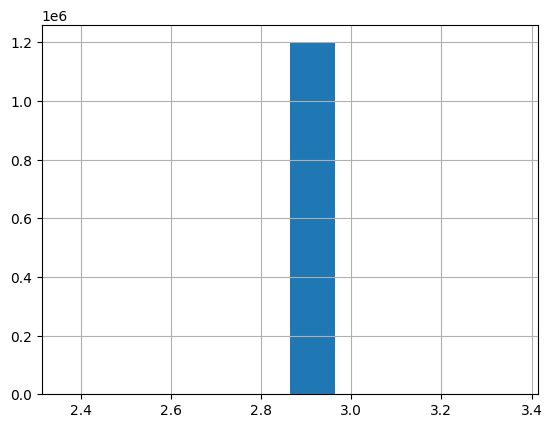

In [26]:
pd.Series(res).hist()

In [7]:
import miceforest as mf

In [5]:
kernel = mf.ImputationKernel(treated_dataset, num_datasets=1, random_state=1)


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Claim Frequency_null,Policy Start Year_null,Policy Start Month_null,Policy Start Day_null,Policy Start Hour_null,Policy Start Minute_null,Policy Start Second_null,Null columns_null,Annual Income log 10_null,Previous Claims log_null
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,...,False,False,False,False,False,False,False,False,False,False
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,...,False,False,False,False,False,False,False,False,False,False
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,...,False,False,False,False,False,False,False,False,False,False
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,...,False,False,False,False,False,False,False,False,False,False
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,...,True,False,False,False,False,False,False,False,False,True
1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,...,True,False,False,False,False,False,False,False,False,True
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,...,False,False,False,False,False,False,False,False,False,False
1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,...,False,False,False,False,False,False,False,False,True,False


In [46]:
from optbinning import ContinuousOptimalBinning


In [108]:
ContinuousOptimalBinning?

Init signature:
ContinuousOptimalBinning(
    name='',
    dtype='numerical',
    prebinning_method='cart',
    max_n_prebins=20,
    min_prebin_size=0.05,
    min_n_bins=None,
    max_n_bins=None,
    min_bin_size=None,
    max_bin_size=None,
    monotonic_trend='auto',
    min_mean_diff=0,
    max_pvalue=None,
    max_pvalue_policy='consecutive',
    gamma=0,
    outlier_detector=None,
    outlier_params=None,
    cat_cutoff=None,
    cat_unknown=None,
    user_splits=None,
    user_splits_fixed=None,
    special_codes=None,
    split_digits=None,
    time_limit=100,
    verbose=False,
    **prebinning_kwargs,
)
Docstring:     
Optimal binning of a numerical or categorical variable with respect to a
continuous target.

Parameters
----------
name : str, optional (default="")
    The variable name.

dtype : str, optional (default="numerical")
    The variable data type. Supported data types are "numerical" for
    continuous and ordinal variables and "categorical" for categorical
    a

In [58]:
binning = ContinuousOptimalBinning(name="Premium Amount", dtype="numerical")
binning.fit(treated_dataset["Credit Score"], treated_dataset["Premium Amount"])



ContinuousOptimalBinning(name='Premium Amount')

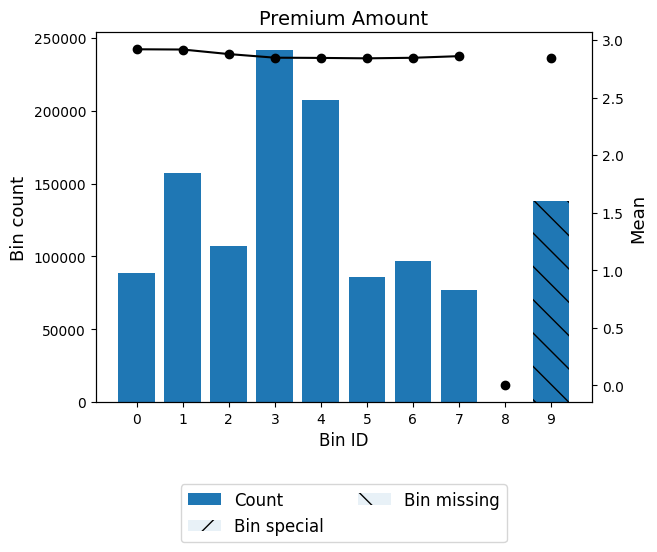

In [62]:
binning.binning_table.plot()


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit
from datetime import datetime
import numpy as np

# Define objective function
def objective(trial):
    param_grid = {
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'objective': 'regression',  # Use 'binary' for classification
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.1),  # Fine-tuned range
        'num_leaves': trial.suggest_int('num_leaves', 1, 50),  # Wider range for more exploration
        'max_depth': trial.suggest_int('max_depth', -1, 50),  # Allow deeper trees or unlimited depth (-1)
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 0.8),  # Sampling fraction of features
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.85, 1.0),  # Sampling fraction of data
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  # Frequency of bagging
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),  # Minimum samples per leaf
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-3, 0.1),  # Minimum gain for a split
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),  # Minimum weight for children
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10),  # L1 regularization
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10),  # L2 regularization
        'cat_smooth': trial.suggest_uniform('cat_smooth', 5, 30),  # Smoothing for categorical features
        'max_bin': trial.suggest_int('max_bin', 150, 200),  # Granularity of feature splits
        'verbose': -1,  # Suppress output
        'random_state': 41,  # Reproducibility
    }
    print(param_grid)
    
    # Define a 60-40 split
    splitter = ShuffleSplit(n_splits=5, test_size=0.4, random_state=1)


    results = []
    for train_idx, val_idx in splitter.split(X_train_fixed):
        # Prepare data for LightGBM
        X_train_fold, X_val_fold = X_train_fixed.iloc[train_idx], X_train_fixed.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        train_data_lgbm = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_data_lgbm = lgb.Dataset(X_val_fold, label=y_val_fold)
        
        # Train model
        model = lgb.train(
            param_grid,
            train_data_lgbm,
            num_boost_round=500,
            valid_sets=[train_data_lgbm, val_data_lgbm],
            valid_names=["train", "validation"],
            feval=rmsle_metric,    # Custom RMSLE metric
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=5),  # Optional: Logs evaluation every 10 rounds
            ]
        )
        results.append(model.best_score['validation']['rmsle'])
        
    # Use validation score
    return np.mean(results)